In [230]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io
import torch.nn as nn
import torch.nn.functional as F
import torch
from collections import deque
import random
import pandas as pd
import numpy as np
import torch.optim as optim
import random

## DQN Structure

In [231]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining network to optimize our Q function
        self.input = nn.Linear(14,50)
        self.dense1 = nn.Linear(50,50)
        self.out = nn.Linear(50, 3)
    ## Forward propagation
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.out(x)

        return x
    ## Train model
    def train(self,X,Y):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.02)
        running_loss = 0.0
        for i in range(len(X)):
            inputs, labels= torch.FloatTensor(X[i]), torch.FloatTensor(Y[i])
            optimizer.zero_grad()
            out = self.forward(inputs)
            loss = criterion(out, labels)
            loss.backward()          ## This does back propagation
            optimizer.step()         ## To optimize loss function 
            running_loss+=loss.item()  ## the value of the loss function after training
        
        return running_loss
    
    

## Reinforcement Learning Agent

In [232]:
class Agent:
    def __init__(self, state_size,window_size,trend, skip,batch_size,stock1,stock2):
        self.stock1 = stock1
        self.stock2 = stock2
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3 
        self.batch_size = batch_size
        self.memory = deque(maxlen = 10000000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.8
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.model = DQN()
        self.daily_returns = []
        
    def act(self,state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return torch.argmax(self.model(torch.FloatTensor(state)))
    
    def get_state(self,t):
        current_mean = sum(self.trend[:t+1])/len(self.trend[:t+1])
        
        
        daily_returns = self.trend[t] - self.trend[t-1] if t >= 1 else 0.0
        spread_mean_30 = sum(self.trend[t-29:t+1]) / 30 if t>=30 else sum(self.trend[:t+1])/(t+1)
        mean_over_30 = current_mean/spread_mean_30
        spread_mean_20 = sum(self.trend[t-19:t+1]) / 20 if t>=20 else sum(self.trend[:t+1])/(t+1)
        mean_over_20 = current_mean/spread_mean_20
        spread_mean_15 = sum(self.trend[t-14:t+1]) / 15 if t>=15 else sum(self.trend[:t+1]) /(t+1)
        mean_over_15 = current_mean / spread_mean_15
        spread_mean_10 = sum(self.trend[t-9:t+1]) / 10 if t>=10 else sum(self.trend[:t+1]) /(t+1)
        mean_over_10 = current_mean/spread_mean_10
        spread_mean_7 = sum(self.trend[t-6:t+1]) / 7 if t>=7 else sum(self.trend[:t+1]) /(t+1)
        mean_over_7 = current_mean/spread_mean_7
        spread_mean_5 = sum(self.trend[t-4:t+1]) / 5 if t>=5 else sum(self.trend[:t+1]) /(t+1)
        mean_over_5 = current_mean/spread_mean_5
        
        state = [self.trend[t],daily_returns,
                 spread_mean_30,mean_over_30,
                 spread_mean_20,mean_over_20,
                 spread_mean_15,mean_over_15,
                 spread_mean_10,mean_over_10,
                 spread_mean_7,mean_over_7,
                 spread_mean_5,mean_over_5]
        
        return np.array([state])
    
    #ORIGINAL
    def buy(self,initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory1 = [self.stock1[0]]
        inventory2 = [self.stock2[0]]
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            bought_price = 0
            
            if action == 1 and starting_money >= abs(self.trend[t]) and len(inventory2)>0:
                bought_price = inventory2.pop(0)
                inventory1.append(self.stock1[t])
                daily_initial_money = initial_money
                initial_money = daily_initial_money - self.stock1[t] + self.stock2[t]
                daily_return = (initial_money - daily_initial_money)/daily_initial_money * 100
                self.daily_returns.append(daily_return)

                states_buy.append(t)
                print('day %d: buy 1 sell 2 at difference %f, total balance %f'% (t,  self.stock2[t] - self.stock1[t], initial_money))
                
            elif action == 2 and starting_money >= abs(self.trend[t]) and len(inventory1)>0:
                bought_price = inventory1.pop(0)
                inventory2.append(self.stock2[t])
                daily_initial_money = initial_money
                initial_money = daily_initial_money - self.stock2[t] + self.stock1[t]
                daily_return = (initial_money - daily_initial_money)/daily_initial_money * 100
                self.daily_returns.append(daily_return)
                
                states_sell.append(t)
                print('day %d: buy 2 sell 1 at difference %f, total balance %f'% (t, self.stock1[t] - self.stock2[t] , initial_money))

            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest






    
    def replay(self,batch_size):
        ## Add randomization for the data taken for training
        mini_batch = []
        l = len(self.memory)
        for i in range(l-batch_size,l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.model(torch.FloatTensor(states)).tolist()
        Q_new = self.model(torch.FloatTensor(new_states)).tolist()

        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            
            if not done:
                target[action] += self.gamma * max(Q_new[i])
            X[i] = state
            Y[i] = target
        cost = self.model.train(X,Y)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def train(self, iterations, checkpoint, initial_money):
        
        for i in range(iterations):
            number_of_actions = 0
            total_profit = 0
            inventory1 = [self.stock1[0]]
            inventory2 = [self.stock2[0]]
            state = self.get_state(0)
            starting_money = initial_money
            money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                ## Check if the action is 1 and if I have enough money to execute the action
                if action == 1 and self.stock1[t]<=self.stock2[t] and len(inventory2)>0:
                    number_of_actions +=1
                    bought_price = inventory2.pop(0)
                    inventory1.append(self.stock1[t])
                    starting_money = starting_money  - self.stock1[t] + self.stock2[t]
                ## Check if the action is 2 and if I have enough money to execute the action
                elif action == 2 and self.stock1[t]>=self.stock2[t] and len(inventory1)>0:
                    number_of_actions +=1
                    bought_price = inventory1.pop(0)
                    inventory2.append(self.stock2[t])
                    starting_money = starting_money  - self.stock2[t] + self.stock1[t]

                ## Calculate the return on investment after the action 

                invest = ((starting_money - initial_money) / initial_money)*100
               
                ## Add the action, and its resultls to the memory for training
                
                self.memory.append((state, action, invest, 
                                    next_state, invest<0))
                
                state = next_state
                money = starting_money
            
            batch_size = min(self.batch_size, len(self.memory))
            random.shuffle(self.memory)
            cost = self.replay(batch_size)
            if len(self.memory) == 10000:
                self.memory.clear()
            
                
            ## MEMORY NEEDS TO BE EMPTIED
            total_profit = starting_money-initial_money
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f, The number of taken actions: %d'%(i + 1, total_profit, cost,
                                                                                  starting_money,number_of_actions))               

In [233]:
initial_money = 100000
window_size = 14
skip = 1
batch_size = 20

In [234]:
import matplotlib.pyplot as plt
def train_test_pair(df_train, df_test,x_name, y_name):
    agent = Agent(state_size = window_size, 
                window_size = window_size, 
                trend = df_train['spread'], 
                skip = skip, 
                batch_size = batch_size,
                stock1 = df_train['Adj Close_x'],
                stock2 = df_train['Adj Close_y'])

    agent.train(iterations = 100, checkpoint = 20, initial_money = initial_money)

    agent.stock2 = df_test['Adj Close_x']
    agent.stock1 = df_test['Adj Close_y']
    agent.trend = df_test['spread']

    #Running the test

    states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

    pair_name = f"{x_name}/{y_name}"

    fig = plt.figure(figsize=(20, 10))
    plt.plot(agent.trend, color='r', lw=2.)
    plt.plot(agent.trend, '^', markersize=10, color='m', label='buying signal', markevery=states_buy)
    plt.plot(agent.trend, 'v', markersize=10, color='k', label='selling signal', markevery=states_sell)
    plt.title(f"{pair_name} - Total Dollar Profit: {total_gains:.2f}$, Total Return: {invest:.2f}%", size=20)
    plt.ylabel("Spread", size=18)
    plt.xlabel("Date", size=18)
    plt.legend()
    plt.text(0.02, 0.95, pair_name, transform=fig.transFigure, size=20, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()
    fig.savefig(f"{x_name}_{y_name}_actions_over_spread.png", dpi=500)

    fig = plt.figure(figsize = (20,10))
    positions = ['Short','No Position','Long']
    states_no = len(df_test) - len(states_buy)-len(states_sell)
    count_position = [len(states_sell),states_no,len(states_buy)]

    plt.bar(positions, count_position)
    plt.title('Count of each position/action',size=20)
    plt.ylabel('Count',size=18)
    plt.show()
    fig.savefig("Action_count.png",dpi=500)

    daily_returns = np.array(agent.daily_returns)
    daily_returns_perecent = daily_returns/initial_money*100
   

    # Calculate annual return and annual volatility
    annual_return = np.mean(daily_returns_perecent) * 252
    annual_volatility = np.std(daily_returns_perecent) * np.sqrt(252)

    # Calculate Sharpe ratio
    sharpe_ratio = annual_return / annual_volatility

    # Print the results
    print('Annual return:', annual_return)
    print('Annual volatility:', annual_volatility)
    print("Sharpe ratio:", sharpe_ratio)

Giving the agent the right data for testing

epoch: 20, total rewards: 104.899902.3, cost: 254.940072, total money: 100104.899902, The number of taken actions: 1
epoch: 40, total rewards: 106.699707.3, cost: 99.201241, total money: 100106.699707, The number of taken actions: 1
epoch: 60, total rewards: 104.700195.3, cost: 9.072206, total money: 100104.700195, The number of taken actions: 1
epoch: 80, total rewards: 108.699707.3, cost: 0.020250, total money: 100108.699707, The number of taken actions: 1
epoch: 100, total rewards: 108.399902.3, cost: 0.009966, total money: 100108.399902, The number of taken actions: 1
day 0: buy 2 sell 1 at difference -337.000000, total balance 99663.000000
day 1: buy 1 sell 2 at difference 333.800293, total balance 99996.800293
day 2: buy 1 sell 2 at difference 321.000000, total balance 100317.800293
day 14: buy 2 sell 1 at difference -302.000000, total balance 100015.800293
day 15: buy 1 sell 2 at difference 286.500000, total balance 100302.300293
day 16: buy 2 sell 1 at difference -276.200195, t

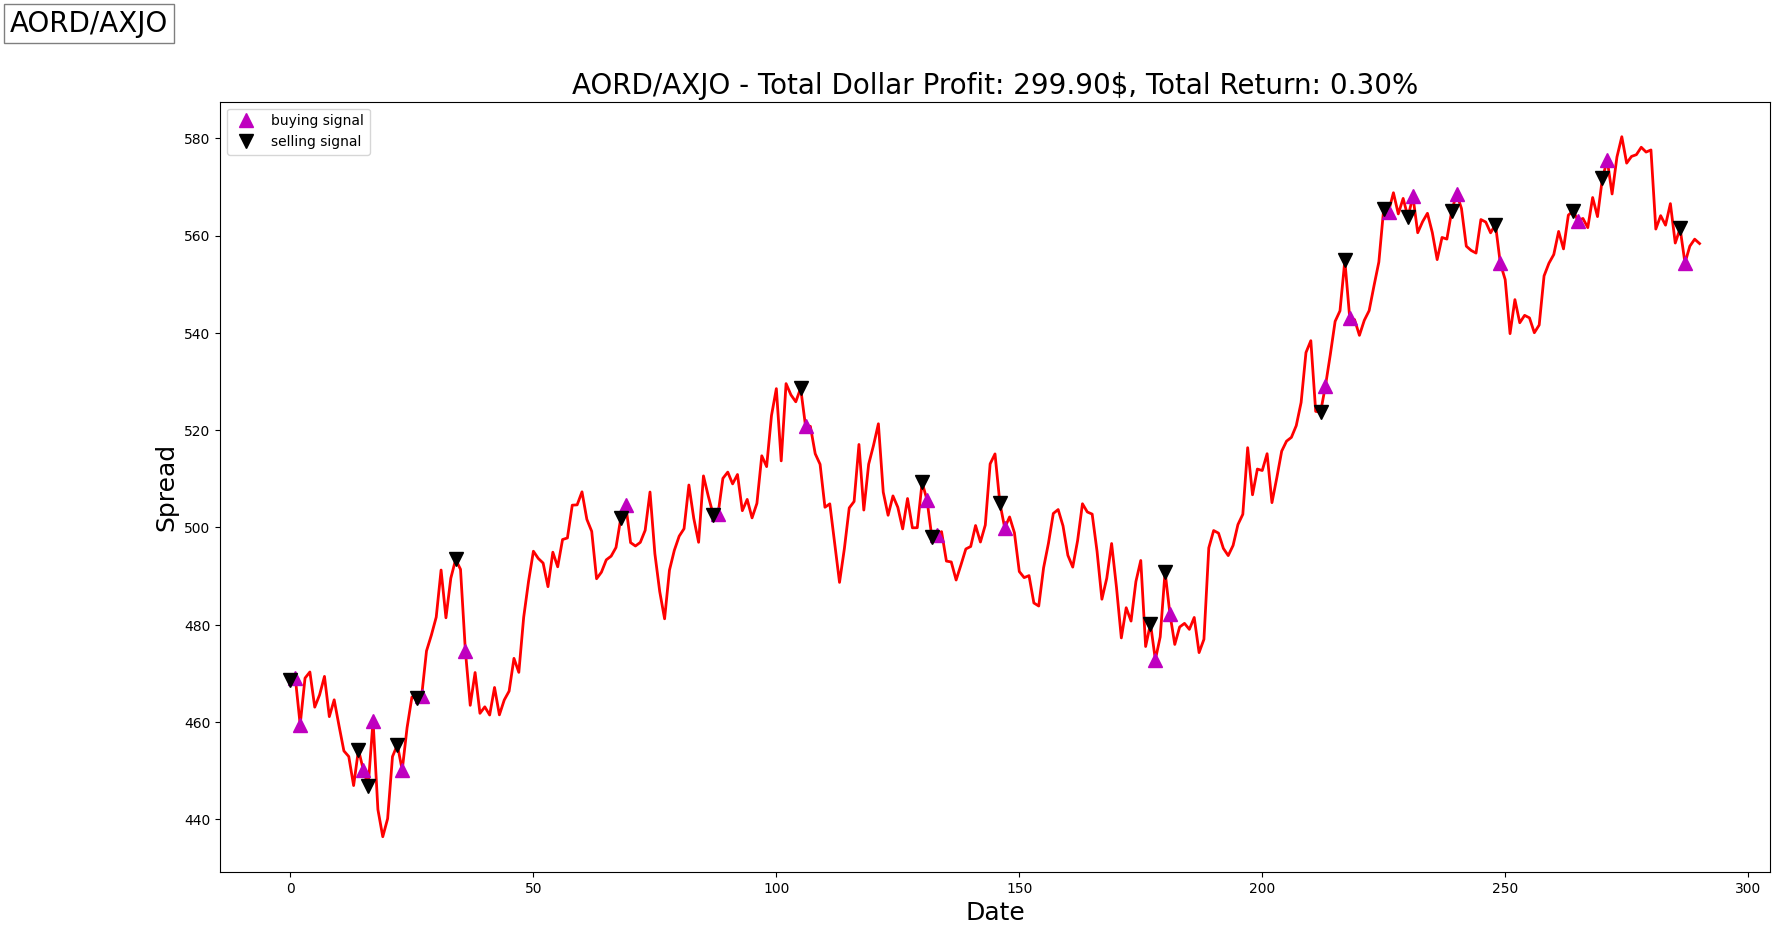

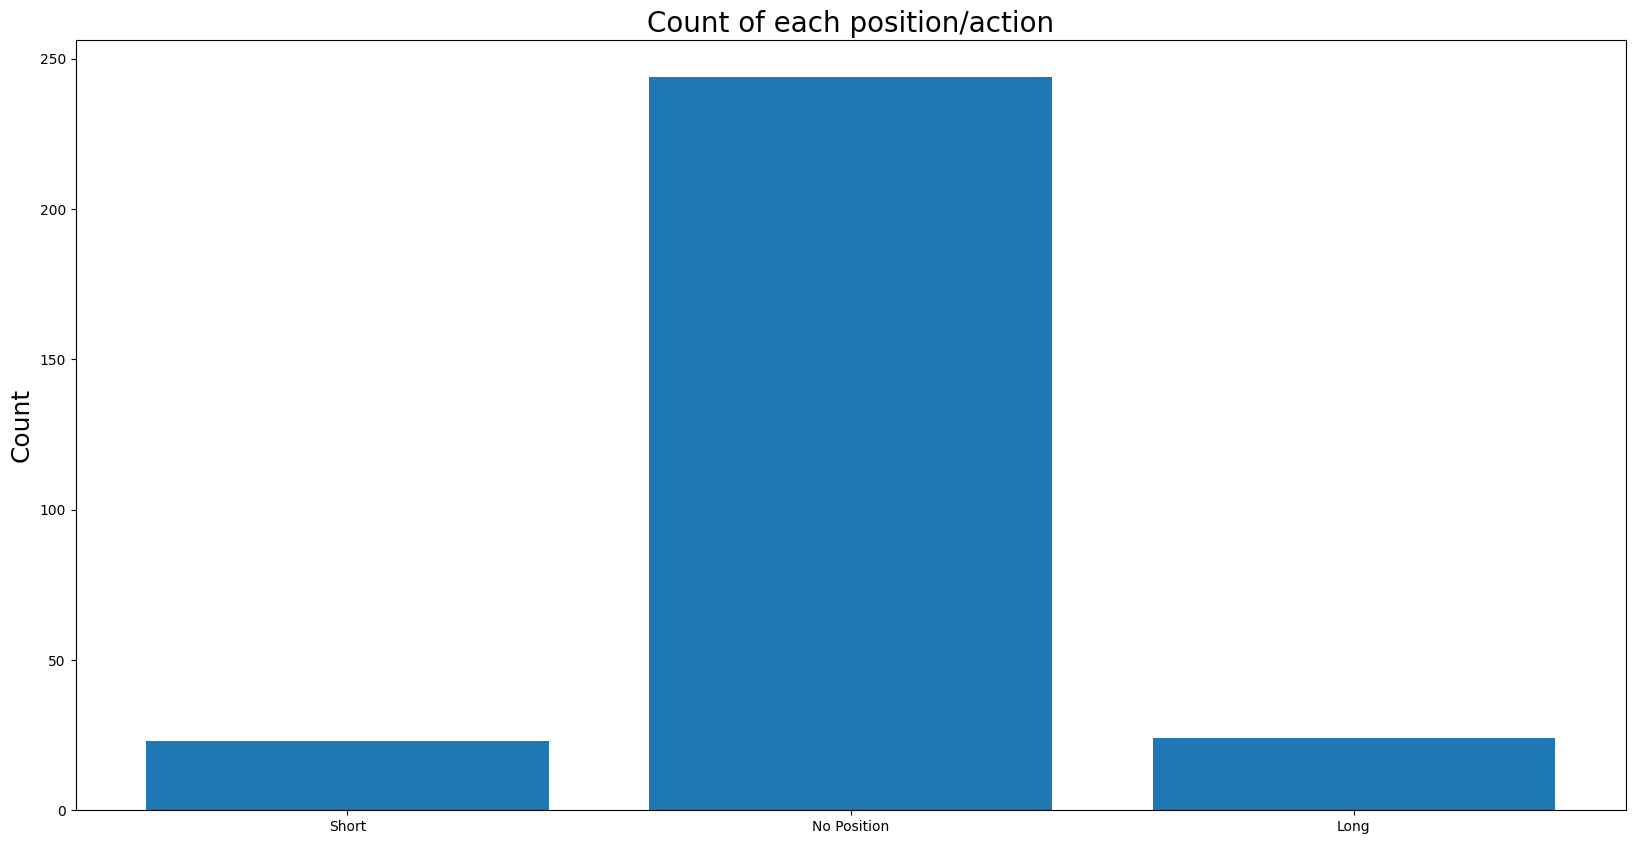

Annual return: 0.0016775296675795022
Annual volatility: 0.0037922510344291747
Sharpe ratio: 0.4423572311931641


In [235]:
df_train = pd.read_csv('data/^AORD_^AXJO_train.csv')
df_test = pd.read_csv('data/^AORD_^AXJO_test.csv')

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

train_test_pair(df_train, df_test, 'AORD', 'AXJO' )

epoch: 20, total rewards: 4615.989990.3, cost: 6594.441438, total money: 104615.989990, The number of taken actions: 1
epoch: 40, total rewards: 4563.030151.3, cost: 2158.369686, total money: 104563.030151, The number of taken actions: 1
epoch: 60, total rewards: 4629.679932.3, cost: 4257.875877, total money: 104629.679932, The number of taken actions: 1
epoch: 80, total rewards: 4674.689941.3, cost: 2521.790942, total money: 104674.689941, The number of taken actions: 1
epoch: 100, total rewards: 4615.989990.3, cost: 3747.574563, total money: 104615.989990, The number of taken actions: 1
day 3: buy 2 sell 1 at difference -5594.589844, total balance 94405.410156
day 27: buy 1 sell 2 at difference 5514.310059, total balance 99919.720215
day 30: buy 1 sell 2 at difference 5546.709839, total balance 105466.430054
day 36: buy 2 sell 1 at difference -5275.110107, total balance 100191.319946
day 52: buy 1 sell 2 at difference 5532.360107, total balance 105723.680054
day 82: buy 2 sell 1 at d

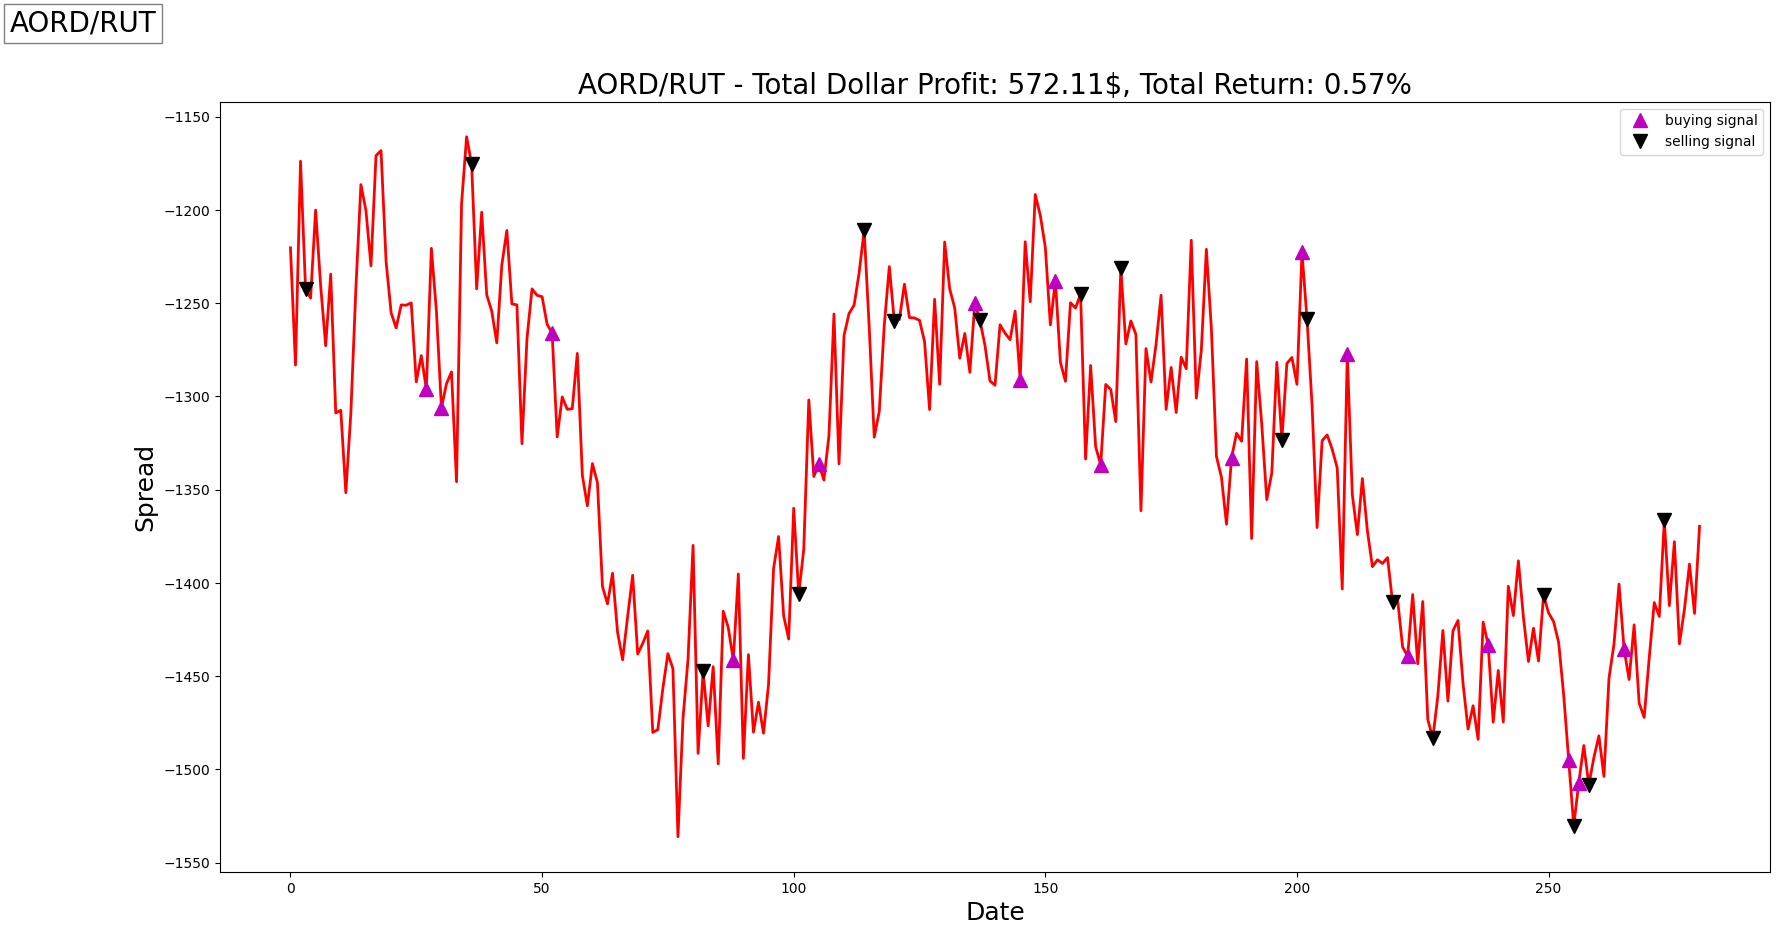

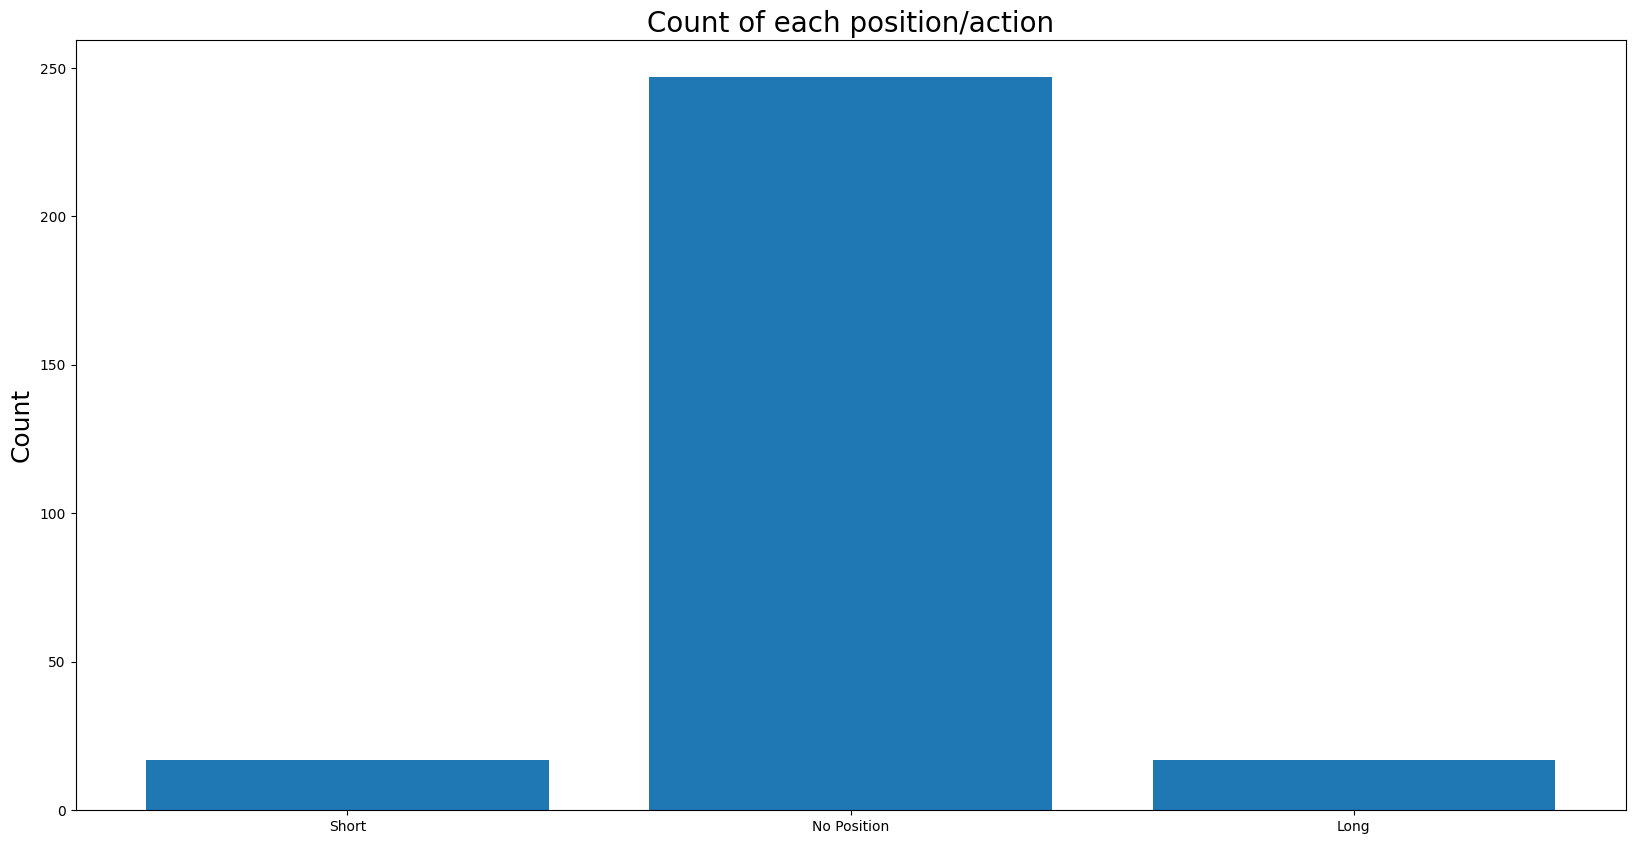

Annual return: 0.04008944342004725
Annual volatility: 0.0847247083631658
Sharpe ratio: 0.4731729880757689


In [236]:
df_train = pd.read_csv('data/^AORD_^RUT_train.csv')
df_test = pd.read_csv('data/^AORD_^RUT_test.csv')

train_test_pair(df_train, df_test, 'AORD', 'RUT' )


epoch: 20, total rewards: 6736.719727.3, cost: 10649.915637, total money: 106736.719727, The number of taken actions: 1
epoch: 40, total rewards: 6879.339844.3, cost: 7583.469440, total money: 106879.339844, The number of taken actions: 1
epoch: 60, total rewards: 6781.980469.3, cost: 1147.494621, total money: 106781.980469, The number of taken actions: 1
epoch: 80, total rewards: 6736.719727.3, cost: 5223.193689, total money: 106736.719727, The number of taken actions: 1
epoch: 100, total rewards: 7080.960449.3, cost: 14851.511604, total money: 107080.960449, The number of taken actions: 1
day 0: buy 2 sell 1 at difference 9409.959961, total balance 109409.959961
day 7: buy 1 sell 2 at difference -9461.519531, total balance 99948.440430
day 8: buy 2 sell 1 at difference 9501.960449, total balance 109450.400879
day 26: buy 1 sell 2 at difference -9149.190430, total balance 100301.210449
day 27: buy 2 sell 1 at difference 8996.210449, total balance 109297.420898
day 32: buy 1 sell 2 at 

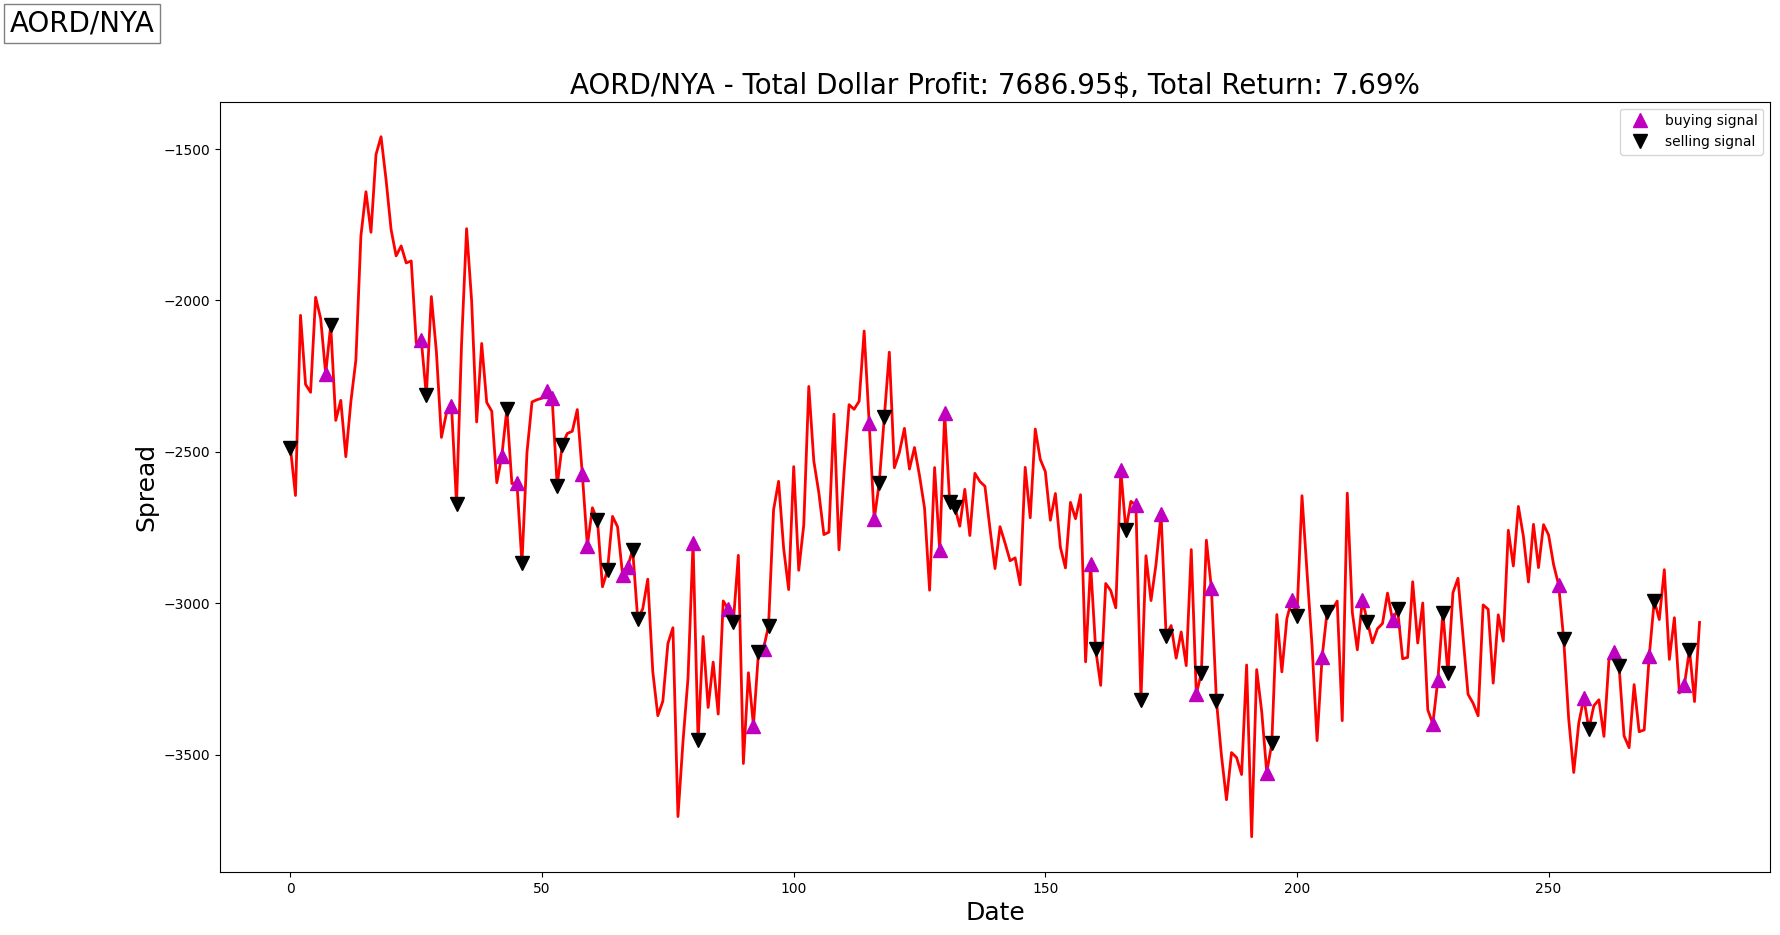

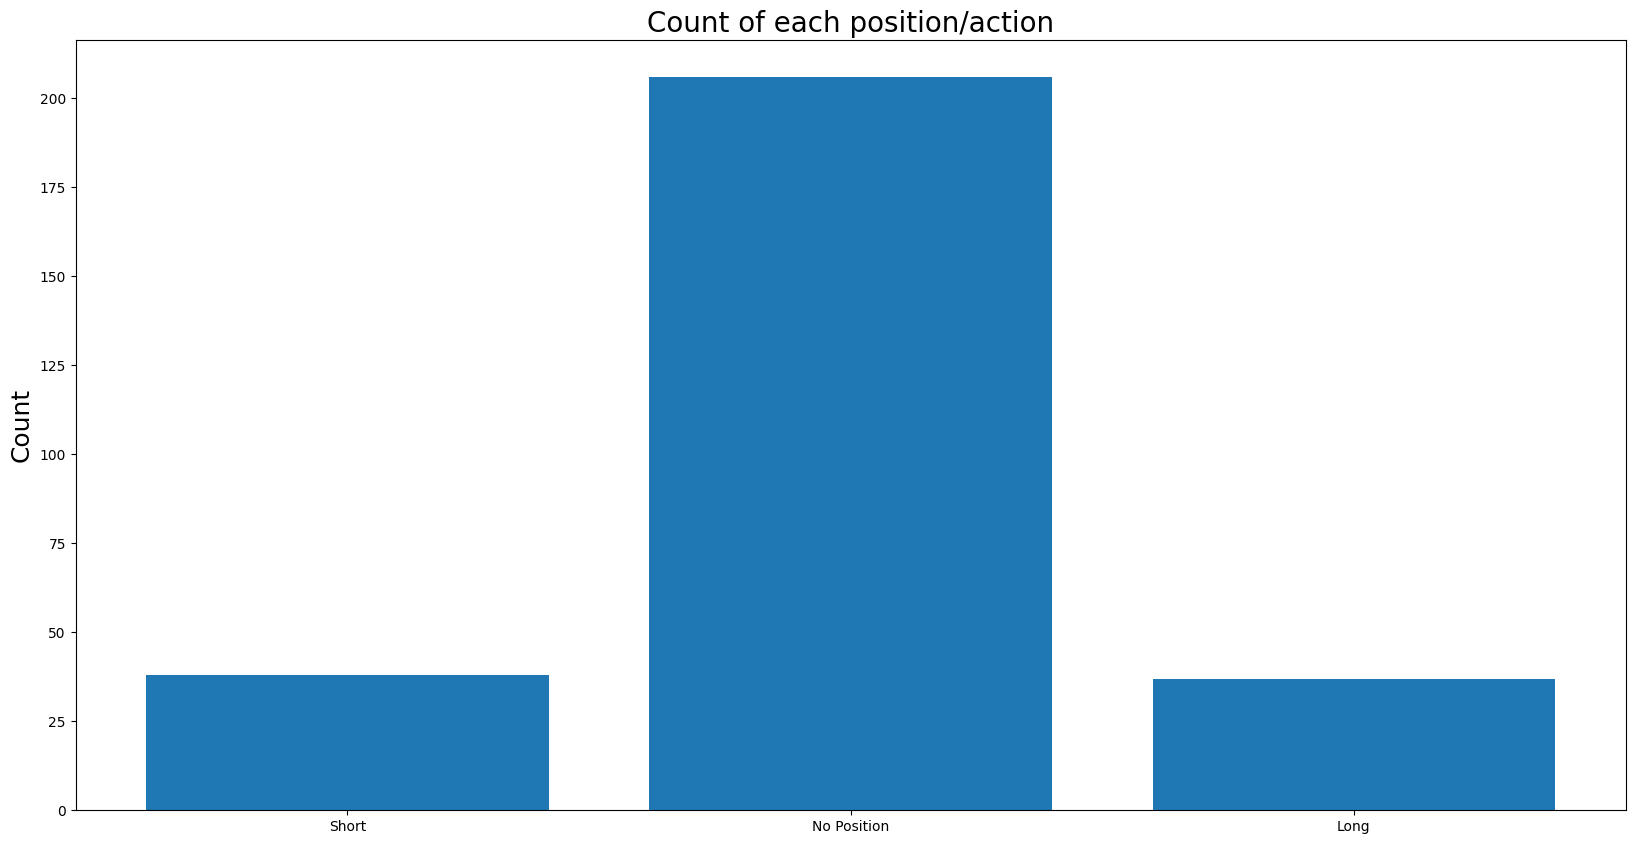

Annual return: 0.10510319054537935
Annual volatility: 0.12673702803006054
Sharpe ratio: 0.8293013666096866


In [265]:
df_train = pd.read_csv('data/^AORD_^NYA_train.csv')
df_test = pd.read_csv('data/^AORD_^NYA_test.csv')

train_test_pair(df_train, df_test, 'AORD', 'NYA' )

epoch: 20, total rewards: 5066.379883.3, cost: 600.949412, total money: 105066.379883, The number of taken actions: 1
epoch: 40, total rewards: 5030.699829.3, cost: 494.184424, total money: 105030.699829, The number of taken actions: 1
epoch: 60, total rewards: 5025.520142.3, cost: 597.789265, total money: 105025.520142, The number of taken actions: 1
epoch: 80, total rewards: 5030.699829.3, cost: 551.180953, total money: 105030.699829, The number of taken actions: 1
epoch: 100, total rewards: 5004.890137.3, cost: 267.767644, total money: 105004.890137, The number of taken actions: 1
day 0: buy 2 sell 1 at difference -6206.309814, total balance 93793.690186
day 45: buy 1 sell 2 at difference 5842.719971, total balance 99636.410156
day 50: buy 1 sell 2 at difference 5930.900146, total balance 105567.310303
day 57: buy 2 sell 1 at difference -6144.240234, total balance 99423.070068
day 73: buy 2 sell 1 at difference -6296.030151, total balance 93127.039917
day 84: buy 1 sell 2 at differe

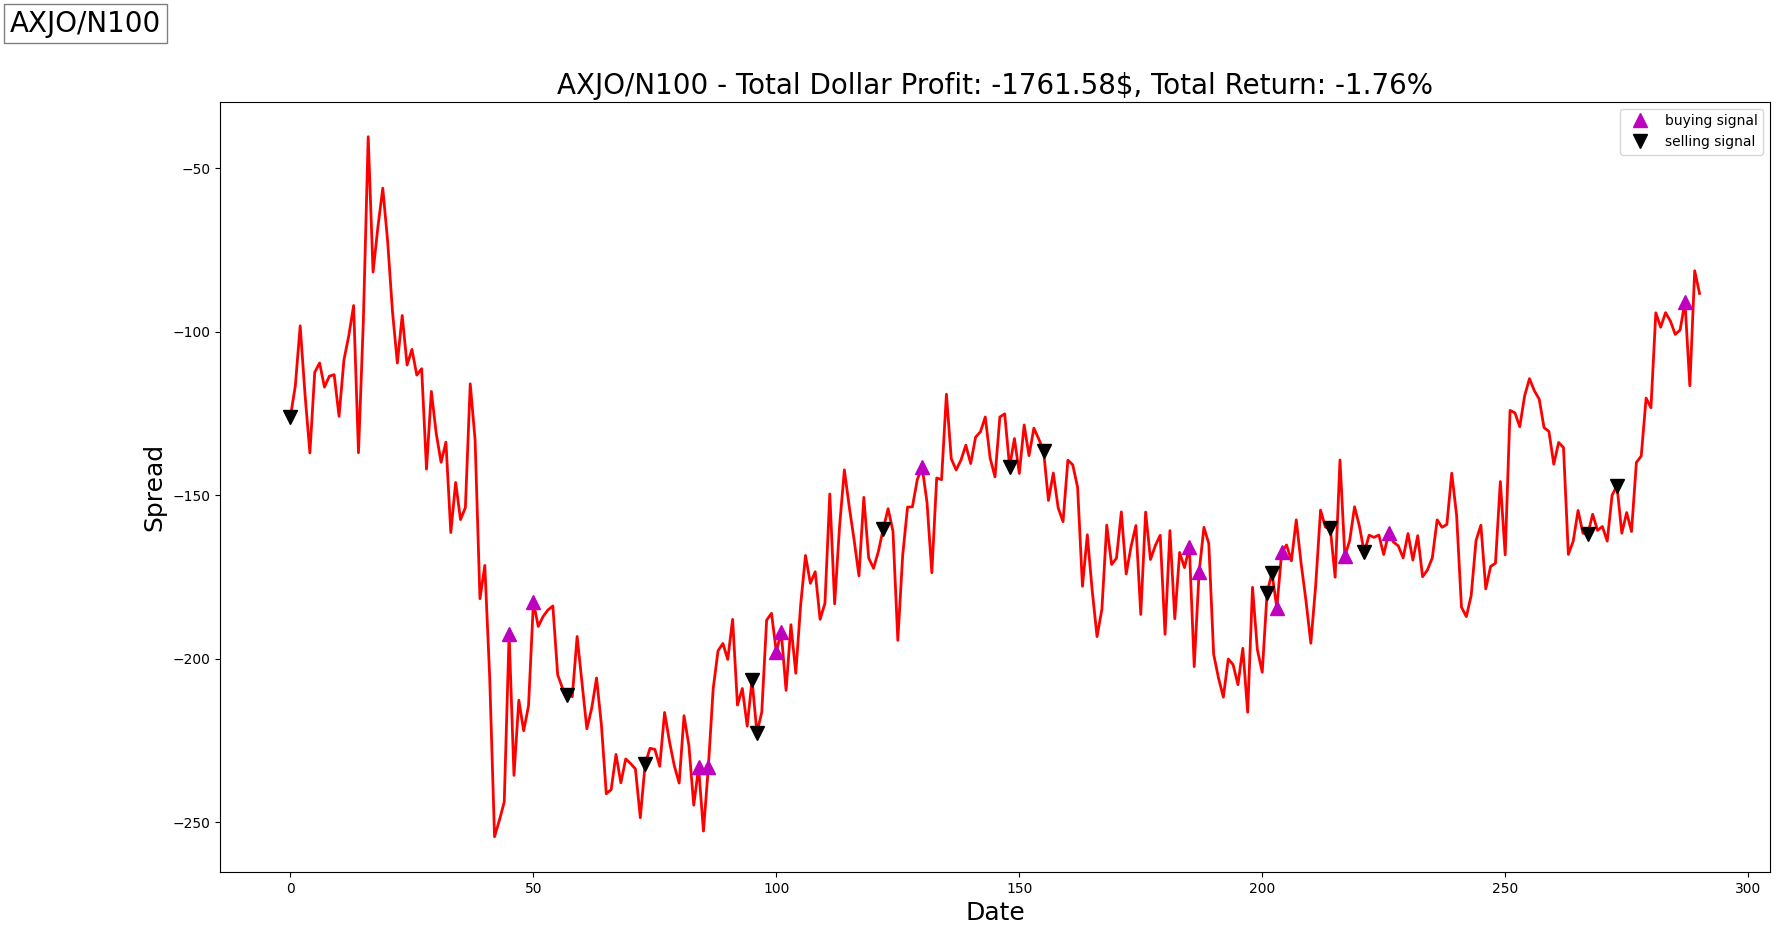

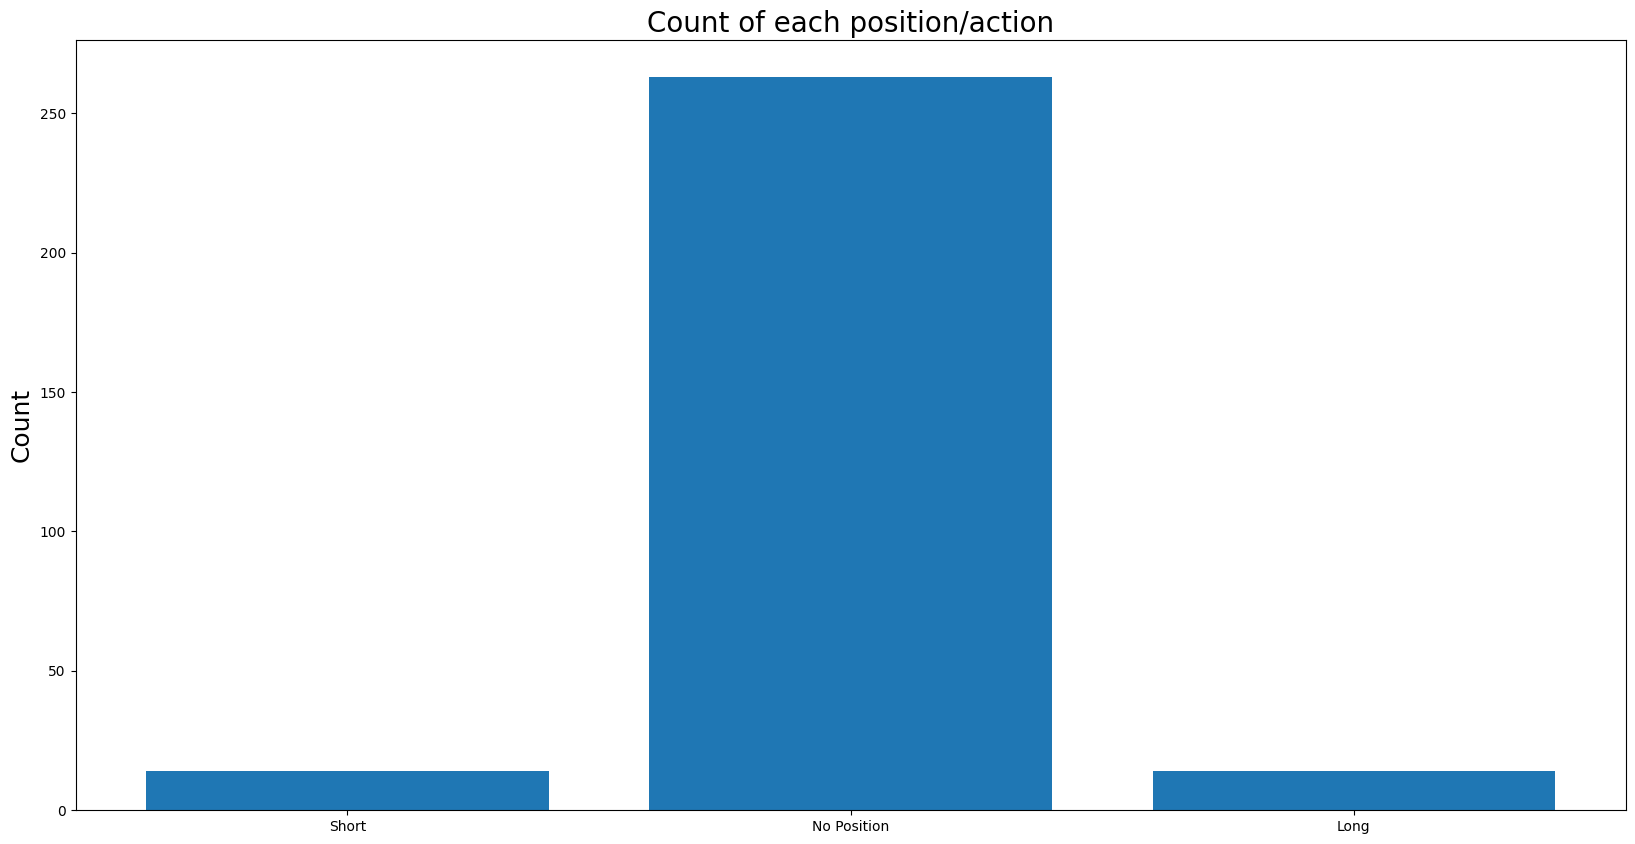

Annual return: 0.027640126951996094
Annual volatility: 0.09342256645844399
Sharpe ratio: 0.29586135341604974


In [264]:
df_train = pd.read_csv('data/^AXJO_^N100_train.csv')
df_test = pd.read_csv('data/^AXJO_^N100_test.csv')

train_test_pair(df_train, df_test, 'AXJO', 'N100' )

epoch: 20, total rewards: 6980.930664.3, cost: 227.664738, total money: 106980.930664, The number of taken actions: 1
epoch: 40, total rewards: 6886.880371.3, cost: 64.376030, total money: 106886.880371, The number of taken actions: 1
epoch: 60, total rewards: 7437.110352.3, cost: 291.862911, total money: 107437.110352, The number of taken actions: 1
epoch: 80, total rewards: 7478.470215.3, cost: 31.006037, total money: 107478.470215, The number of taken actions: 1
epoch: 100, total rewards: 7224.220215.3, cost: 49.837263, total money: 107224.220215, The number of taken actions: 1
day 0: buy 1 sell 2 at difference -9746.959961, total balance 90253.040039
day 1: buy 2 sell 1 at difference 9546.799805, total balance 99799.839844
day 2: buy 1 sell 2 at difference -9798.219727, total balance 90001.620117
day 5: buy 2 sell 1 at difference 9904.438965, total balance 99906.059082
day 6: buy 1 sell 2 at difference -9914.859863, total balance 89991.199219
day 13: buy 2 sell 1 at difference 9274

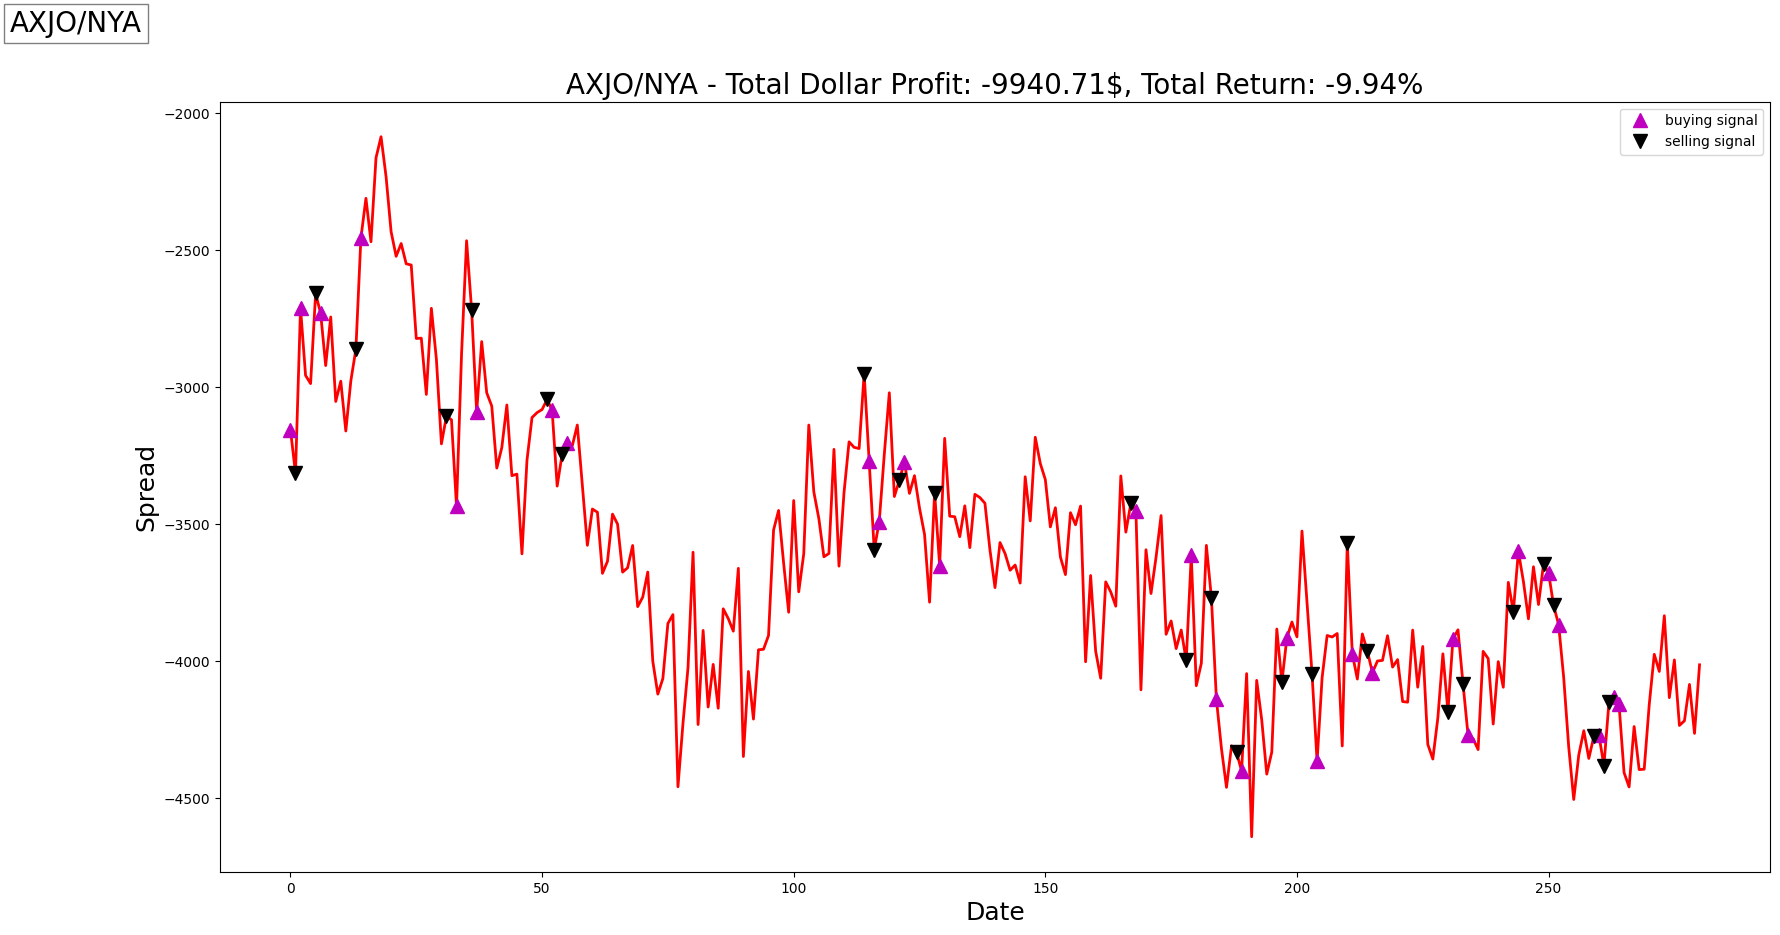

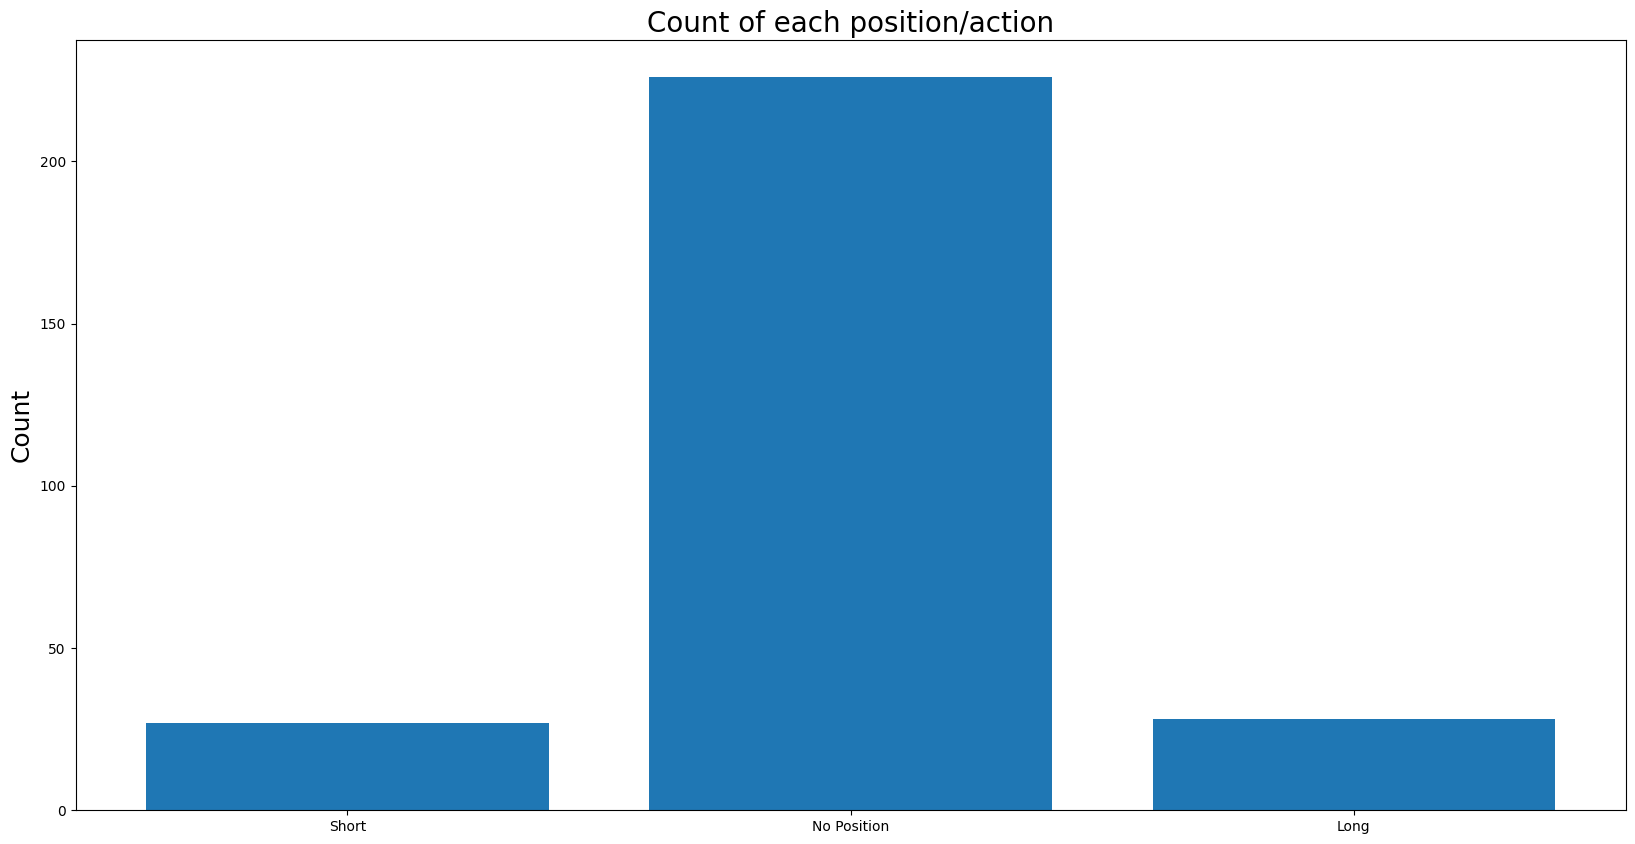

Annual return: 0.05176816933196818
Annual volatility: 0.14136511332285562
Sharpe ratio: 0.3662018733981265


In [263]:
df_train = pd.read_csv('data/^AXJO_^NYA_train.csv')
df_test = pd.read_csv('data/^AXJO_^NYA_test.csv')

train_test_pair(df_train, df_test, 'AXJO', 'NYA' )

epoch: 20, total rewards: 521.809570.3, cost: 2.293004, total money: 100521.809570, The number of taken actions: 1
epoch: 40, total rewards: 567.410156.3, cost: 3.065147, total money: 100567.410156, The number of taken actions: 1
epoch: 60, total rewards: 772.699707.3, cost: 1.032625, total money: 100772.699707, The number of taken actions: 1
epoch: 80, total rewards: 501.740234.3, cost: 0.763846, total money: 100501.740234, The number of taken actions: 1
epoch: 100, total rewards: 772.699707.3, cost: 0.769494, total money: 100772.699707, The number of taken actions: 1
day 0: buy 1 sell 2 at difference 272.389648, total balance 100272.389648
day 1: buy 2 sell 1 at difference -189.429688, total balance 100082.959961
day 2: buy 2 sell 1 at difference -108.639648, total balance 99974.320312
day 4: buy 1 sell 2 at difference 331.330078, total balance 100305.650391
day 5: buy 1 sell 2 at difference 206.720215, total balance 100512.370605
day 16: buy 2 sell 1 at difference 185.500000, total 

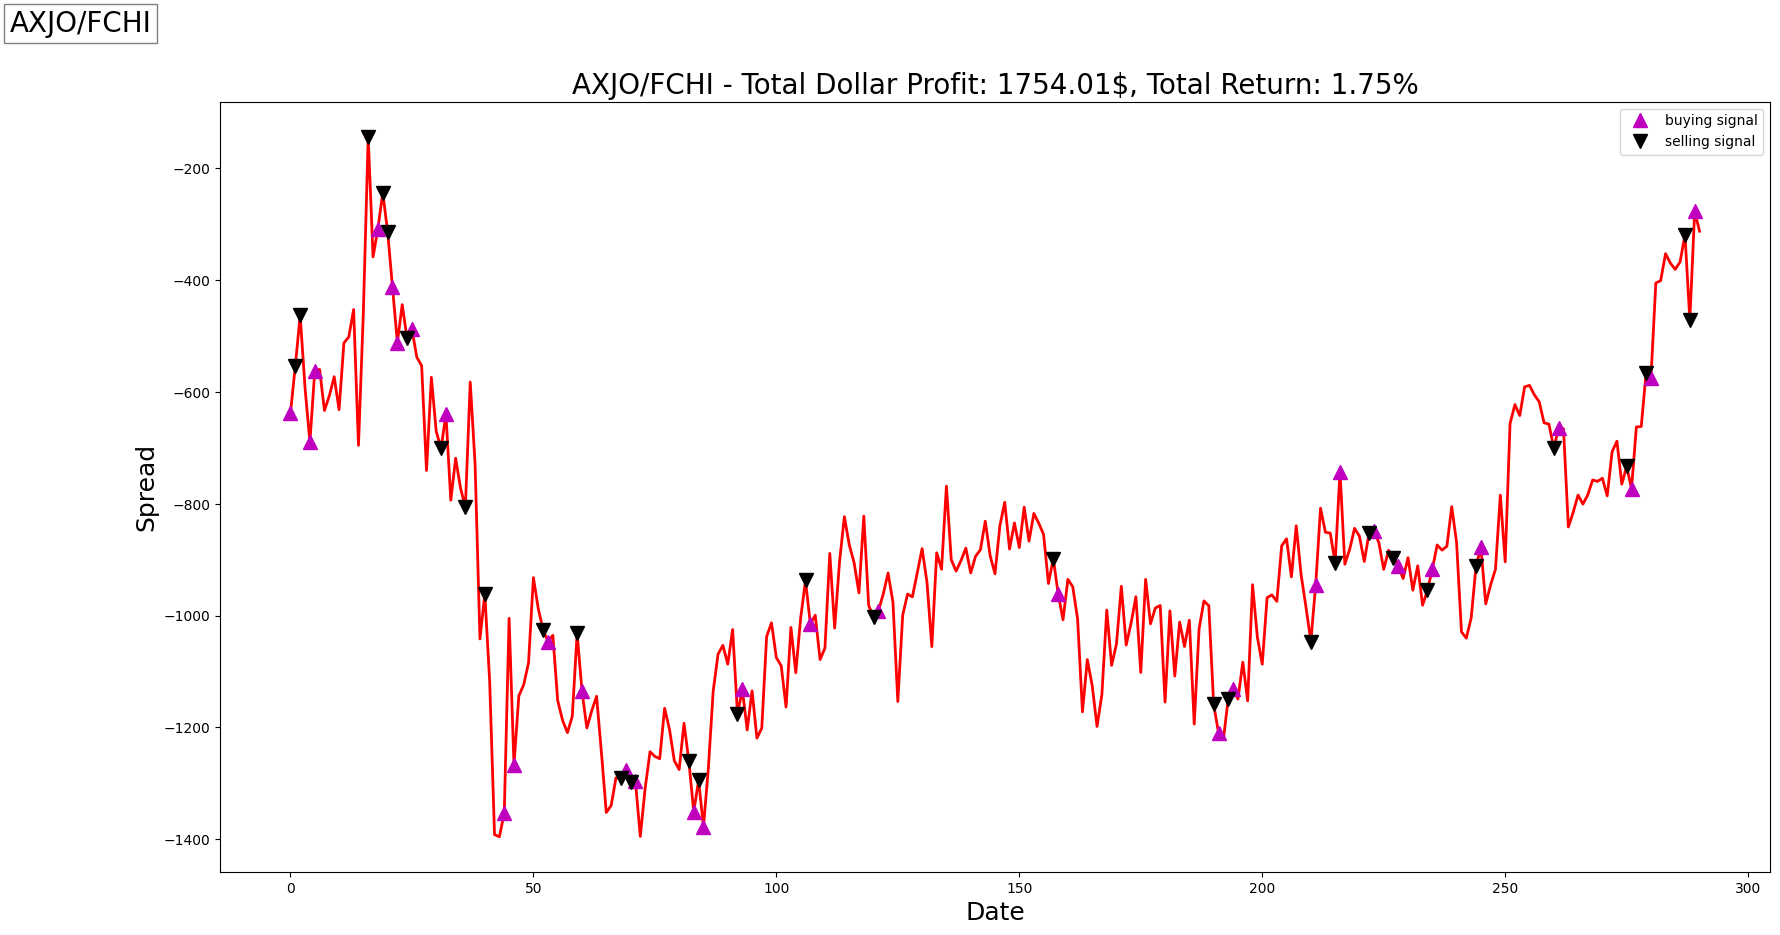

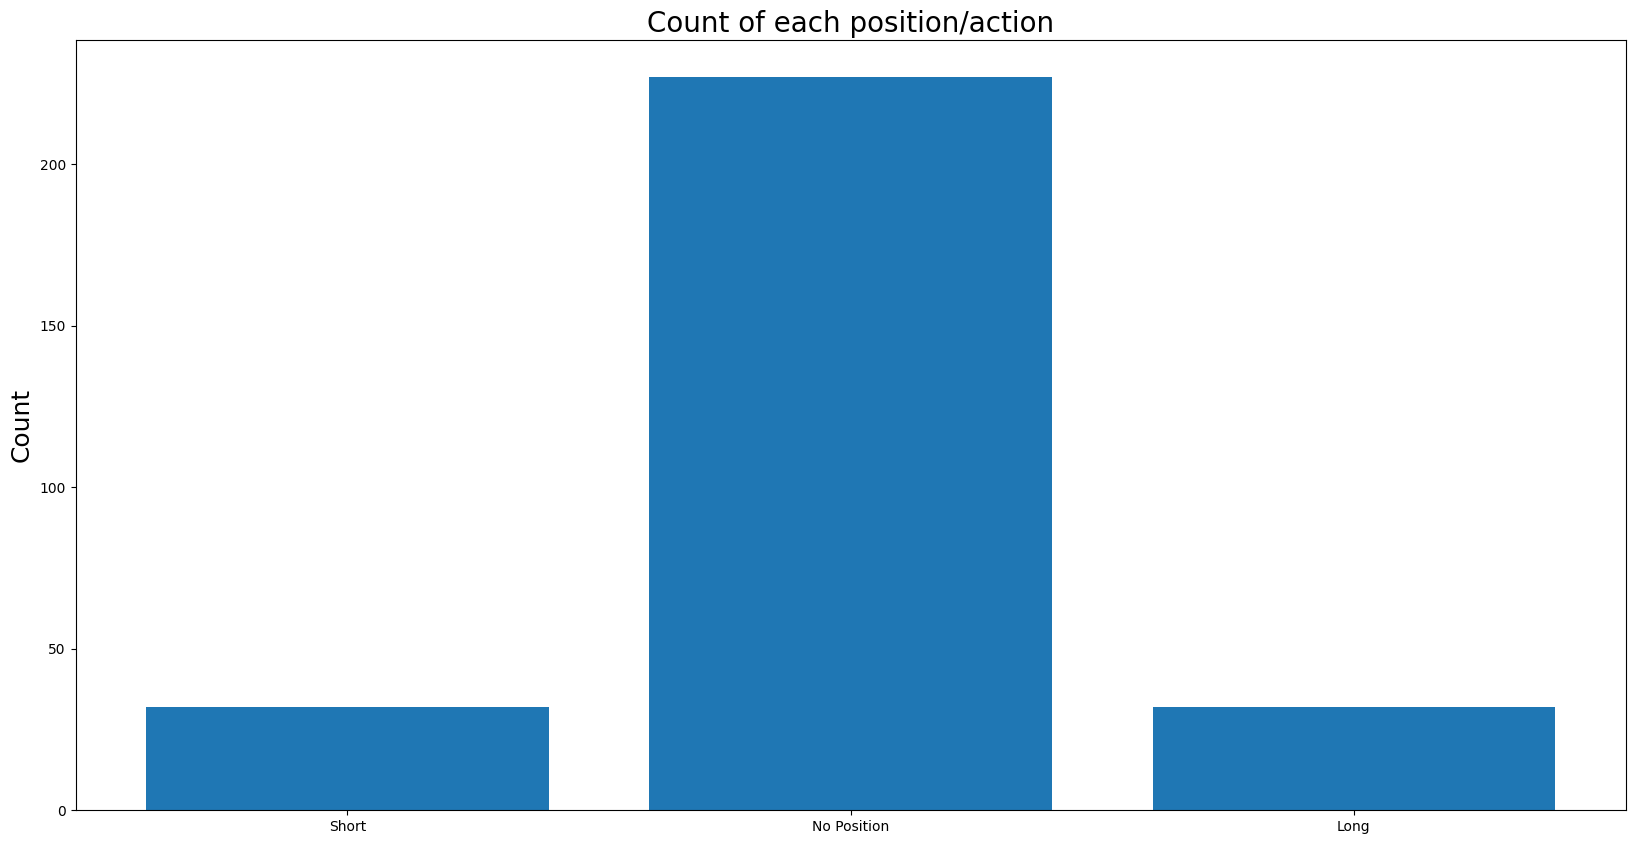

Annual return: 0.0072916882840001395
Annual volatility: 0.009427251667164474
Sharpe ratio: 0.7734691447134487


In [262]:
df_train = pd.read_csv('data/^AXJO_^FCHI_train.csv')
df_test = pd.read_csv('data/^AXJO_^FCHI_test.csv')

train_test_pair(df_train, df_test, 'AXJO', 'FCHI' )

epoch: 20, total rewards: 758.950195.3, cost: 3.210749, total money: 100758.950195, The number of taken actions: 1
epoch: 40, total rewards: 877.399902.3, cost: 2.303534, total money: 100877.399902, The number of taken actions: 1
epoch: 60, total rewards: 652.080078.3, cost: 1.540036, total money: 100652.080078, The number of taken actions: 1
epoch: 80, total rewards: 758.950195.3, cost: 0.701671, total money: 100758.950195, The number of taken actions: 1
epoch: 100, total rewards: 758.950195.3, cost: 0.527203, total money: 100758.950195, The number of taken actions: 1
day 8: buy 1 sell 2 at difference 574.100098, total balance 100574.100098
day 11: buy 2 sell 1 at difference -483.620117, total balance 100090.479980
day 16: buy 1 sell 2 at difference 90.700195, total balance 100181.180176
day 35: buy 2 sell 1 at difference -693.229980, total balance 99487.950195
day 61: buy 1 sell 2 at difference 1129.729980, total balance 100617.680176
day 72: buy 2 sell 1 at difference -1333.109863, 

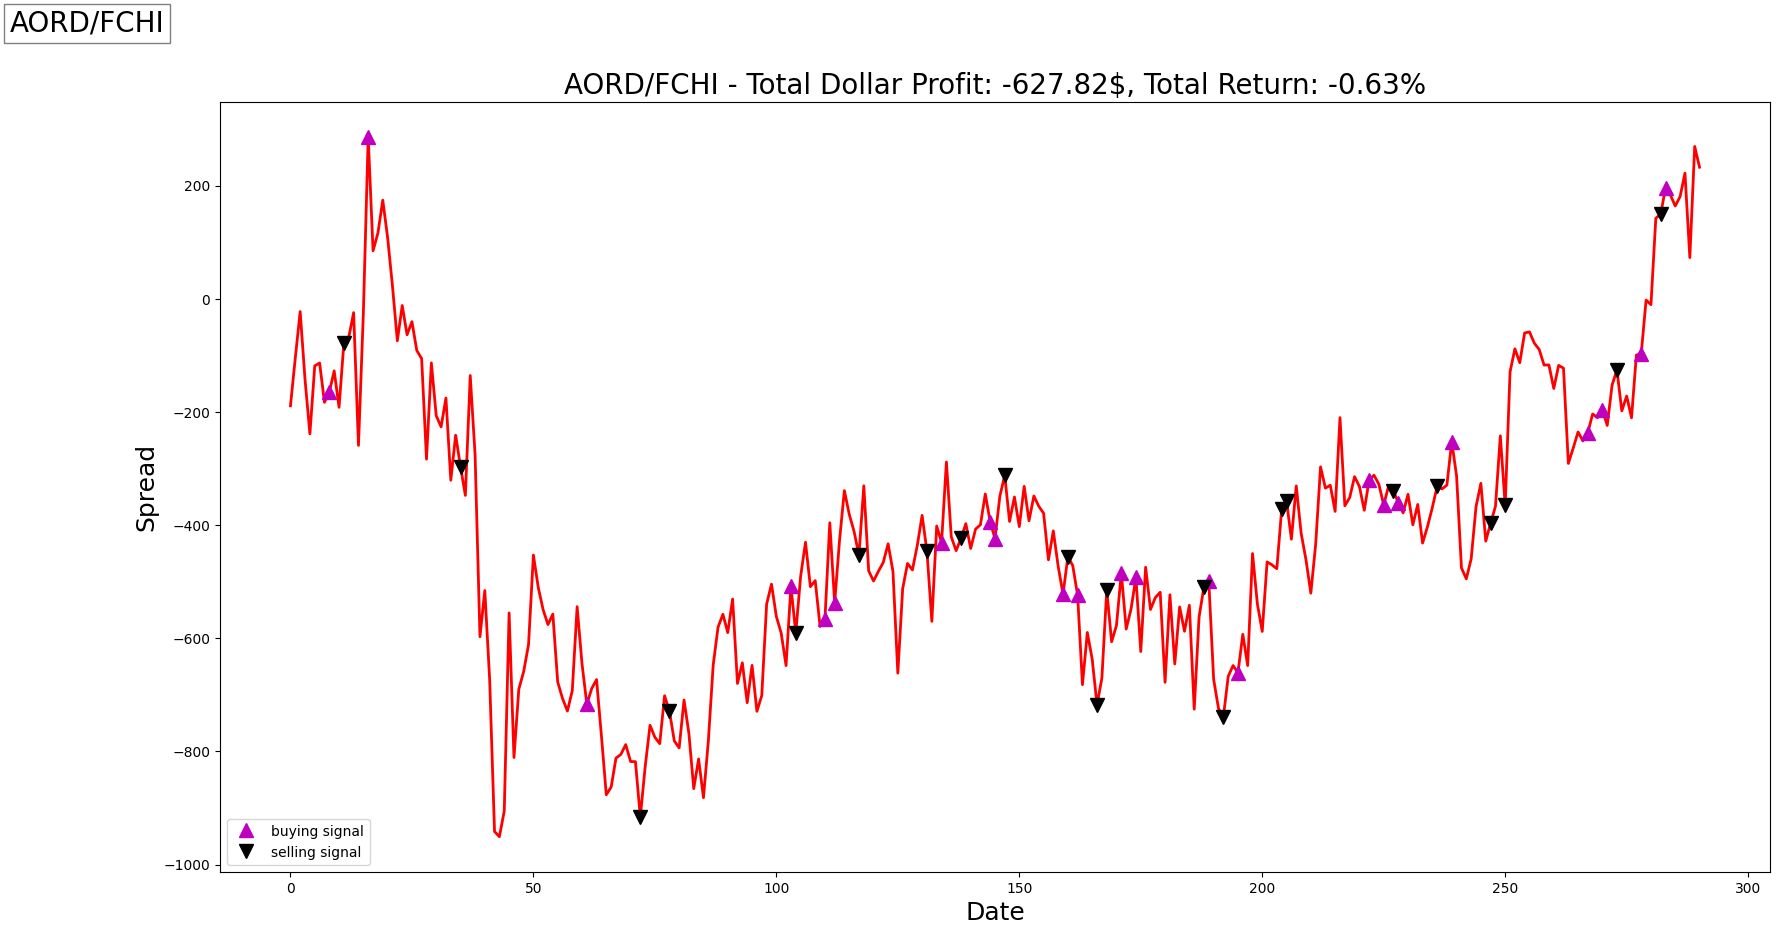

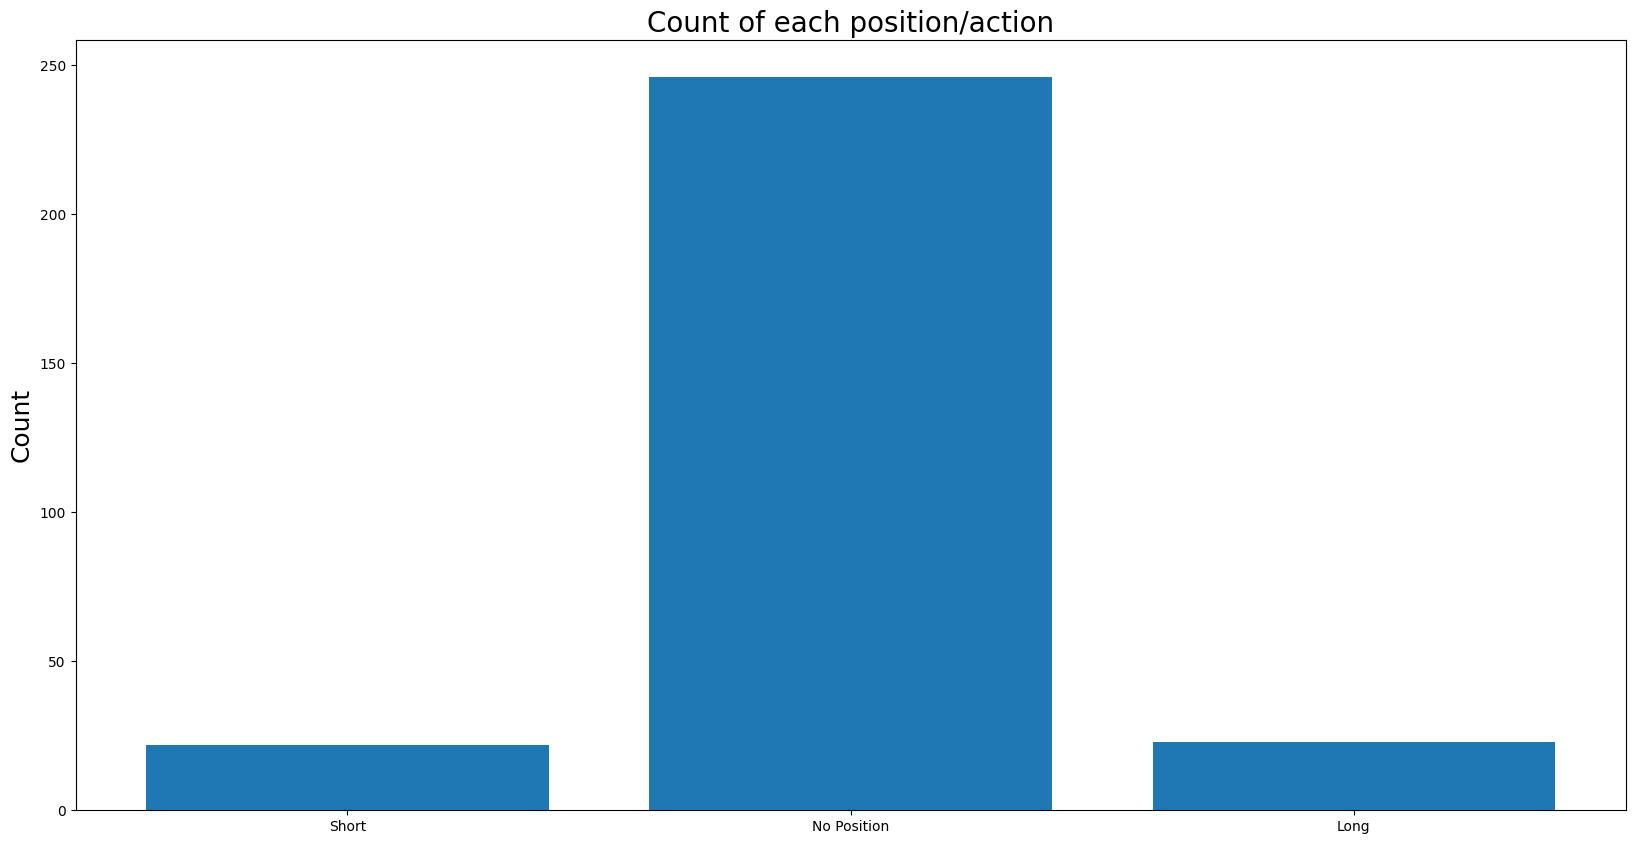

Annual return: -0.0026861466135712814
Annual volatility: 0.012962739448219116
Sharpe ratio: -0.2072205974903181


In [261]:
df_train = pd.read_csv('data/^AORD_^FCHI_train.csv')
df_test = pd.read_csv('data/^AORD_^FCHI_test.csv')

train_test_pair(df_train, df_test, 'AORD', 'FCHI' )

epoch: 20, total rewards: 3575.901367.3, cost: 8378.736580, total money: 103575.901367, The number of taken actions: 25
epoch: 40, total rewards: 3387.601074.3, cost: 2979.757996, total money: 103387.601074, The number of taken actions: 19
epoch: 60, total rewards: 4500.100098.3, cost: 4570.896869, total money: 104500.100098, The number of taken actions: 27
epoch: 80, total rewards: 2528.500000.3, cost: 4133.266427, total money: 102528.500000, The number of taken actions: 7
epoch: 100, total rewards: 3981.500488.3, cost: 1242.385446, total money: 103981.500488, The number of taken actions: 19
day 8: buy 2 sell 1 at difference 149.100098, total balance 100149.100098
day 27: buy 1 sell 2 at difference -443.700195, total balance 99705.399902
day 37: buy 2 sell 1 at difference 491.700195, total balance 100197.100098
day 47: buy 1 sell 2 at difference -92.000000, total balance 100105.100098
day 54: buy 1 sell 2 at difference -135.600098, total balance 99969.500000
day 69: buy 2 sell 1 at di

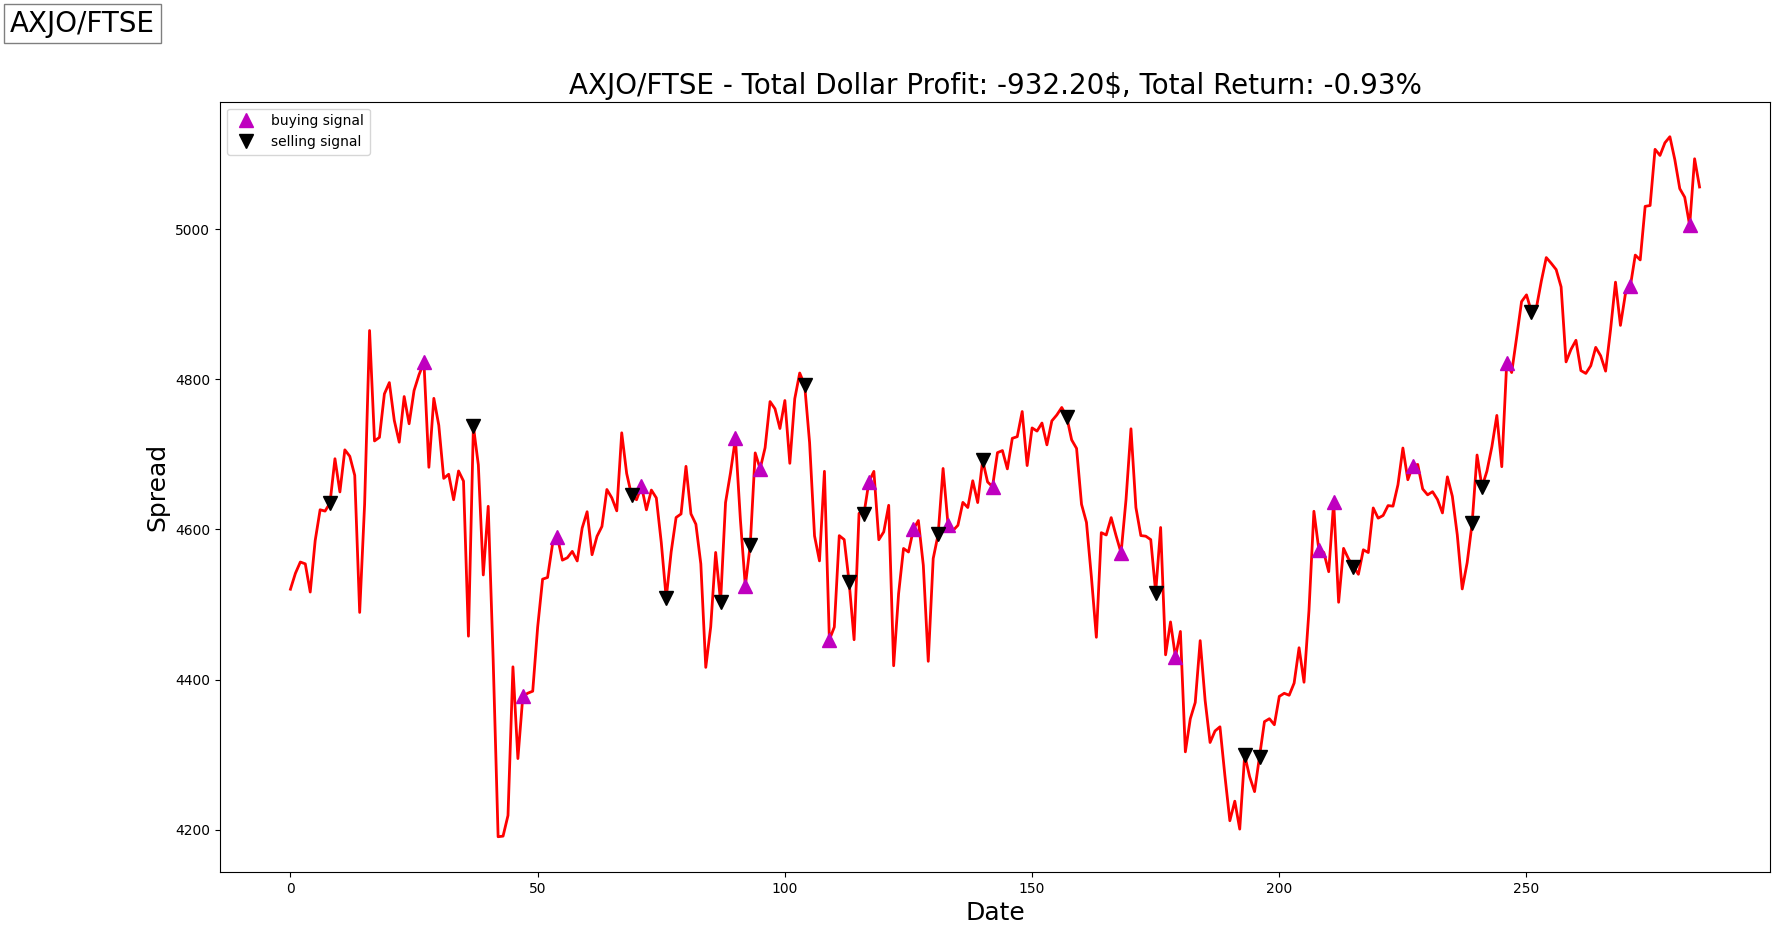

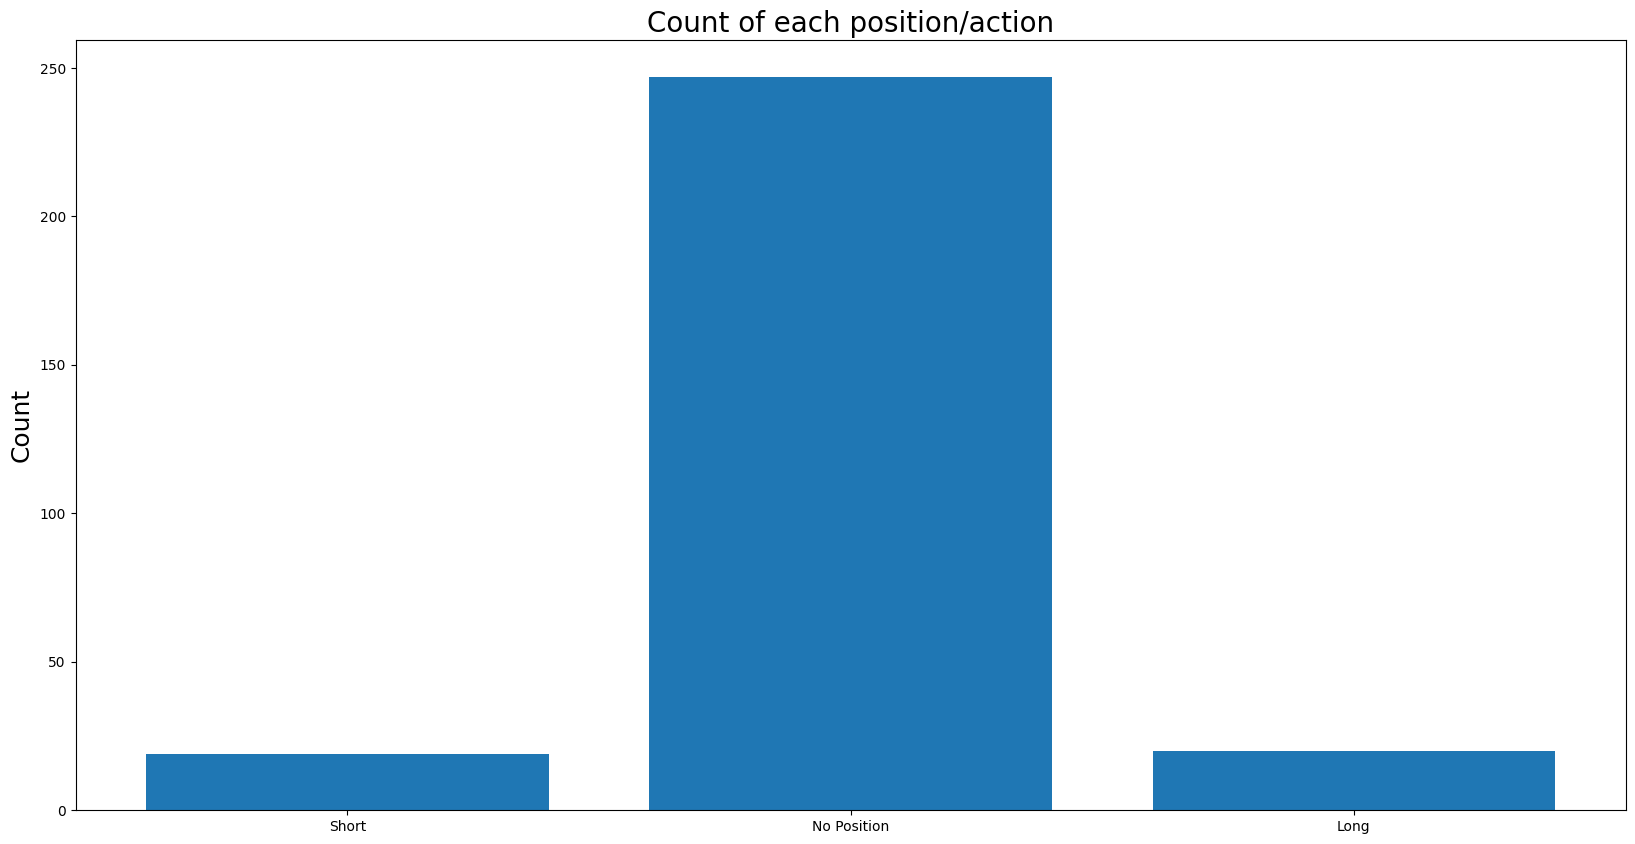

Annual return: -0.005844082115734434
Annual volatility: 0.006432262731017925
Sharpe ratio: -0.9085577440039657


In [260]:
df_train = pd.read_csv('data/^AXJO_^FTSE_train.csv')
df_test = pd.read_csv('data/^AXJO_^FTSE_test.csv')

train_test_pair(df_train, df_test, 'AXJO', 'FTSE' )

epoch: 20, total rewards: 10499.660156.3, cost: 6058.952135, total money: 110499.660156, The number of taken actions: 1
epoch: 40, total rewards: 10477.870117.3, cost: 4958.470366, total money: 110477.870117, The number of taken actions: 1
epoch: 60, total rewards: 10681.599609.3, cost: 8071.024493, total money: 110681.599609, The number of taken actions: 1
epoch: 80, total rewards: 10499.660156.3, cost: 3510.698775, total money: 110499.660156, The number of taken actions: 1
epoch: 100, total rewards: 10433.119141.3, cost: 2583.978795, total money: 110433.119141, The number of taken actions: 1
day 1: buy 2 sell 1 at difference -12219.560547, total balance 87780.439453
day 4: buy 1 sell 2 at difference 10927.941406, total balance 98708.380859
day 9: buy 2 sell 1 at difference -10648.250000, total balance 88060.130859
day 19: buy 1 sell 2 at difference 10629.080078, total balance 98689.210938
day 27: buy 2 sell 1 at difference -10119.359375, total balance 88569.851562
day 28: buy 1 sell 

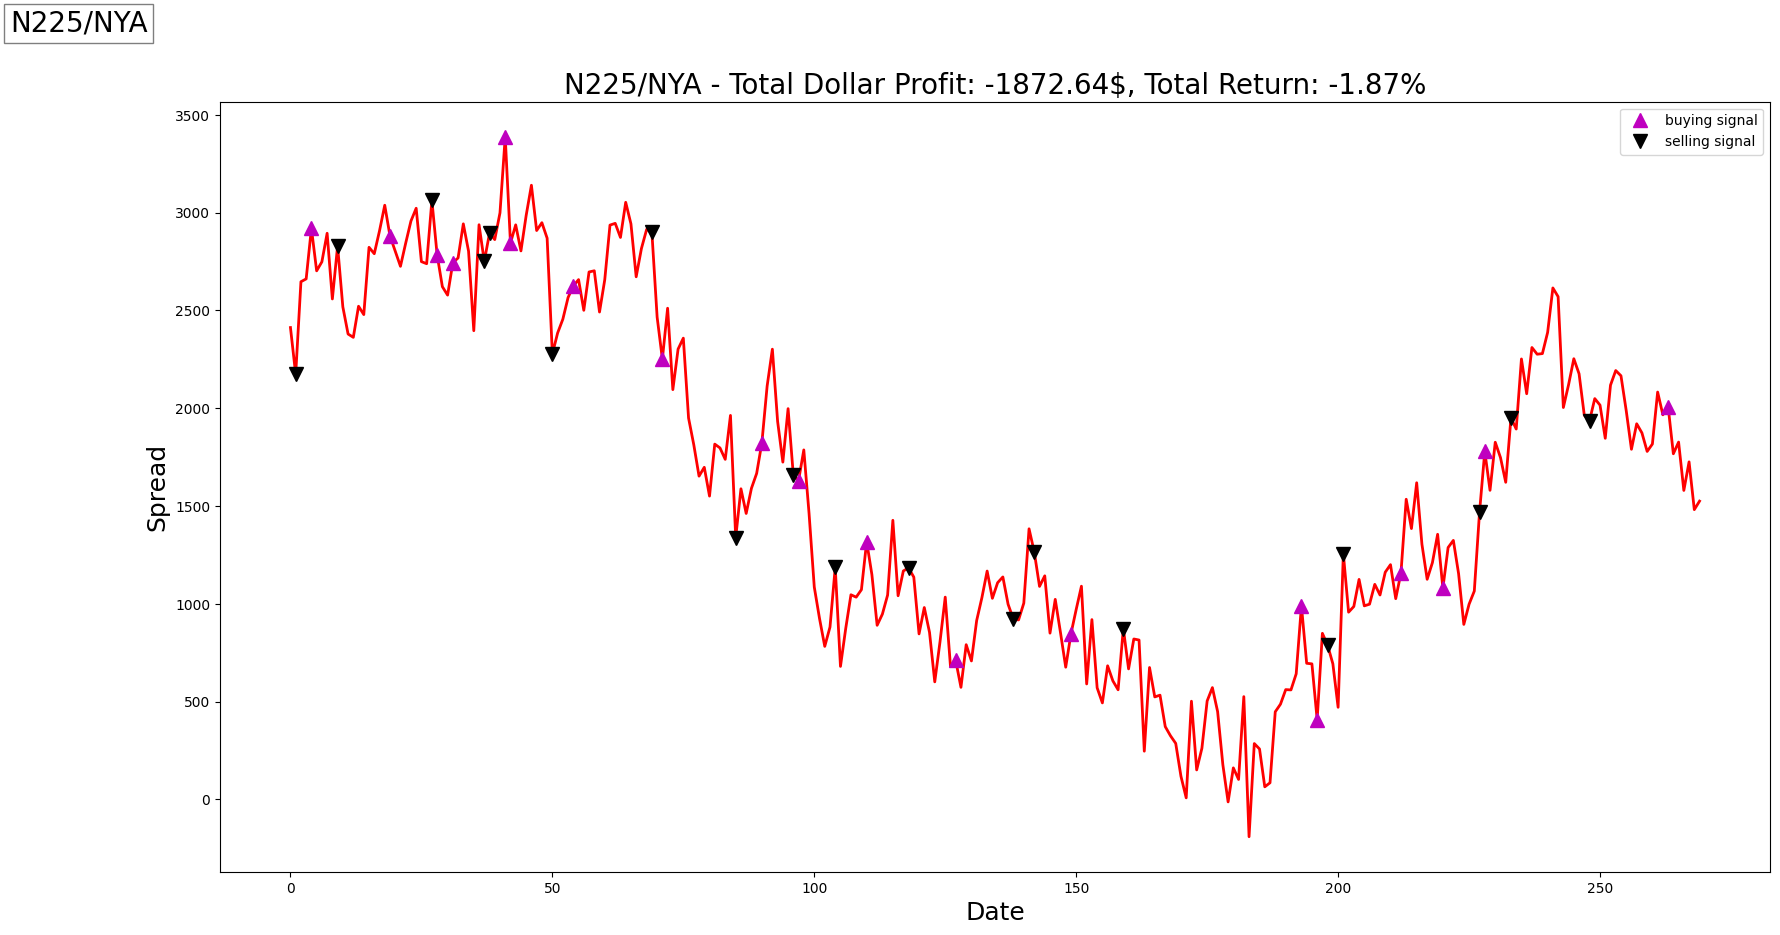

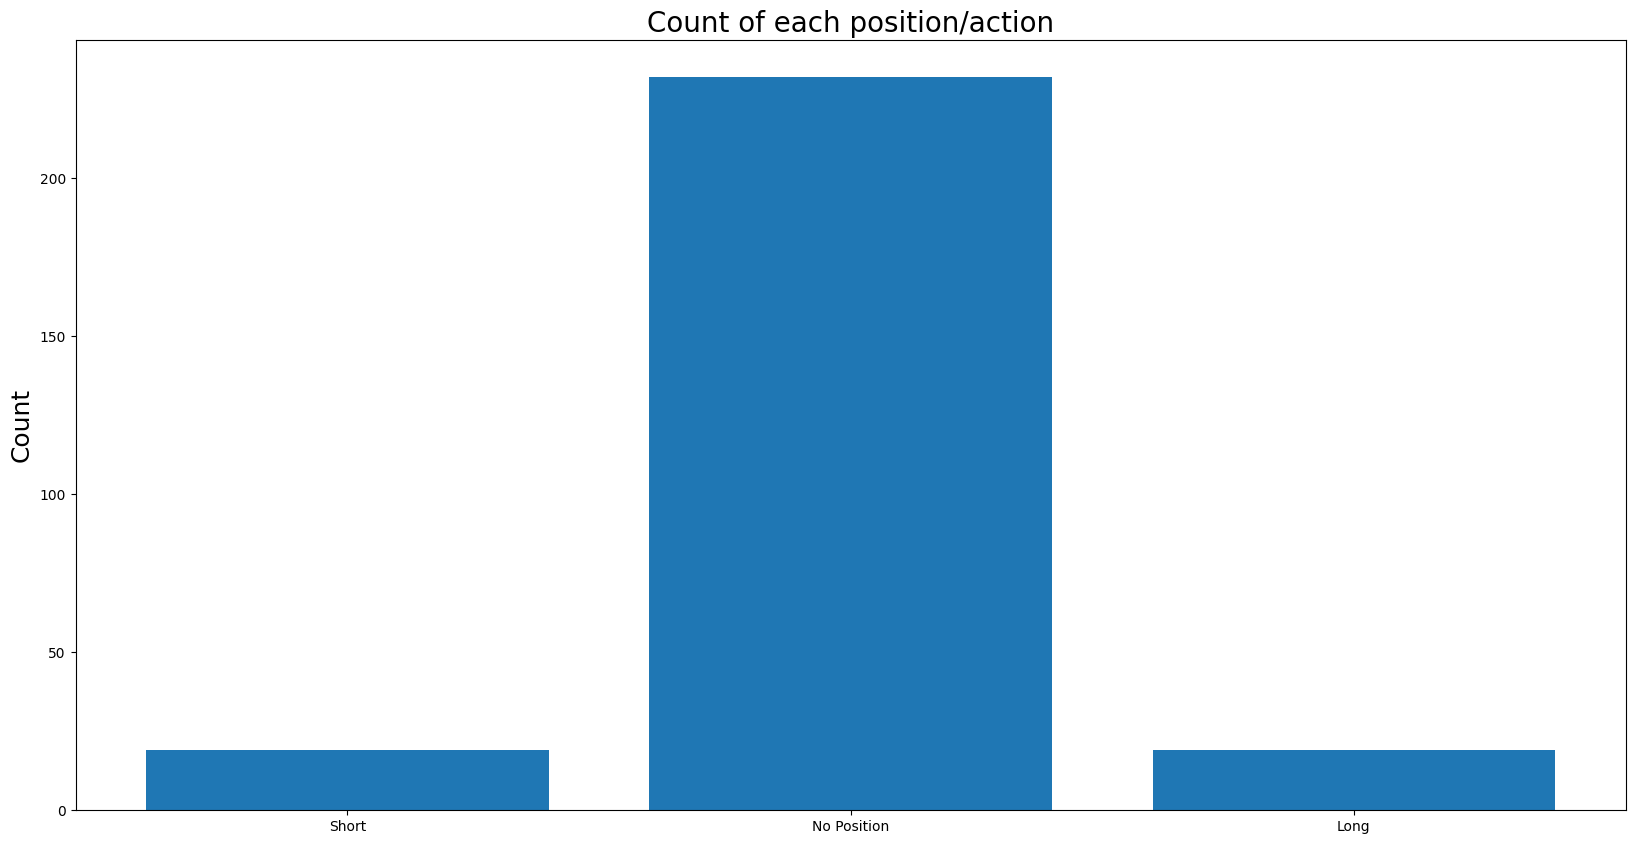

Annual return: 0.16444933593149225
Annual volatility: 0.18849459074900454
Sharpe ratio: 0.8724353058516653


In [259]:
df_train = pd.read_csv('data/^N225_^NYA_train.csv')
df_test = pd.read_csv('data/^N225_^NYA_test.csv')

train_test_pair(df_train, df_test, 'N225', 'NYA')


epoch: 20, total rewards: 2081.769775.3, cost: 2681.683684, total money: 102081.769775, The number of taken actions: 1
epoch: 40, total rewards: 2081.769775.3, cost: 574.677497, total money: 102081.769775, The number of taken actions: 1
epoch: 60, total rewards: 2081.769775.3, cost: 286.922376, total money: 102081.769775, The number of taken actions: 1
epoch: 80, total rewards: 2081.769775.3, cost: 153.834286, total money: 102081.769775, The number of taken actions: 1
epoch: 100, total rewards: 2019.180176.3, cost: 270.973086, total money: 102019.180176, The number of taken actions: 1
day 0: buy 1 sell 2 at difference 3227.589844, total balance 103227.589844
day 7: buy 2 sell 1 at difference -3217.270020, total balance 100010.319824
day 10: buy 1 sell 2 at difference 3188.939941, total balance 103199.259766
day 16: buy 2 sell 1 at difference -2732.849609, total balance 100466.410156
day 19: buy 2 sell 1 at difference -2895.529785, total balance 97570.880371
day 41: buy 1 sell 2 at diff

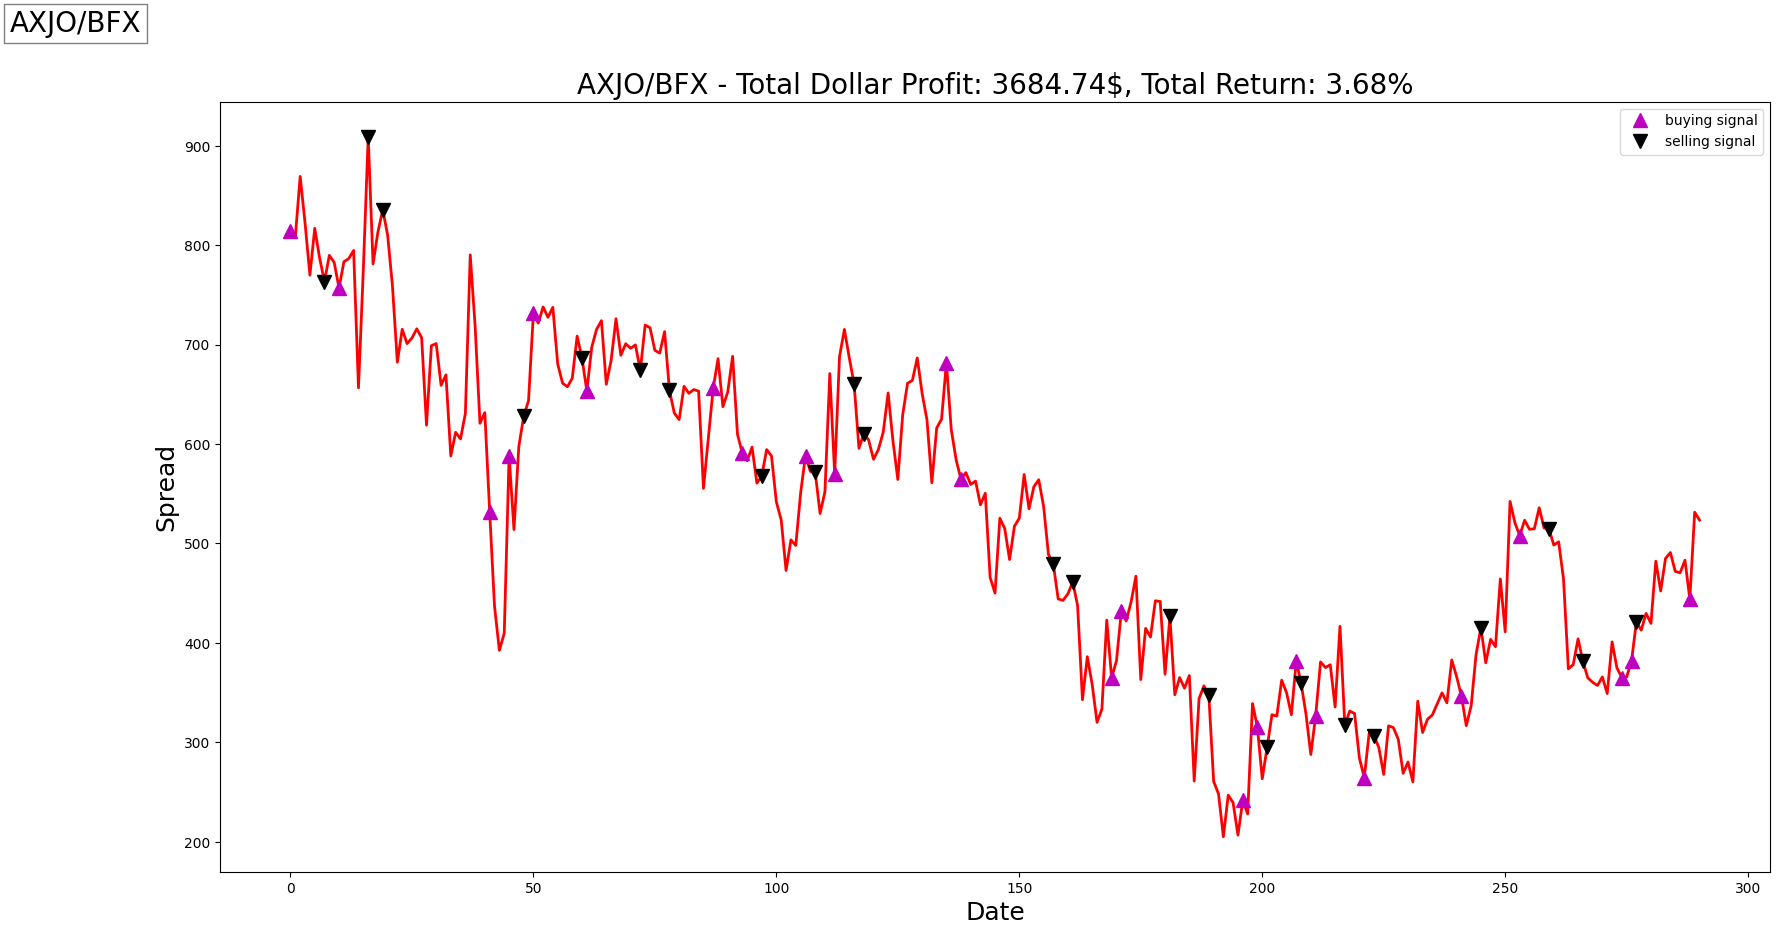

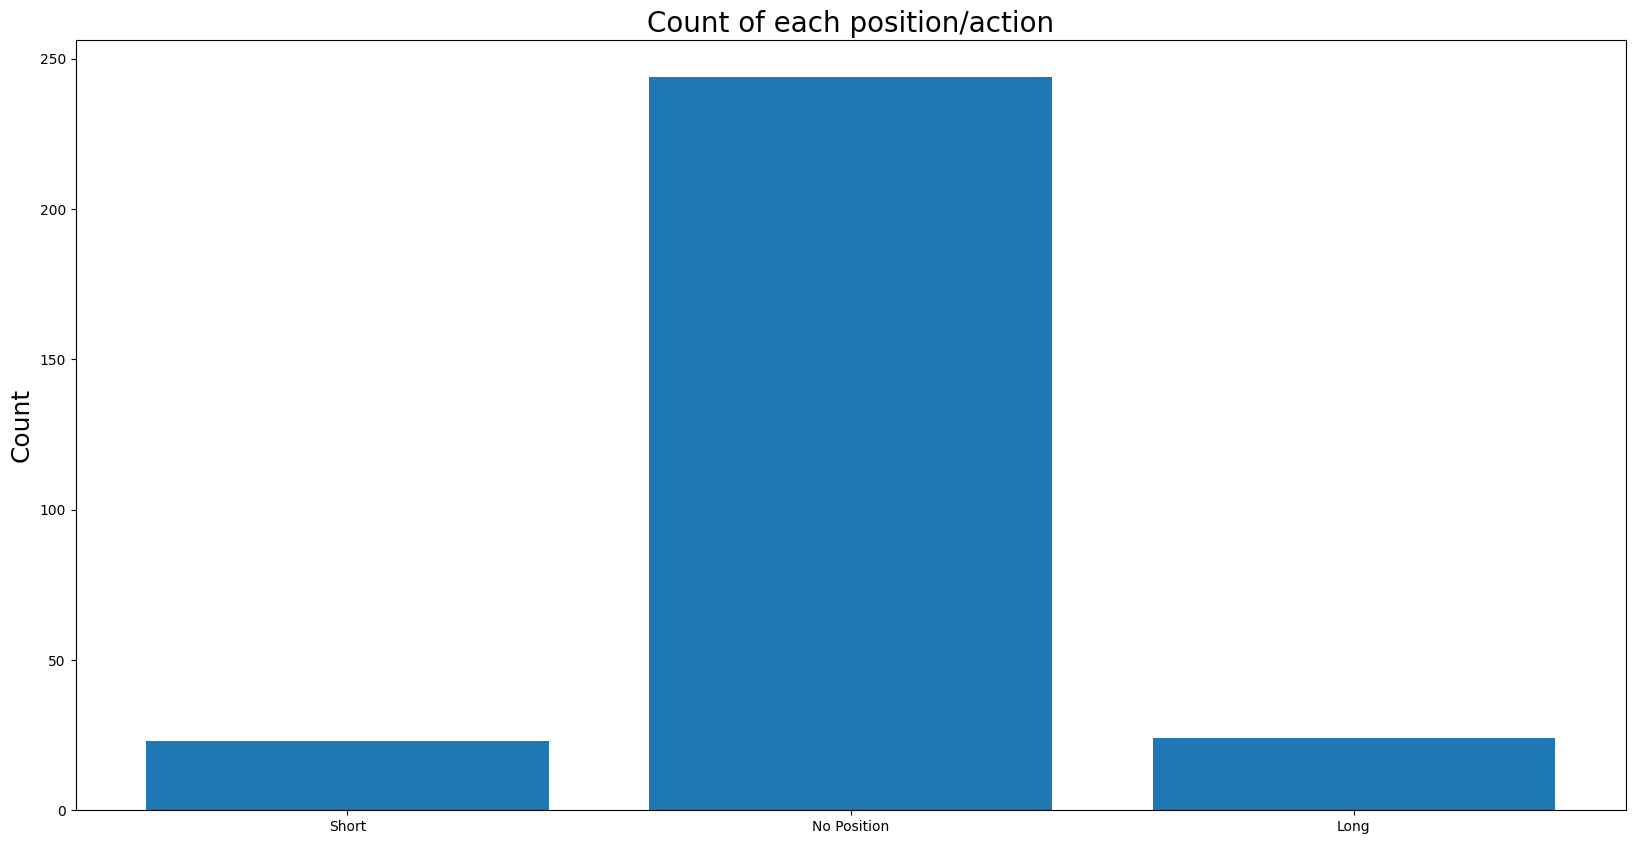

Annual return: 0.032468694023032985
Annual volatility: 0.051110265790419274
Sharpe ratio: 0.6352675635883567


In [244]:
df_train = pd.read_csv('data/^AXJO_^BFX_train.csv')
df_test = pd.read_csv('data/^AXJO_^BFX_test.csv')

train_test_pair(df_train, df_test, 'AXJO', 'BFX')



epoch: 20, total rewards: 3035.350098.3, cost: 13857.043007, total money: 103035.350098, The number of taken actions: 1
epoch: 40, total rewards: 2948.930054.3, cost: 1717.903669, total money: 102948.930054, The number of taken actions: 1
epoch: 60, total rewards: 2948.930054.3, cost: 1926.732636, total money: 102948.930054, The number of taken actions: 1
epoch: 80, total rewards: 2948.930054.3, cost: 430.933104, total money: 102948.930054, The number of taken actions: 1
epoch: 100, total rewards: 3006.339966.3, cost: 215.378281, total money: 103006.339966, The number of taken actions: 1
day 0: buy 2 sell 1 at difference -2963.219727, total balance 97036.780273
day 21: buy 1 sell 2 at difference 2773.280273, total balance 99810.060547
day 22: buy 1 sell 2 at difference 2785.790039, total balance 102595.850586
day 23: buy 2 sell 1 at difference -2753.169922, total balance 99842.680664
day 24: buy 2 sell 1 at difference -2703.989990, total balance 97138.690674
day 38: buy 1 sell 2 at dif

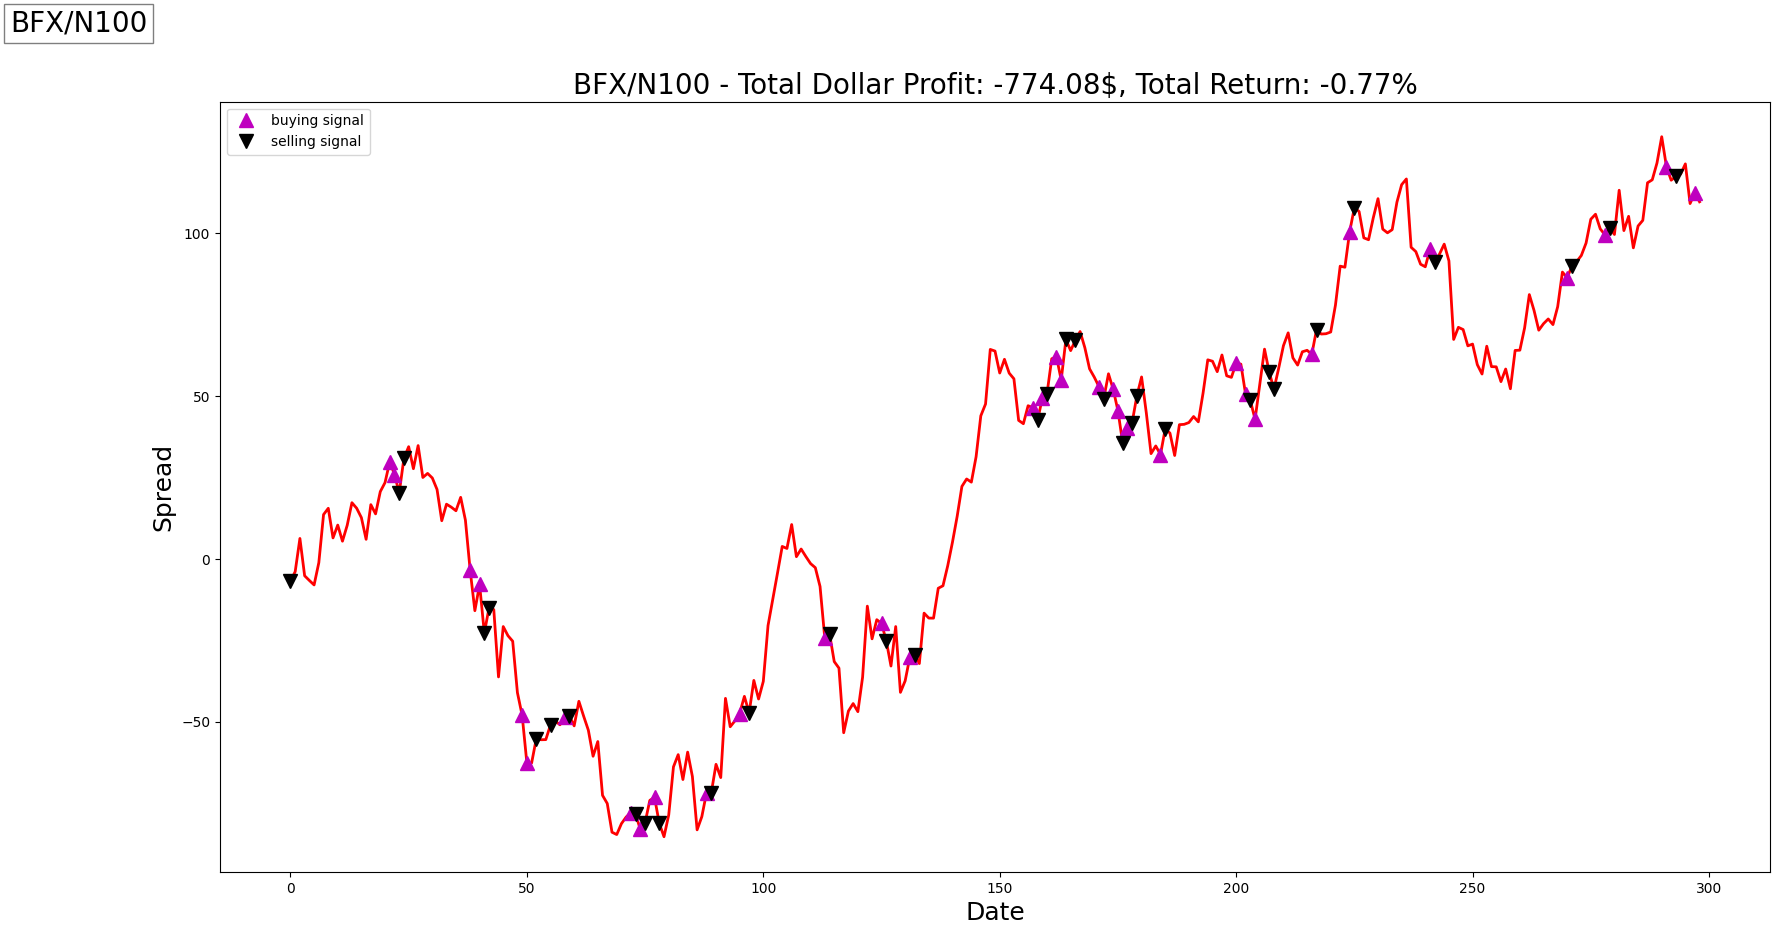

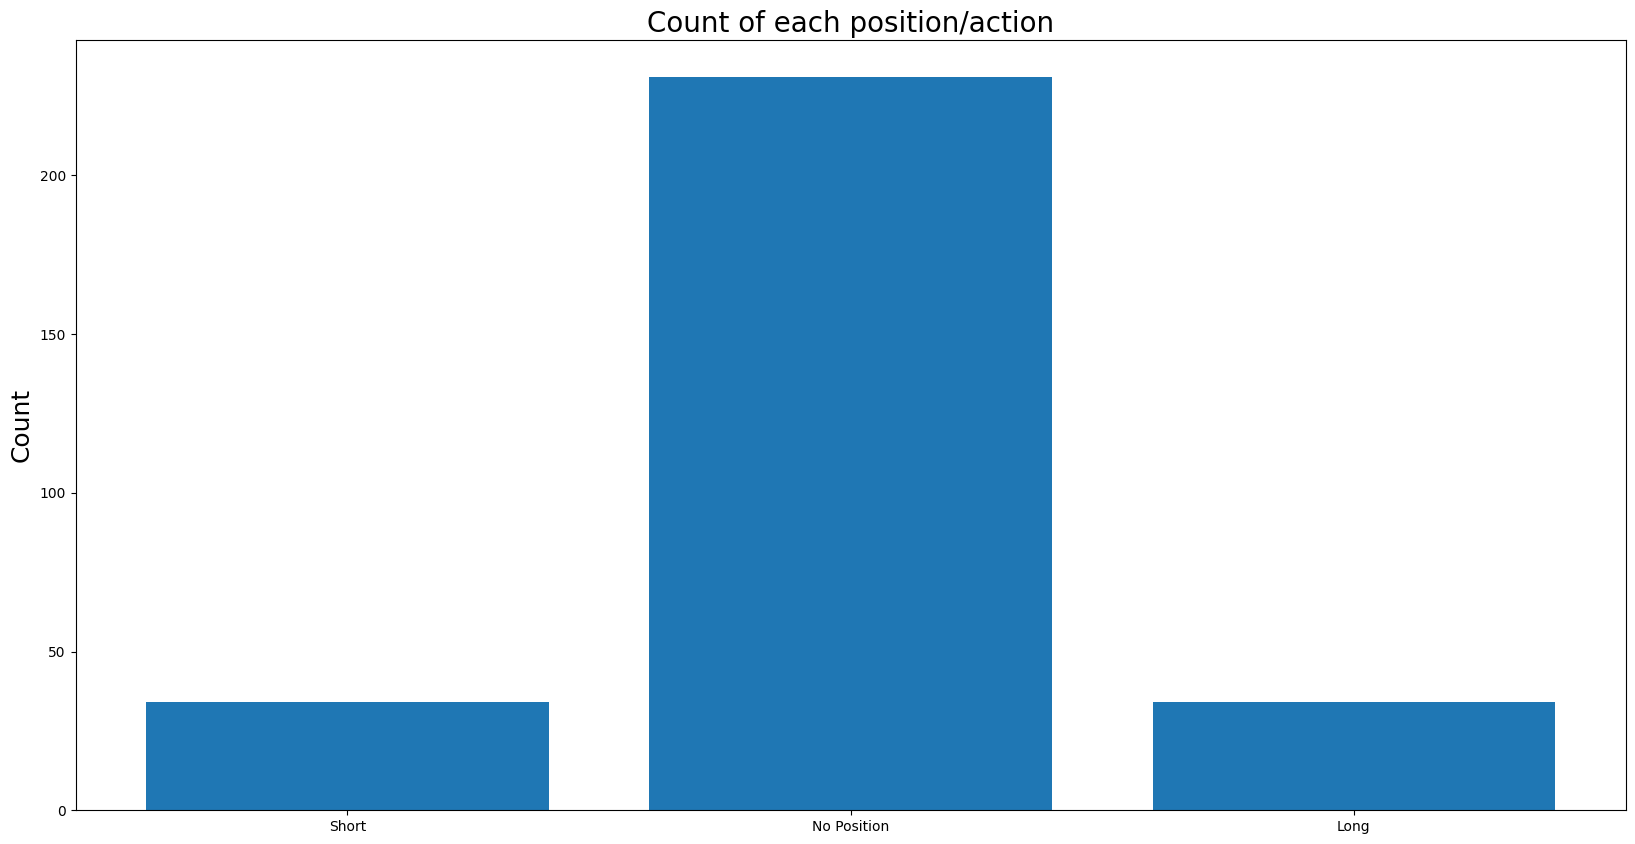

Annual return: 0.005822183407015323
Annual volatility: 0.04171886225699545
Sharpe ratio: 0.1395575788033159


In [245]:
df_train = pd.read_csv('data/^BFX_^N100_train.csv')
df_test = pd.read_csv('data/^BFX_^N100_test.csv')

train_test_pair(df_train, df_test, 'BFX', 'N100')


epoch: 20, total rewards: 1355.770020.3, cost: 15.875039, total money: 101355.770020, The number of taken actions: 1
epoch: 40, total rewards: 1309.070068.3, cost: 4.024772, total money: 101309.070068, The number of taken actions: 1
epoch: 60, total rewards: 1347.130371.3, cost: 3.599369, total money: 101347.130371, The number of taken actions: 1
epoch: 80, total rewards: 1351.239746.3, cost: 1.401663, total money: 101351.239746, The number of taken actions: 1
epoch: 100, total rewards: 1309.070068.3, cost: 0.654290, total money: 101309.070068, The number of taken actions: 1
day 0: buy 2 sell 1 at difference 2881.940430, total balance 102881.940430
day 1: buy 1 sell 2 at difference -2955.200195, total balance 99926.740234
day 3: buy 2 sell 1 at difference 2941.060059, total balance 102867.800293
day 11: buy 1 sell 2 at difference -2913.970215, total balance 99953.830078
day 13: buy 2 sell 1 at difference 2975.680176, total balance 102929.510254
day 21: buy 1 sell 2 at difference -2989.

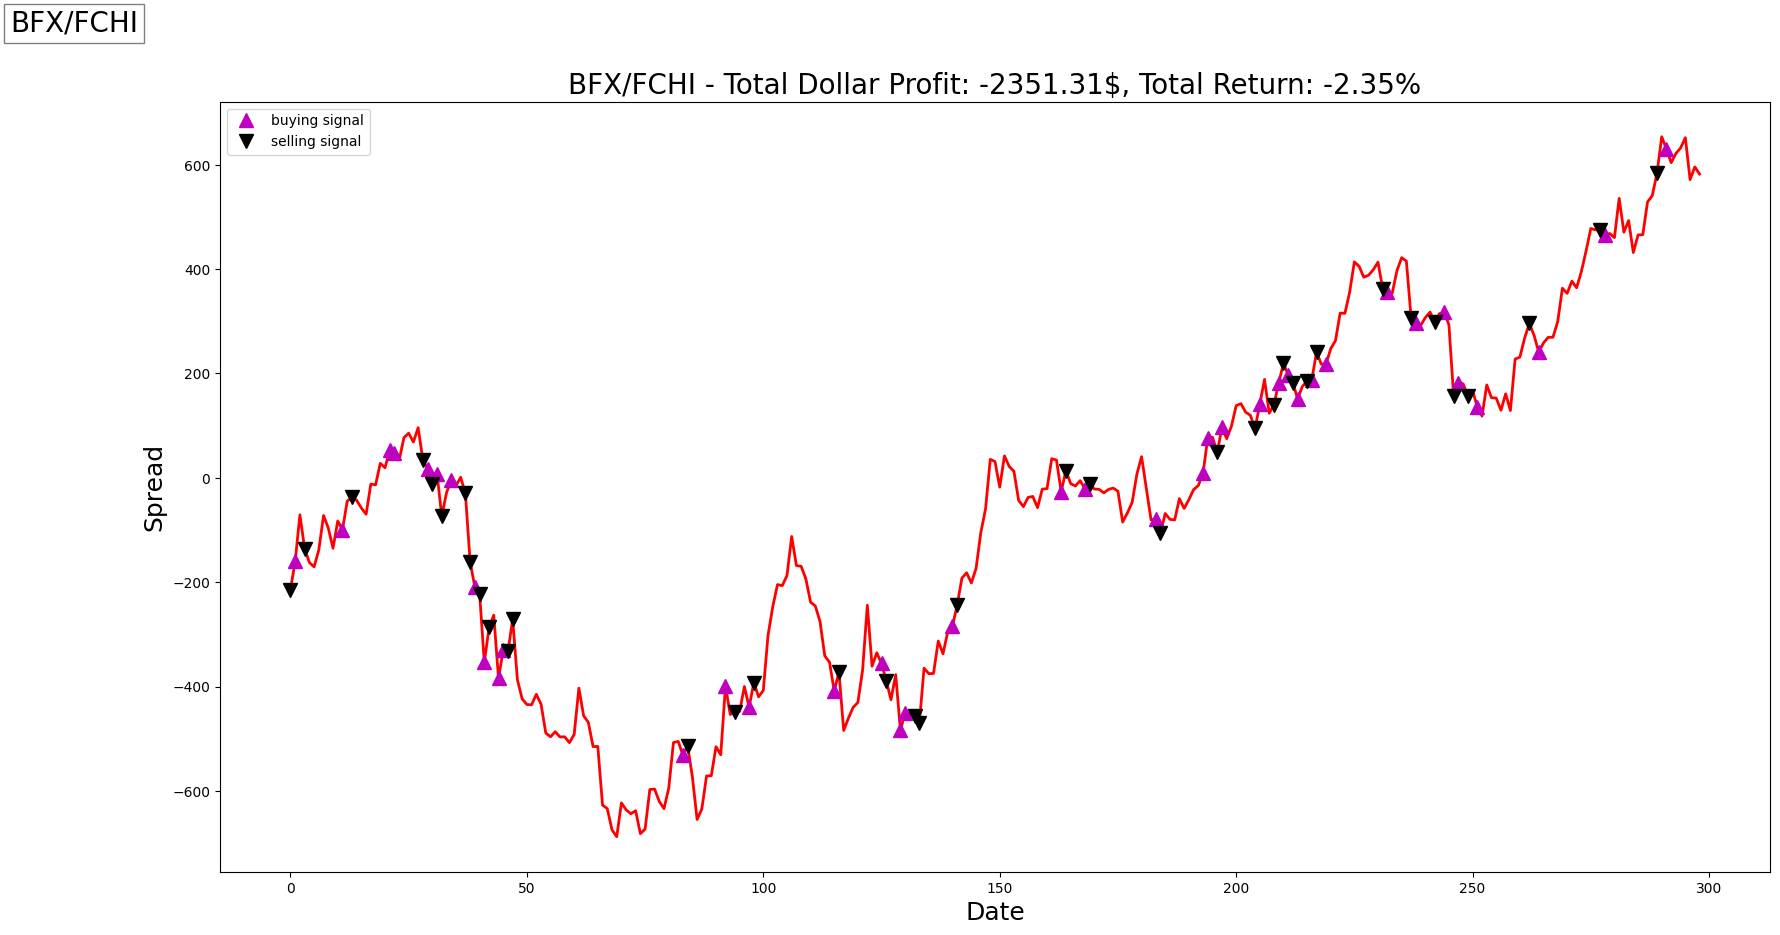

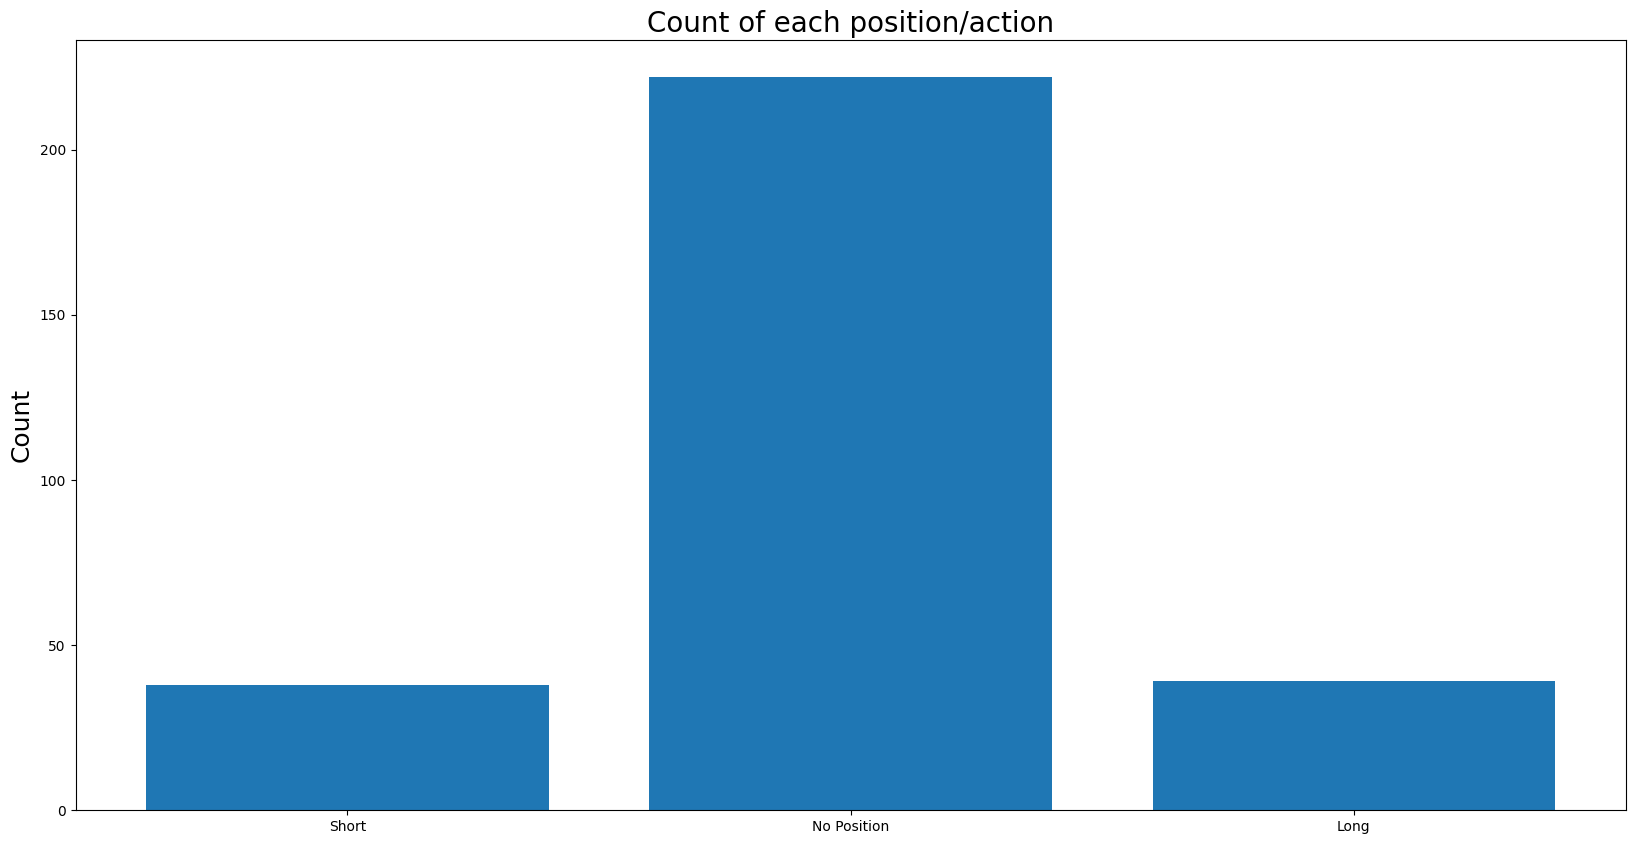

Annual return: 0.0014073745132457418
Annual volatility: 0.042886219873375125
Sharpe ratio: 0.0328164738557309


In [246]:
df_train = pd.read_csv('data/^BFX_^FCHI_train.csv')
df_test = pd.read_csv('data/^BFX_^FCHI_test.csv')

train_test_pair(df_train, df_test, 'BFX', 'FCHI')


epoch: 20, total rewards: 27742.698242.3, cost: 20825122.208008, total money: 127742.698242, The number of taken actions: 1
epoch: 40, total rewards: 25426.500488.3, cost: 3129009.309966, total money: 125426.500488, The number of taken actions: 1
epoch: 60, total rewards: 24918.400391.3, cost: 1781479.681152, total money: 124918.400391, The number of taken actions: 1
epoch: 80, total rewards: 27435.100586.3, cost: 416671.422920, total money: 127435.100586, The number of taken actions: 1
epoch: 100, total rewards: 25301.000977.3, cost: 91780.751579, total money: 125301.000977, The number of taken actions: 1
day 5: buy 1 sell 2 at difference -76991.596680, total balance 23008.403320
day 11: buy 2 sell 1 at difference 75871.603027, total balance 98880.006348
day 14: buy 1 sell 2 at difference -73562.898438, total balance 25317.107910
day 16: buy 2 sell 1 at difference 78854.296875, total balance 104171.404785
day 20: buy 1 sell 2 at difference -82263.103027, total balance 21908.301758
day

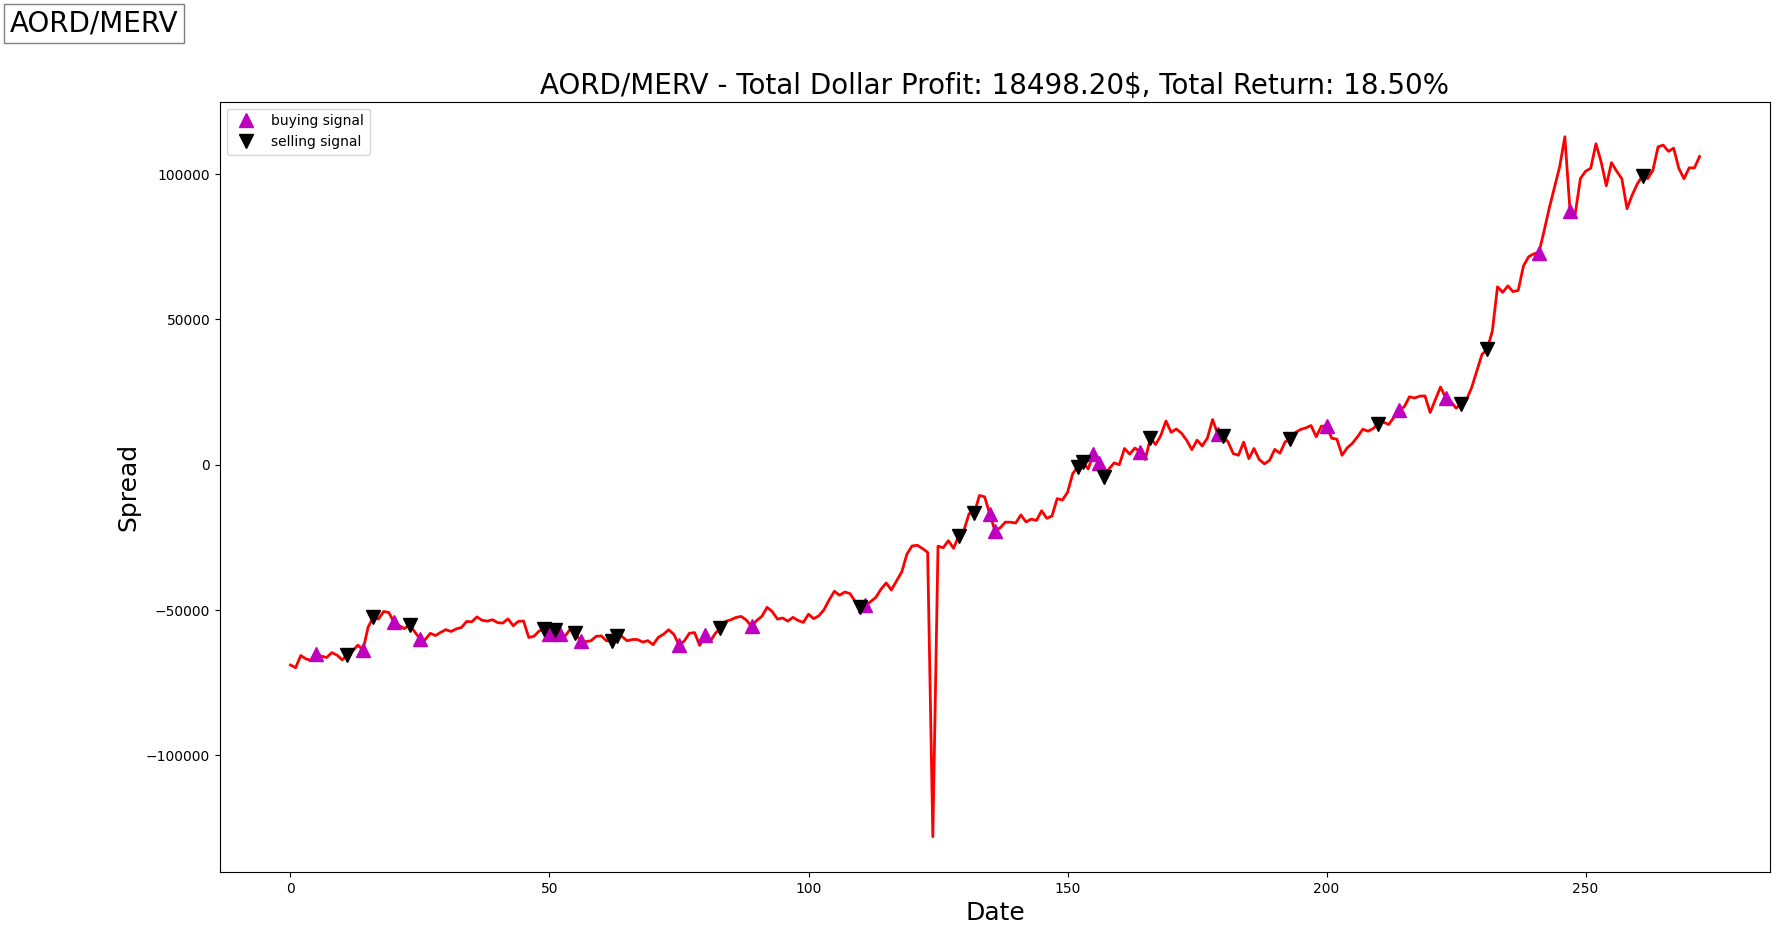

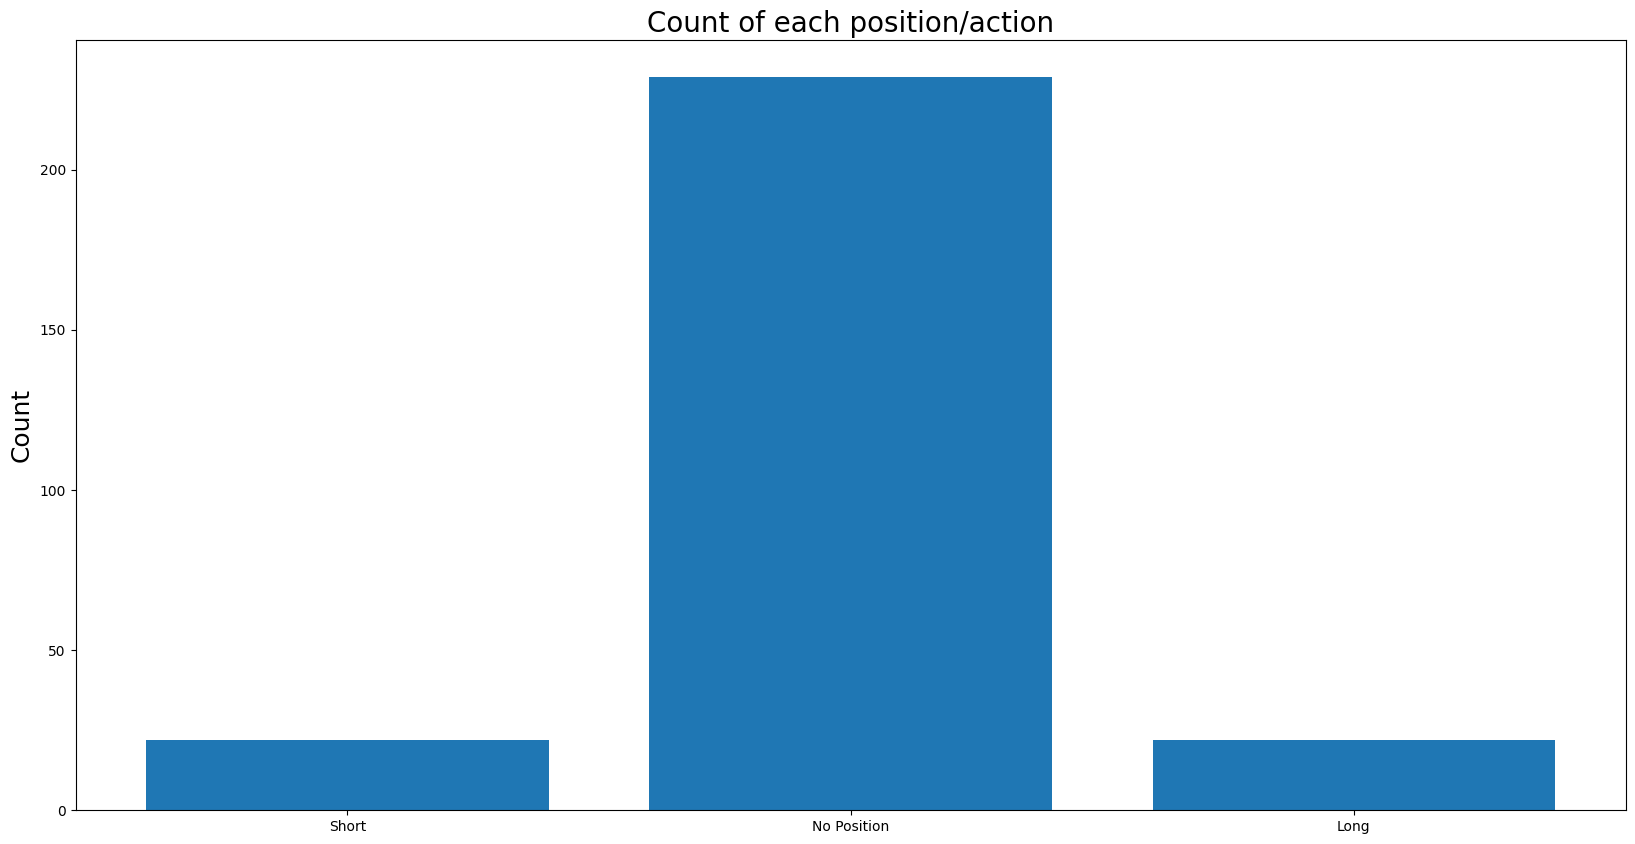

Annual return: 28.297059141414795
Annual volatility: 5.637253622934438
Sharpe ratio: 5.019653369203023


In [247]:
df_train = pd.read_csv('data/^AORD_^MERV_train.csv')
df_test = pd.read_csv('data/^AORD_^MERV_test.csv')

train_test_pair(df_train, df_test, 'AORD', 'MERV')


epoch: 20, total rewards: 17857.149902.3, cost: 126158.026886, total money: 117857.149902, The number of taken actions: 1
epoch: 40, total rewards: 17817.109863.3, cost: 32475.798530, total money: 117817.109863, The number of taken actions: 1
epoch: 60, total rewards: 17817.109863.3, cost: 29152.237136, total money: 117817.109863, The number of taken actions: 1
epoch: 80, total rewards: 17817.109863.3, cost: 44020.219596, total money: 117817.109863, The number of taken actions: 1
epoch: 100, total rewards: 17817.109863.3, cost: 39554.291798, total money: 117817.109863, The number of taken actions: 1
day 0: buy 1 sell 2 at difference 20752.258789, total balance 120752.258789
day 18: buy 2 sell 1 at difference -20954.898438, total balance 99797.360352
day 19: buy 1 sell 2 at difference 20891.979492, total balance 120689.339844
day 28: buy 2 sell 1 at difference -20946.908203, total balance 99742.431641
day 29: buy 1 sell 2 at difference 20775.251953, total balance 120517.683594
day 37: b

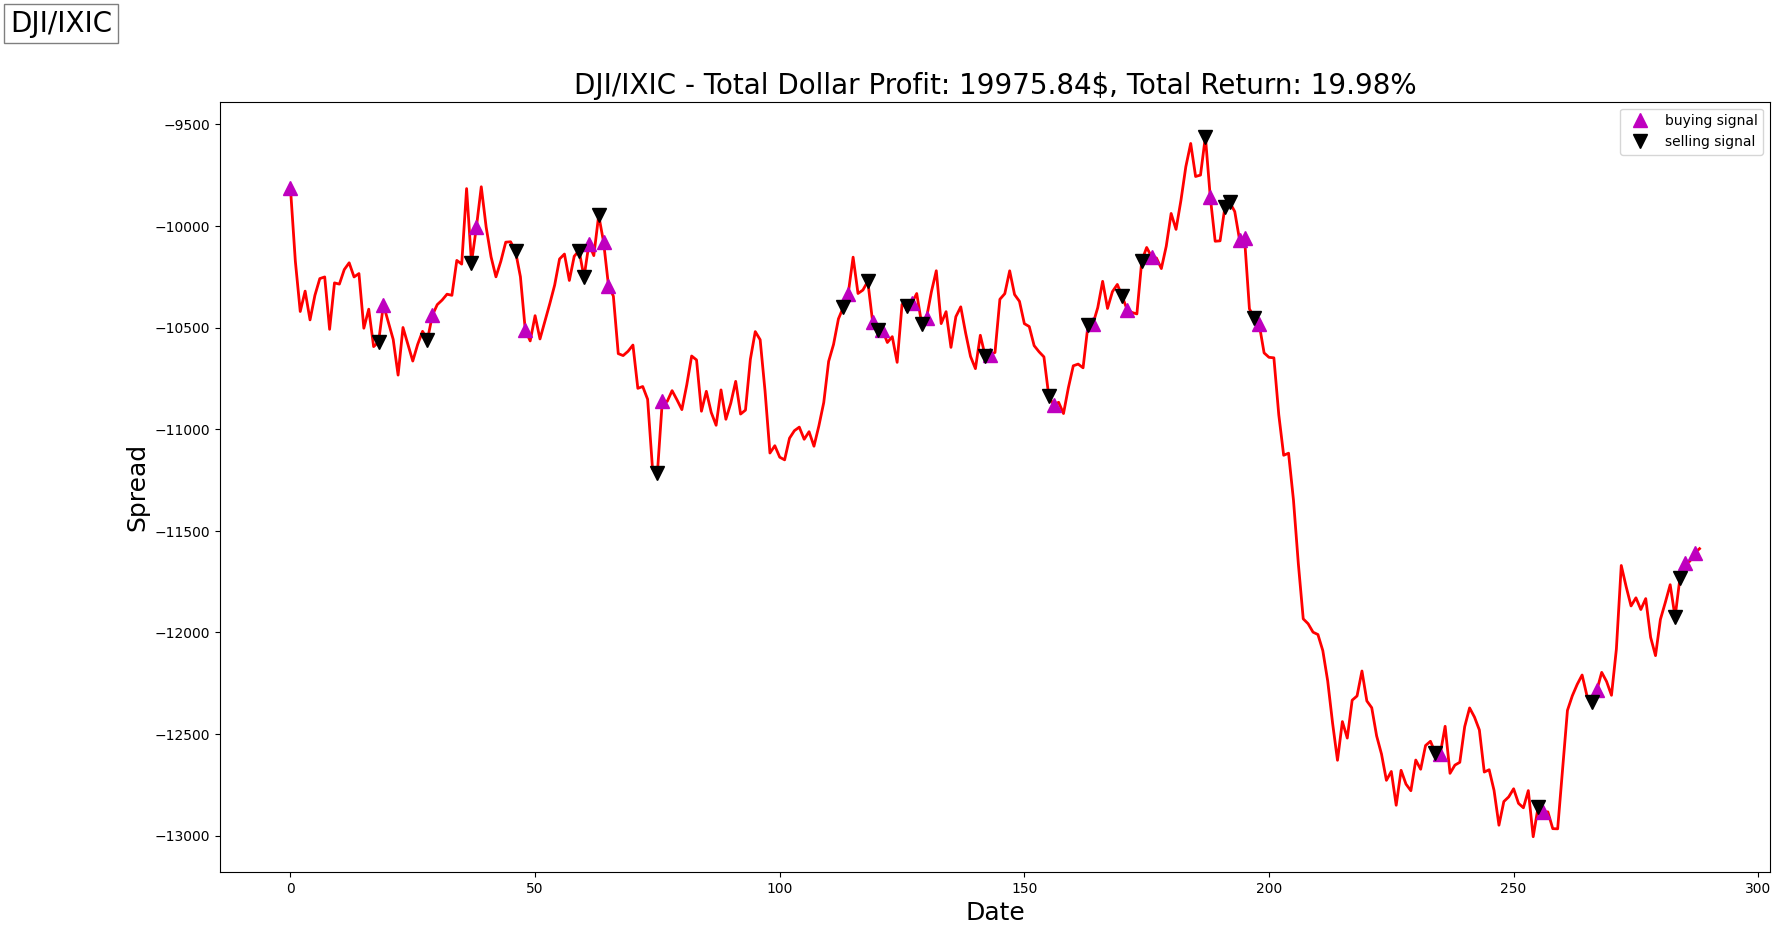

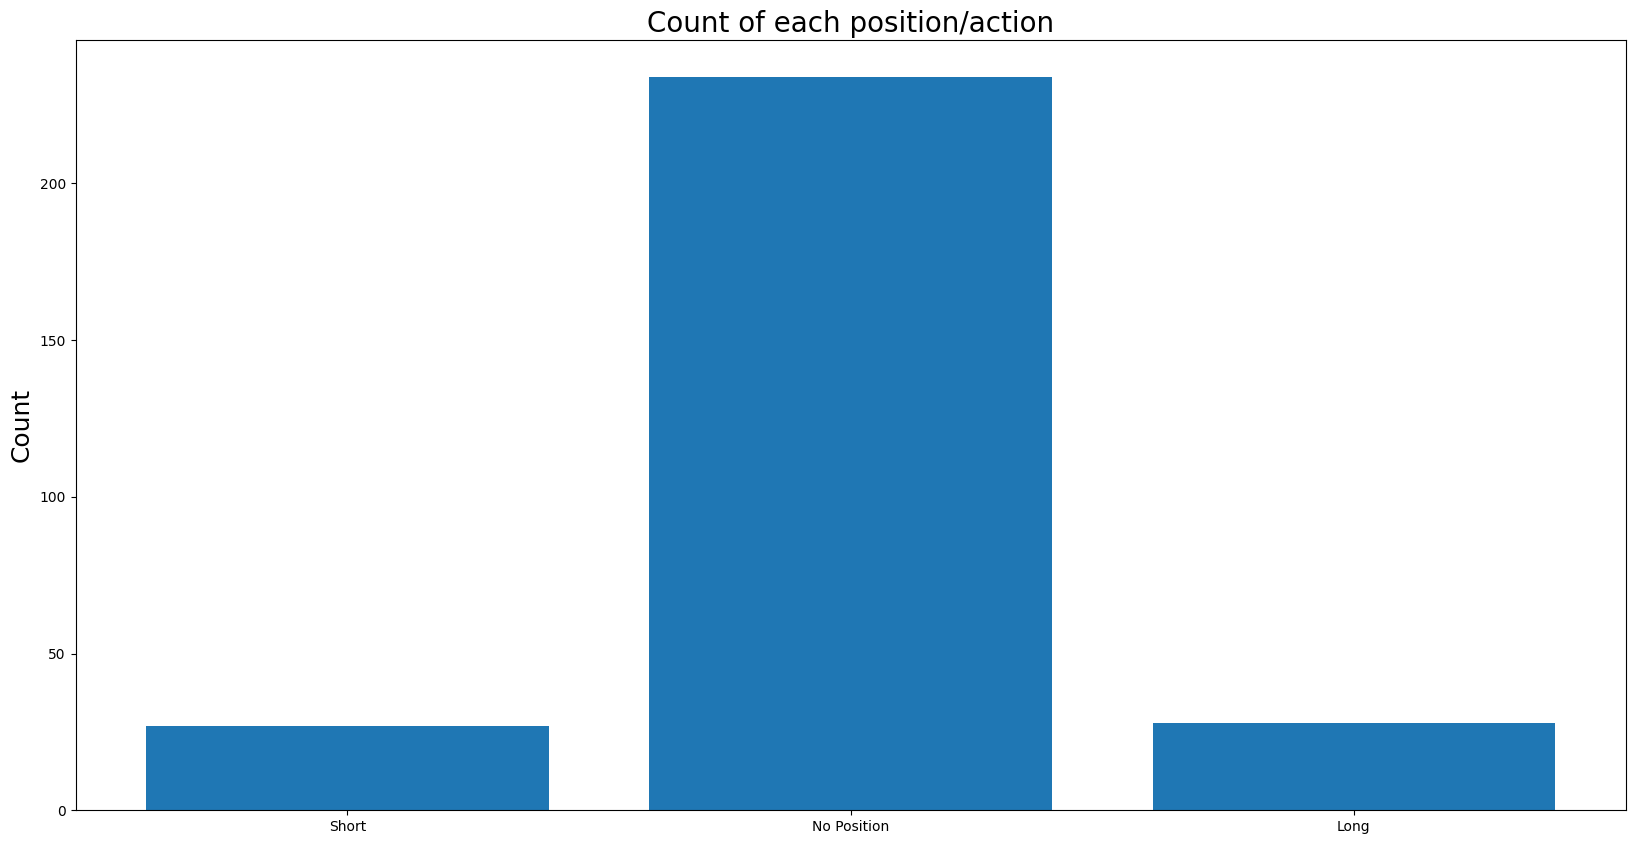

Annual return: 0.5571134652460418
Annual volatility: 0.3090777629096773
Sharpe ratio: 1.8025025805847077


In [248]:
df_train = pd.read_csv('data/^DJI_^IXIC_train.csv')
df_test = pd.read_csv('data/^DJI_^IXIC_test.csv')

train_test_pair(df_train, df_test, 'DJI', 'IXIC')

epoch: 20, total rewards: 4453.149902.3, cost: 459.359894, total money: 104453.149902, The number of taken actions: 1
epoch: 40, total rewards: 4423.399902.3, cost: 305.276696, total money: 104423.399902, The number of taken actions: 1
epoch: 60, total rewards: 4258.000122.3, cost: 273.236331, total money: 104258.000122, The number of taken actions: 1
epoch: 80, total rewards: 4258.000122.3, cost: 612.863683, total money: 104258.000122, The number of taken actions: 1
epoch: 100, total rewards: 4292.969727.3, cost: 884.393474, total money: 104292.969727, The number of taken actions: 1
day 3: buy 2 sell 1 at difference -5884.490112, total balance 94115.509888
day 14: buy 1 sell 2 at difference 5733.499878, total balance 99849.009766
day 15: buy 1 sell 2 at difference 5504.930054, total balance 105353.939819
day 19: buy 2 sell 1 at difference -5657.889893, total balance 99696.049927
day 21: buy 2 sell 1 at difference -5762.300293, total balance 93933.749634
day 25: buy 1 sell 2 at differe

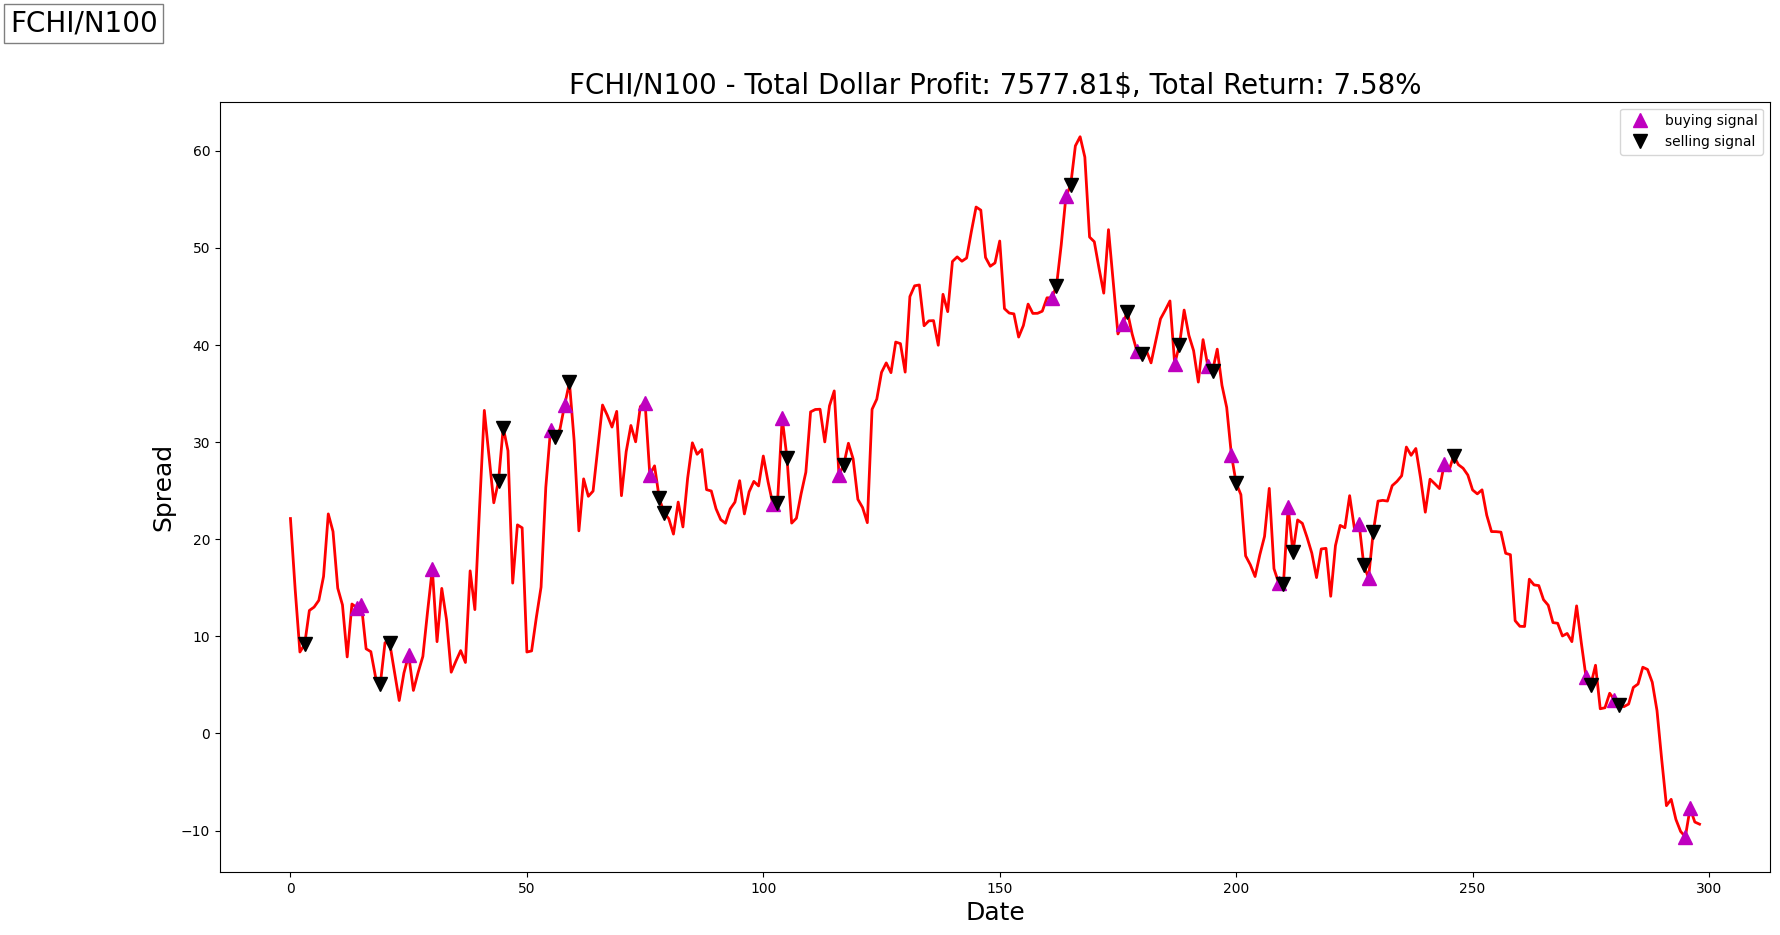

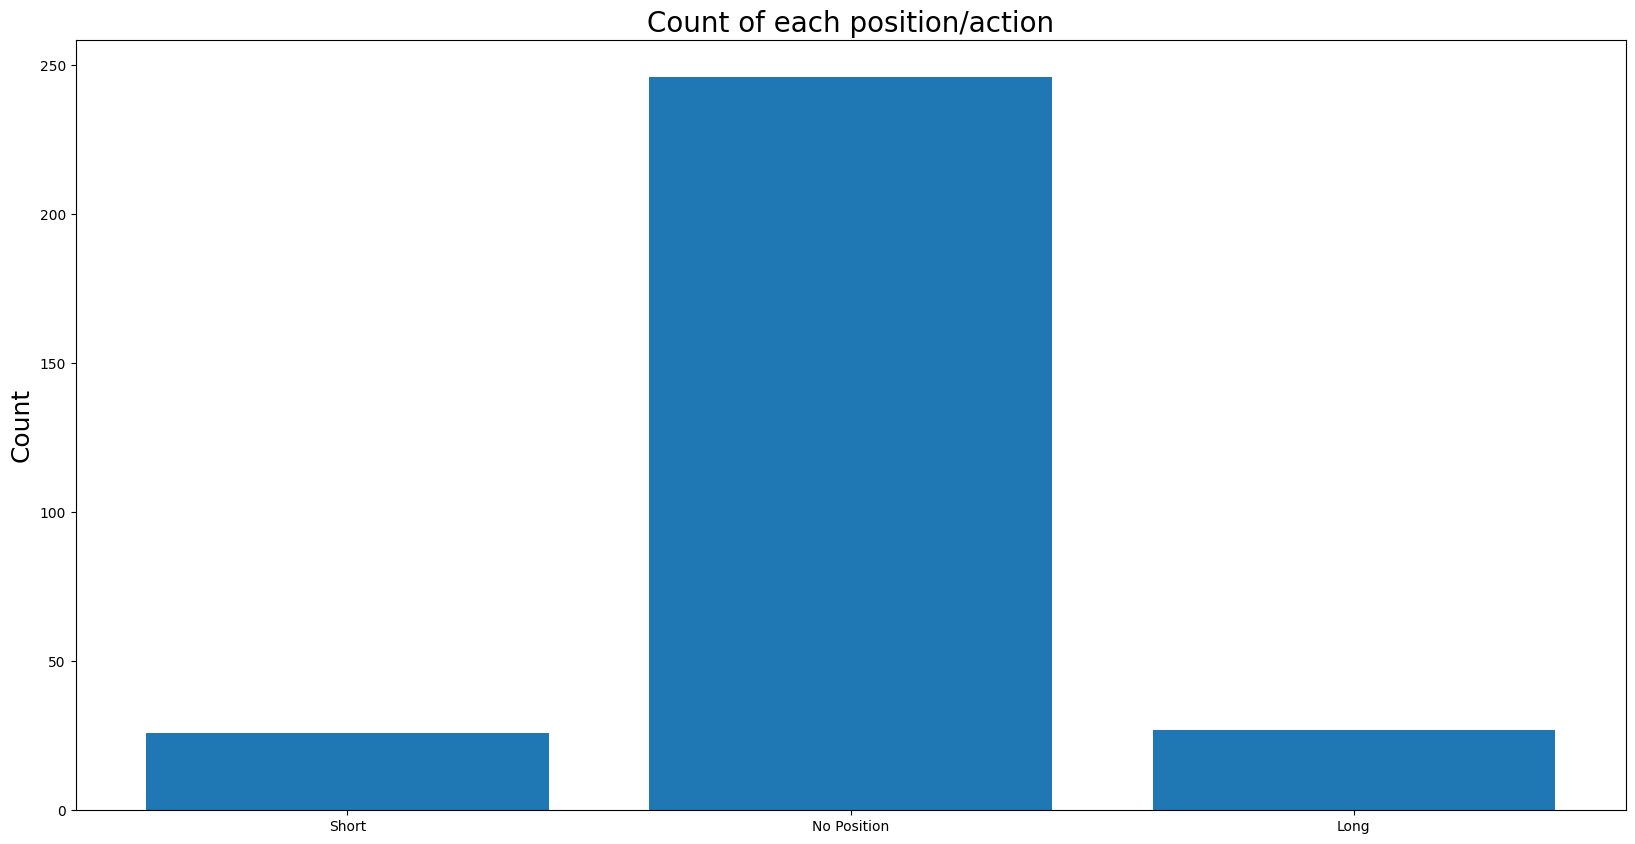

Annual return: 0.07073865814180234
Annual volatility: 0.08486576739423726
Sharpe ratio: 0.8335358332788232


In [249]:
df_train = pd.read_csv('data/^FCHI_^N100_train.csv')
df_test = pd.read_csv('data/^FCHI_^N100_test.csv')

train_test_pair(df_train, df_test, 'FCHI', 'N100')


epoch: 20, total rewards: 25023.100586.3, cost: 294946.101089, total money: 125023.100586, The number of taken actions: 1
epoch: 40, total rewards: 25023.100586.3, cost: 196695.405148, total money: 125023.100586, The number of taken actions: 1
epoch: 60, total rewards: 27582.399414.3, cost: 442004.988716, total money: 127582.399414, The number of taken actions: 1
epoch: 80, total rewards: 25023.100586.3, cost: 338525.023121, total money: 125023.100586, The number of taken actions: 1
epoch: 100, total rewards: 25023.100586.3, cost: 60649.162762, total money: 125023.100586, The number of taken actions: 1
day 0: buy 2 sell 1 at difference 77696.200195, total balance 177696.200195
day 1: buy 1 sell 2 at difference -76269.903320, total balance 101426.296875
day 2: buy 1 sell 2 at difference -76389.497070, total balance 25036.799805
day 5: buy 2 sell 1 at difference 77312.196777, total balance 102348.996582
day 6: buy 1 sell 2 at difference -77661.396973, total balance 24687.599609
day 8: bu

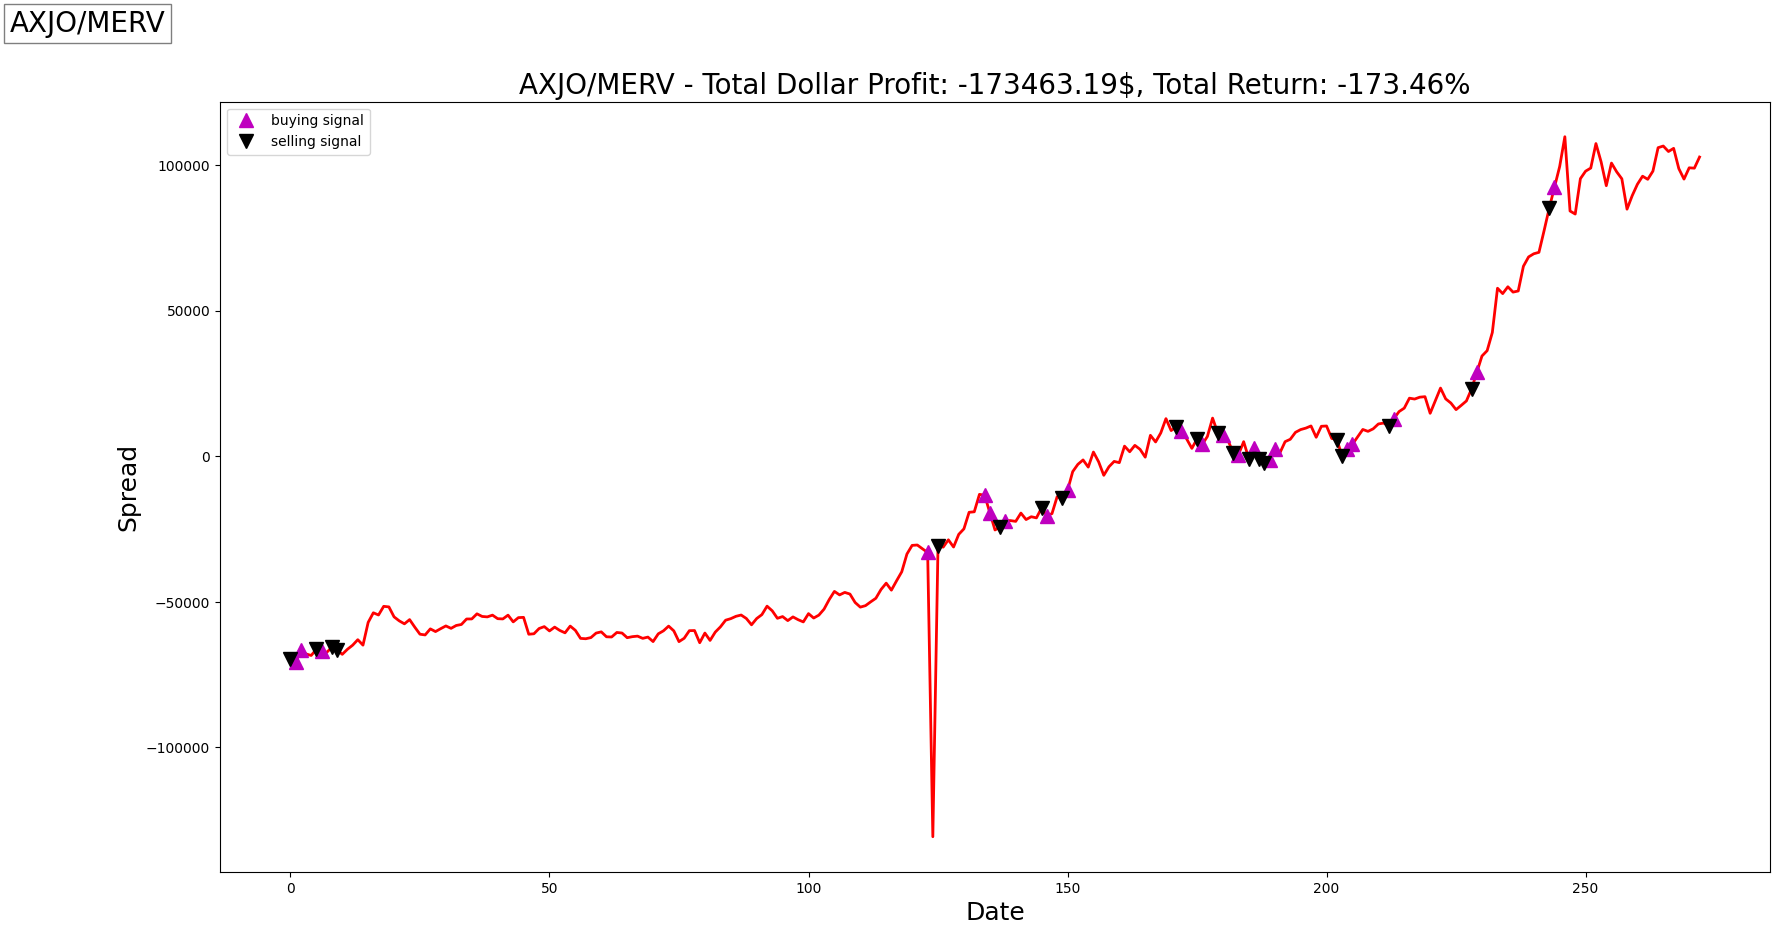

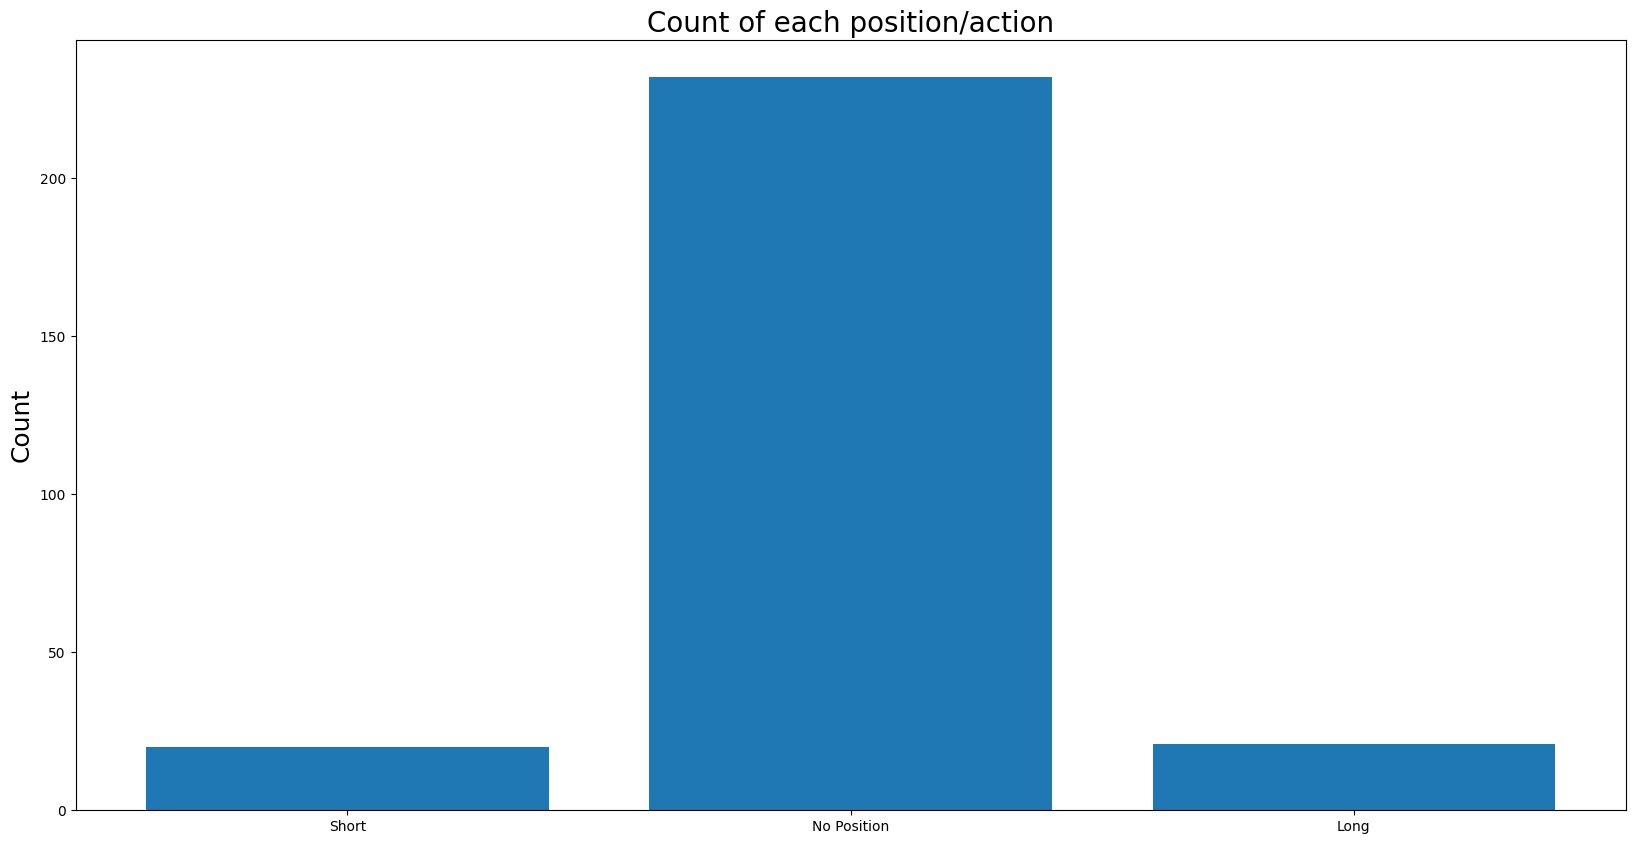

Annual return: -30.034898555282968
Annual volatility: 2.443157132653572
Sharpe ratio: -12.293478038664398


In [258]:
df_train = pd.read_csv('data/^AXJO_^MERV_train.csv')
df_test = pd.read_csv('data/^AXJO_^MERV_test.csv')

train_test_pair(df_train, df_test, 'AXJO', 'MERV')

epoch: 20, total rewards: 22128.199707.3, cost: 18335.506592, total money: 122128.199707, The number of taken actions: 1
epoch: 40, total rewards: 22535.290039.3, cost: 7696.763508, total money: 122535.290039, The number of taken actions: 1
epoch: 60, total rewards: 22128.199707.3, cost: 42033.073574, total money: 122128.199707, The number of taken actions: 1
epoch: 80, total rewards: 22096.449219.3, cost: 38259.179241, total money: 122096.449219, The number of taken actions: 1
epoch: 100, total rewards: 22209.619629.3, cost: 24601.323181, total money: 122209.619629, The number of taken actions: 1
day 2: buy 1 sell 2 at difference 31706.529297, total balance 131706.529297
day 5: buy 2 sell 1 at difference -31398.581055, total balance 100307.948242
day 6: buy 1 sell 2 at difference 31538.949707, total balance 131846.897949
day 9: buy 2 sell 1 at difference -31248.958496, total balance 100597.939453
day 11: buy 2 sell 1 at difference -30495.888672, total balance 70102.050781
day 21: buy 

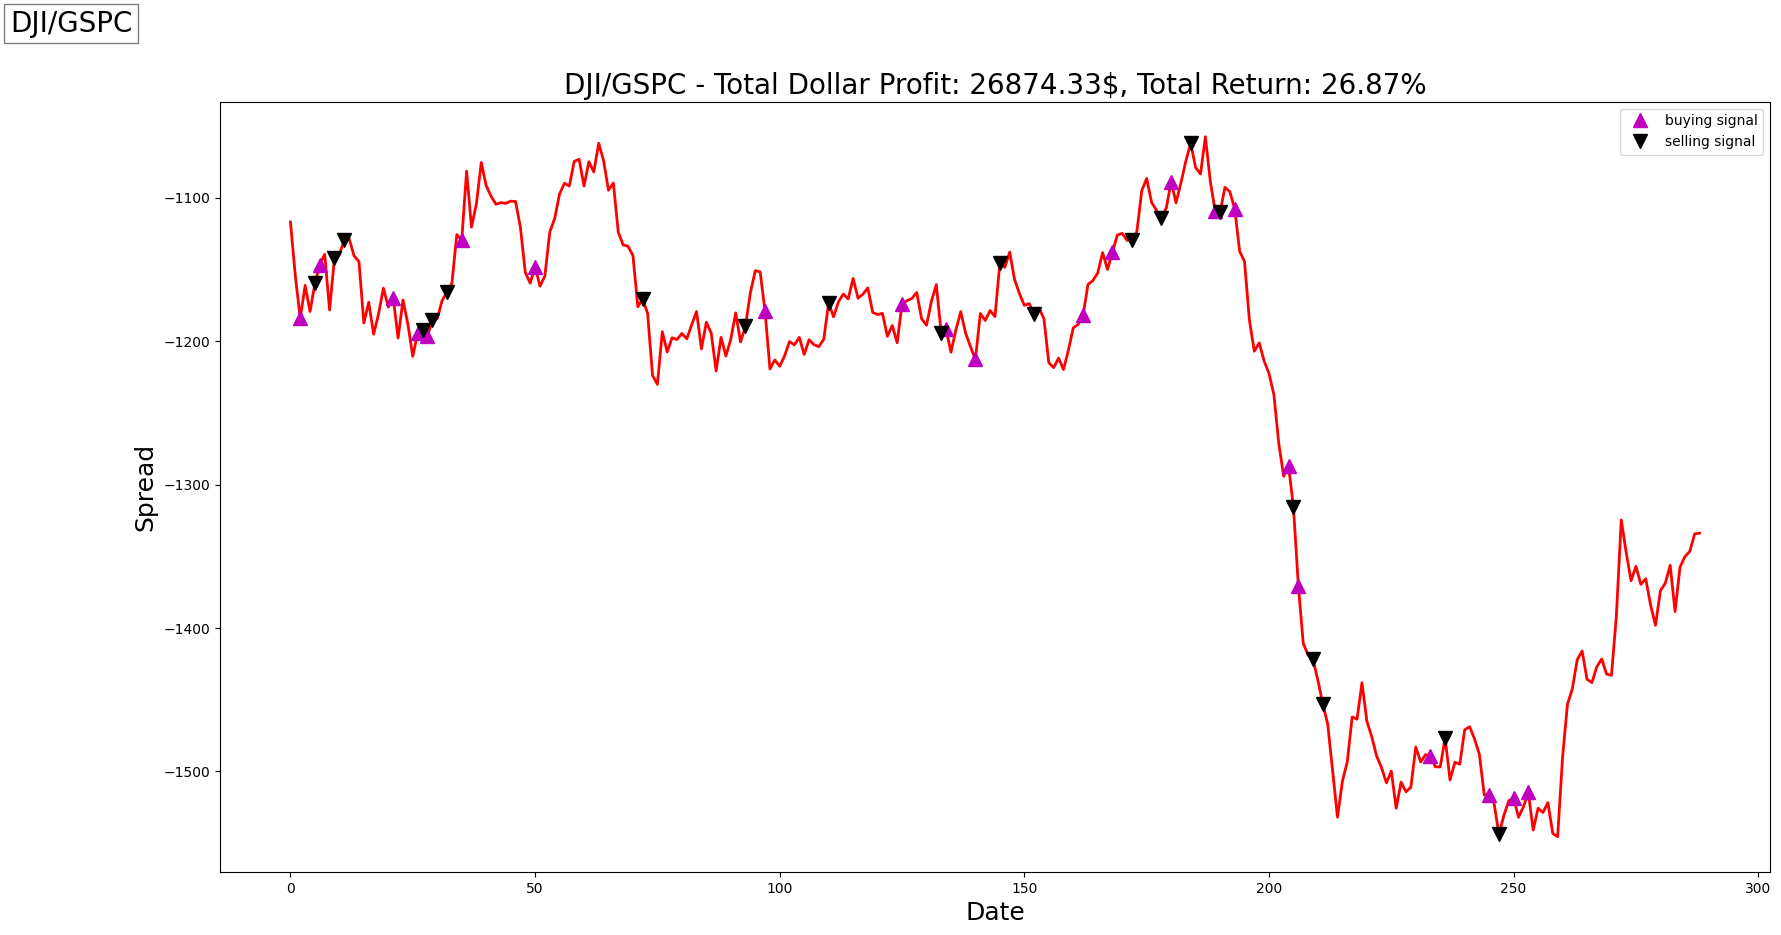

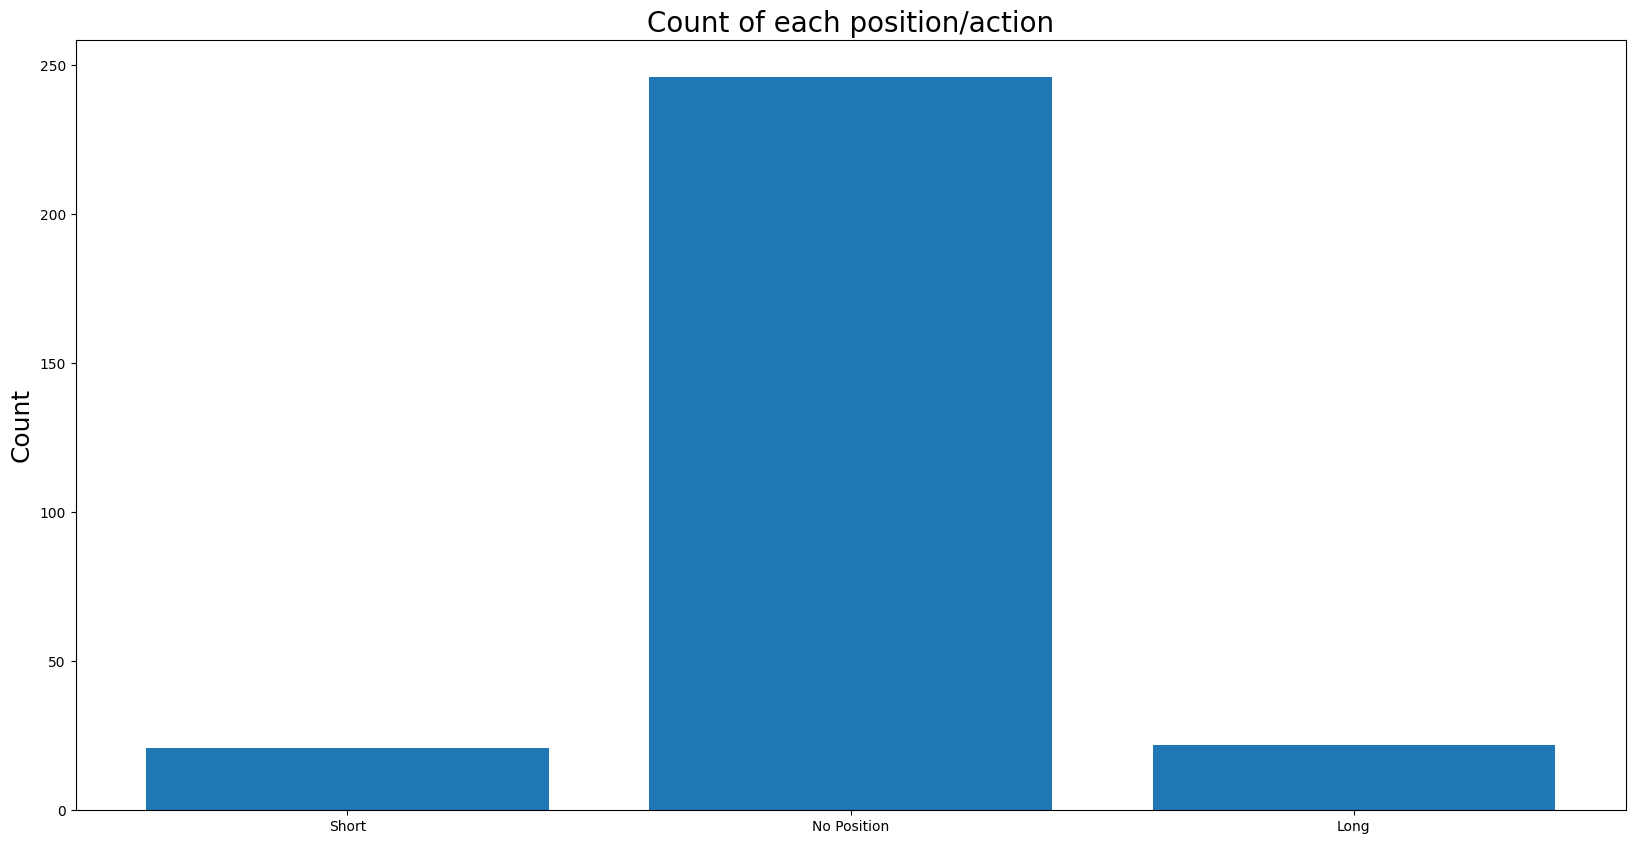

Annual return: 1.3254807286464652
Annual volatility: 0.492607895988436
Sharpe ratio: 2.6907419459585373


In [251]:
df_train = pd.read_csv('data/^DJI_^GSPC_train.csv')
df_test = pd.read_csv('data/^DJI_^GSPC_test.csv')

train_test_pair(df_train, df_test, 'DJI', 'GSPC')


epoch: 20, total rewards: 5476.840820.3, cost: 247.506431, total money: 105476.840820, The number of taken actions: 1
epoch: 40, total rewards: 5599.269531.3, cost: 127.125148, total money: 105599.269531, The number of taken actions: 1
epoch: 60, total rewards: 5404.310547.3, cost: 23.460122, total money: 105404.310547, The number of taken actions: 1
epoch: 80, total rewards: 5476.840820.3, cost: 33.186403, total money: 105476.840820, The number of taken actions: 1
epoch: 100, total rewards: 5424.240234.3, cost: 32.349114, total money: 105424.240234, The number of taken actions: 1
day 0: buy 1 sell 2 at difference 2710.150391, total balance 102710.150391
day 2: buy 2 sell 1 at difference -2704.279297, total balance 100005.871094
day 3: buy 2 sell 1 at difference -2914.740234, total balance 97091.130859
day 6: buy 1 sell 2 at difference 3019.599609, total balance 100110.730469
day 7: buy 2 sell 1 at difference -2856.070312, total balance 97254.660156
day 8: buy 1 sell 2 at difference 29

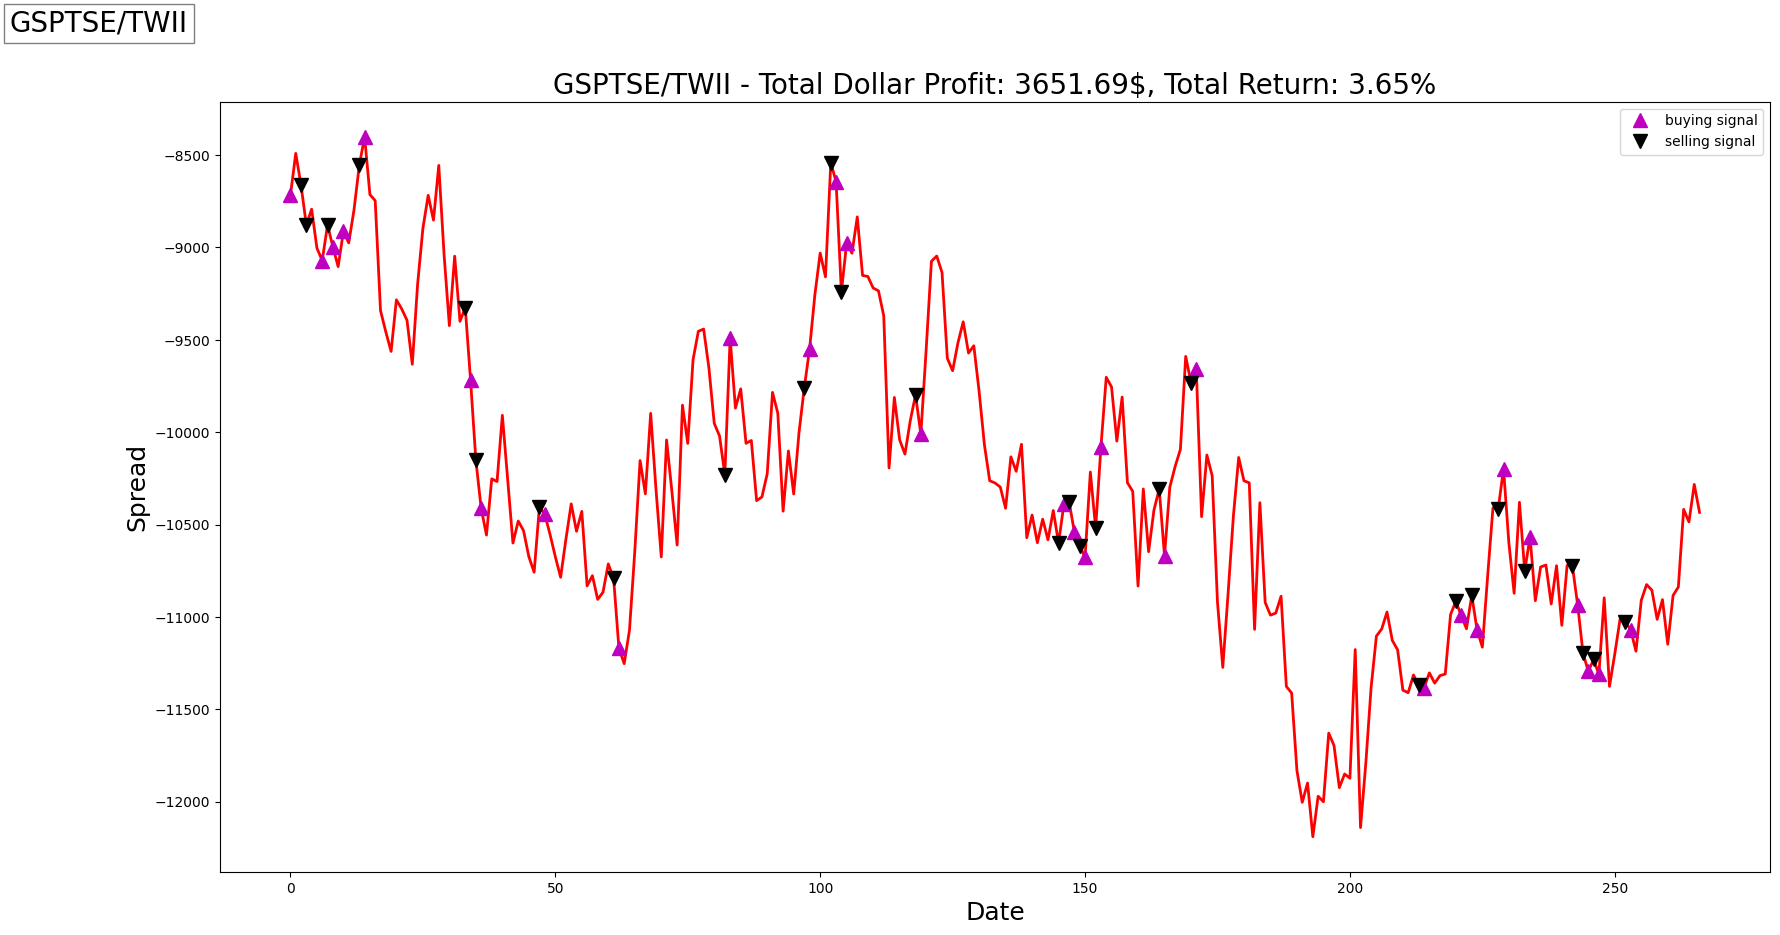

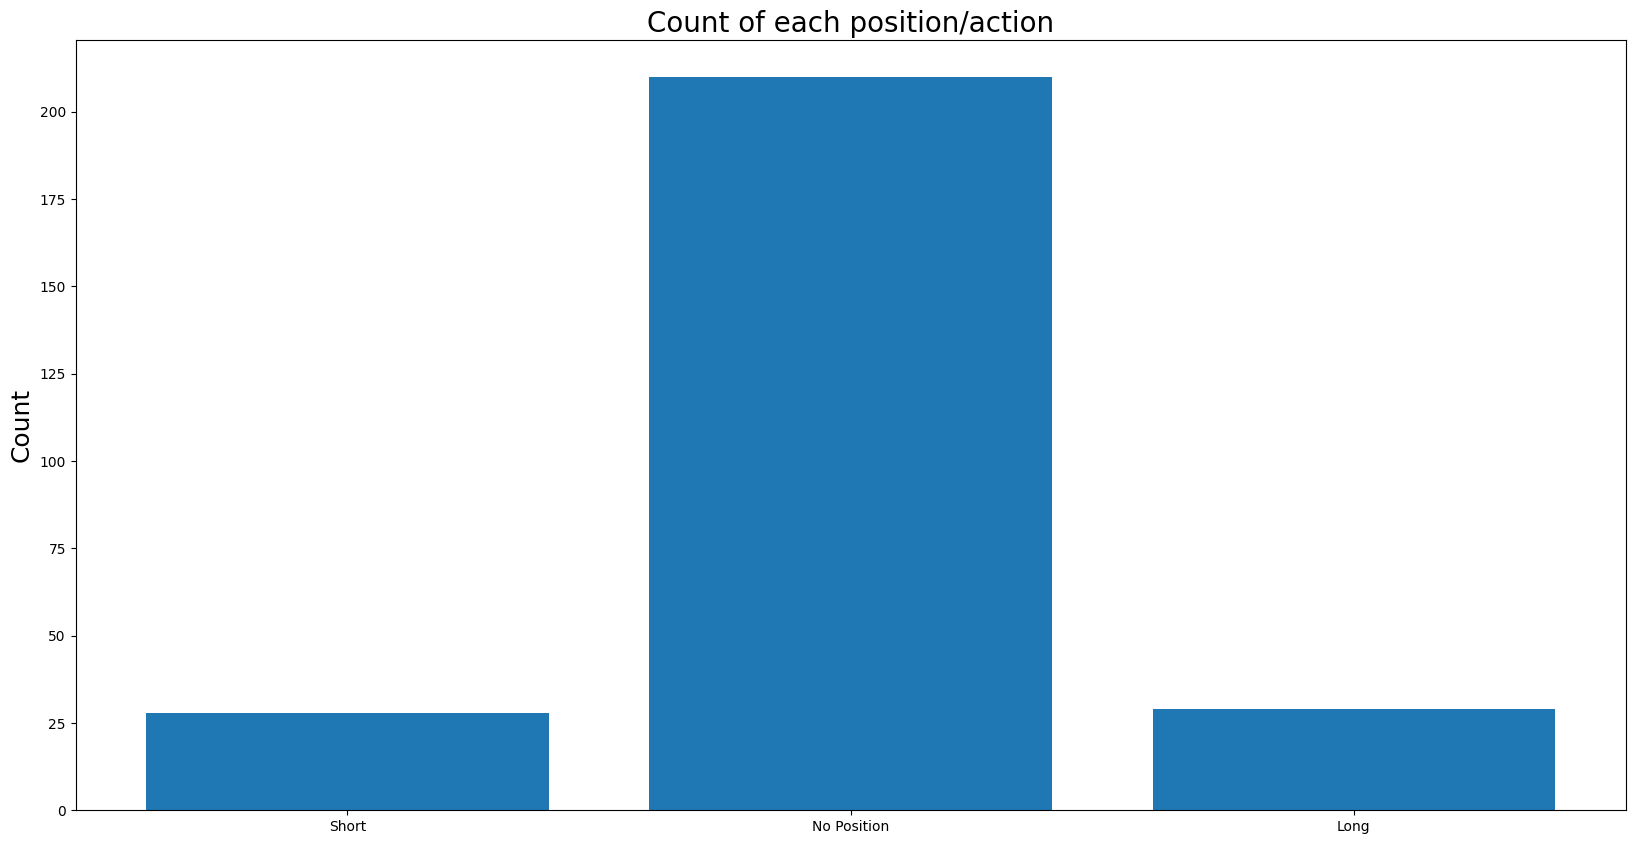

Annual return: 0.04086574900744733
Annual volatility: 0.07073432153474628
Sharpe ratio: 0.5777357882392801


In [257]:
df_train = pd.read_csv('data/^GSPTSE_^TWII_train.csv')
df_test = pd.read_csv('data/^GSPTSE_^TWII_test.csv')

train_test_pair(df_train, df_test, 'GSPTSE', 'TWII')

epoch: 20, total rewards: 4311.089844.3, cost: 7814.188663, total money: 104311.089844, The number of taken actions: 1
epoch: 40, total rewards: 4311.089844.3, cost: 3385.131283, total money: 104311.089844, The number of taken actions: 1
epoch: 60, total rewards: 4311.089844.3, cost: 5951.437241, total money: 104311.089844, The number of taken actions: 1
epoch: 80, total rewards: 4495.719727.3, cost: 5227.299474, total money: 104495.719727, The number of taken actions: 1
epoch: 100, total rewards: 4526.079834.3, cost: 6128.271804, total money: 104526.079834, The number of taken actions: 1
day 0: buy 2 sell 1 at difference 11036.239746, total balance 111036.239746
day 37: buy 1 sell 2 at difference -9309.970215, total balance 101726.269531
day 43: buy 1 sell 2 at difference -8629.870117, total balance 93096.399414
day 61: buy 2 sell 1 at difference 9690.109375, total balance 102786.508789
day 70: buy 2 sell 1 at difference 9197.000000, total balance 111983.508789
day 82: buy 1 sell 2 at

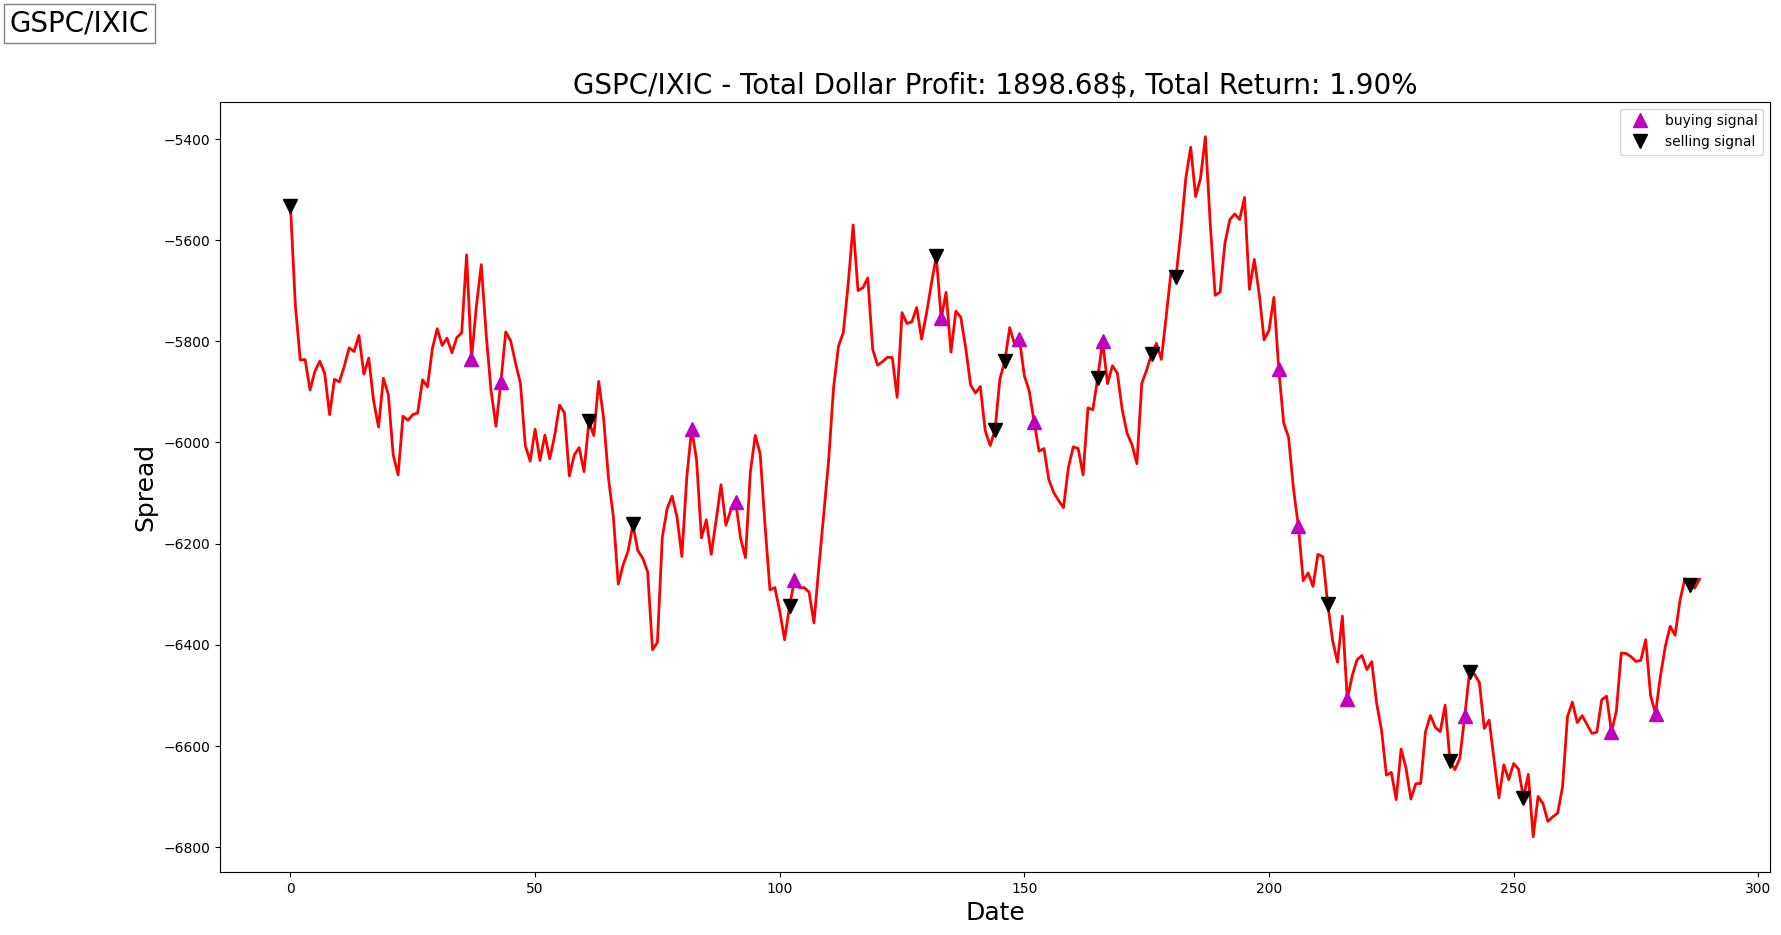

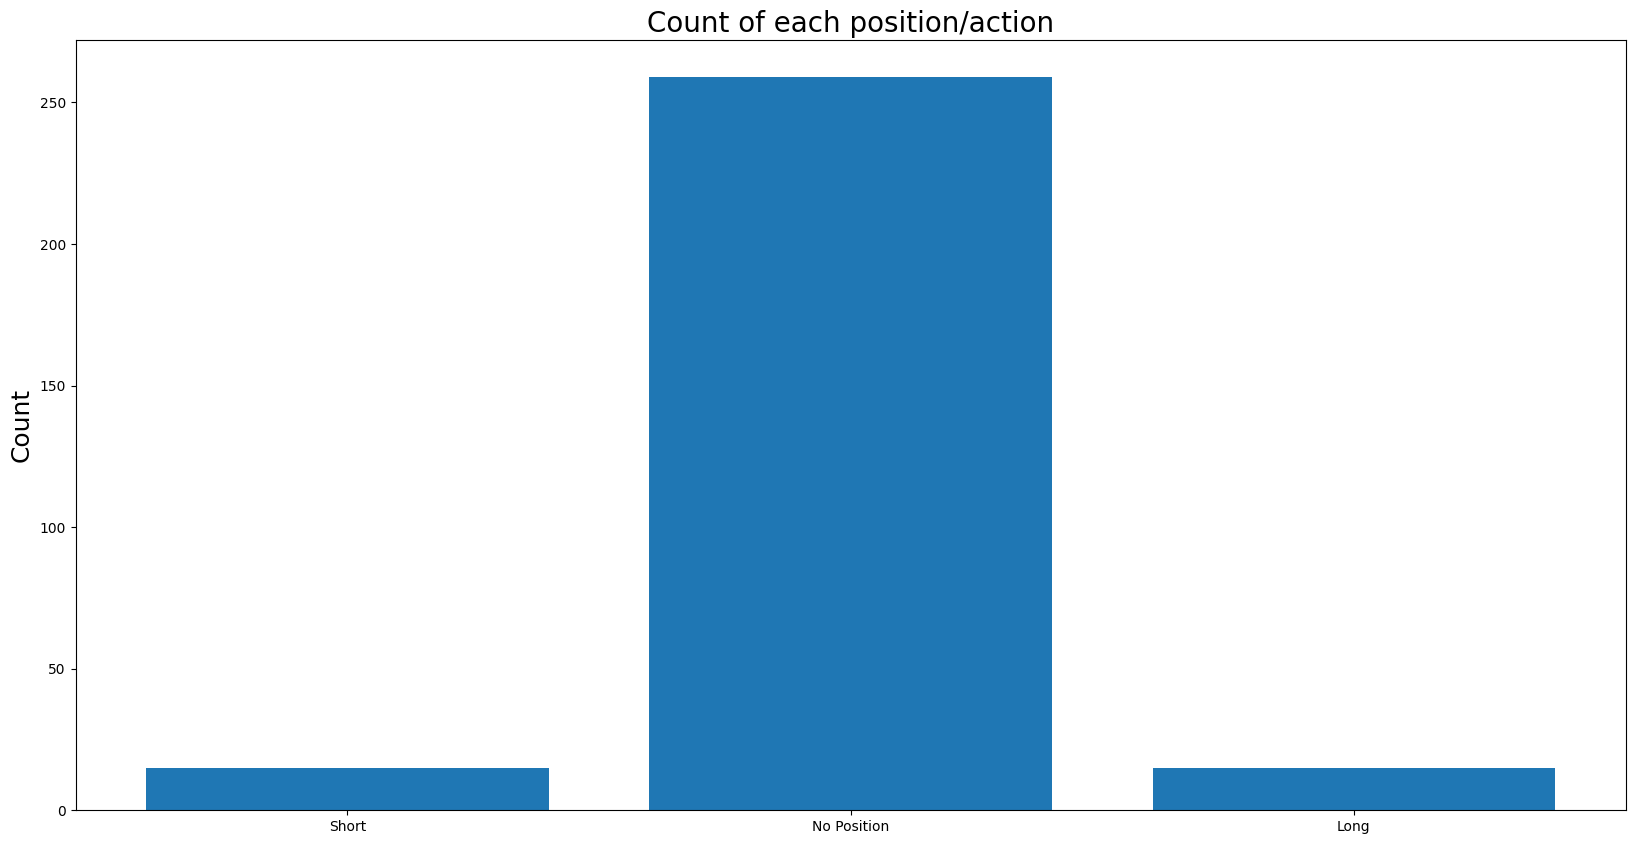

Annual return: 0.09343663365562603
Annual volatility: 0.12481880255735371
Sharpe ratio: 0.748578192878371


In [253]:
df_train = pd.read_csv('data/^GSPC_^IXIC_train.csv')
df_test = pd.read_csv('data/^GSPC_^IXIC_test.csv')

train_test_pair(df_train, df_test, 'GSPC', 'IXIC')

epoch: 20, total rewards: 11673.890381.3, cost: 6126.799732, total money: 111673.890381, The number of taken actions: 1
epoch: 40, total rewards: 11546.799561.3, cost: 6254.007970, total money: 111546.799561, The number of taken actions: 1
epoch: 60, total rewards: 11905.890137.3, cost: 3292.804617, total money: 111905.890137, The number of taken actions: 1
epoch: 80, total rewards: 11905.890137.3, cost: 8214.665548, total money: 111905.890137, The number of taken actions: 1
epoch: 100, total rewards: 11352.709717.3, cost: 5111.562214, total money: 111352.709717, The number of taken actions: 1
day 0: buy 1 sell 2 at difference 14953.539551, total balance 114953.539551
day 14: buy 2 sell 1 at difference -14380.460693, total balance 100573.078857
day 15: buy 1 sell 2 at difference 14336.290283, total balance 114909.369141
day 35: buy 2 sell 1 at difference -14075.490112, total balance 100833.879028
day 36: buy 2 sell 1 at difference -13999.980225, total balance 86833.898804
day 37: buy 1

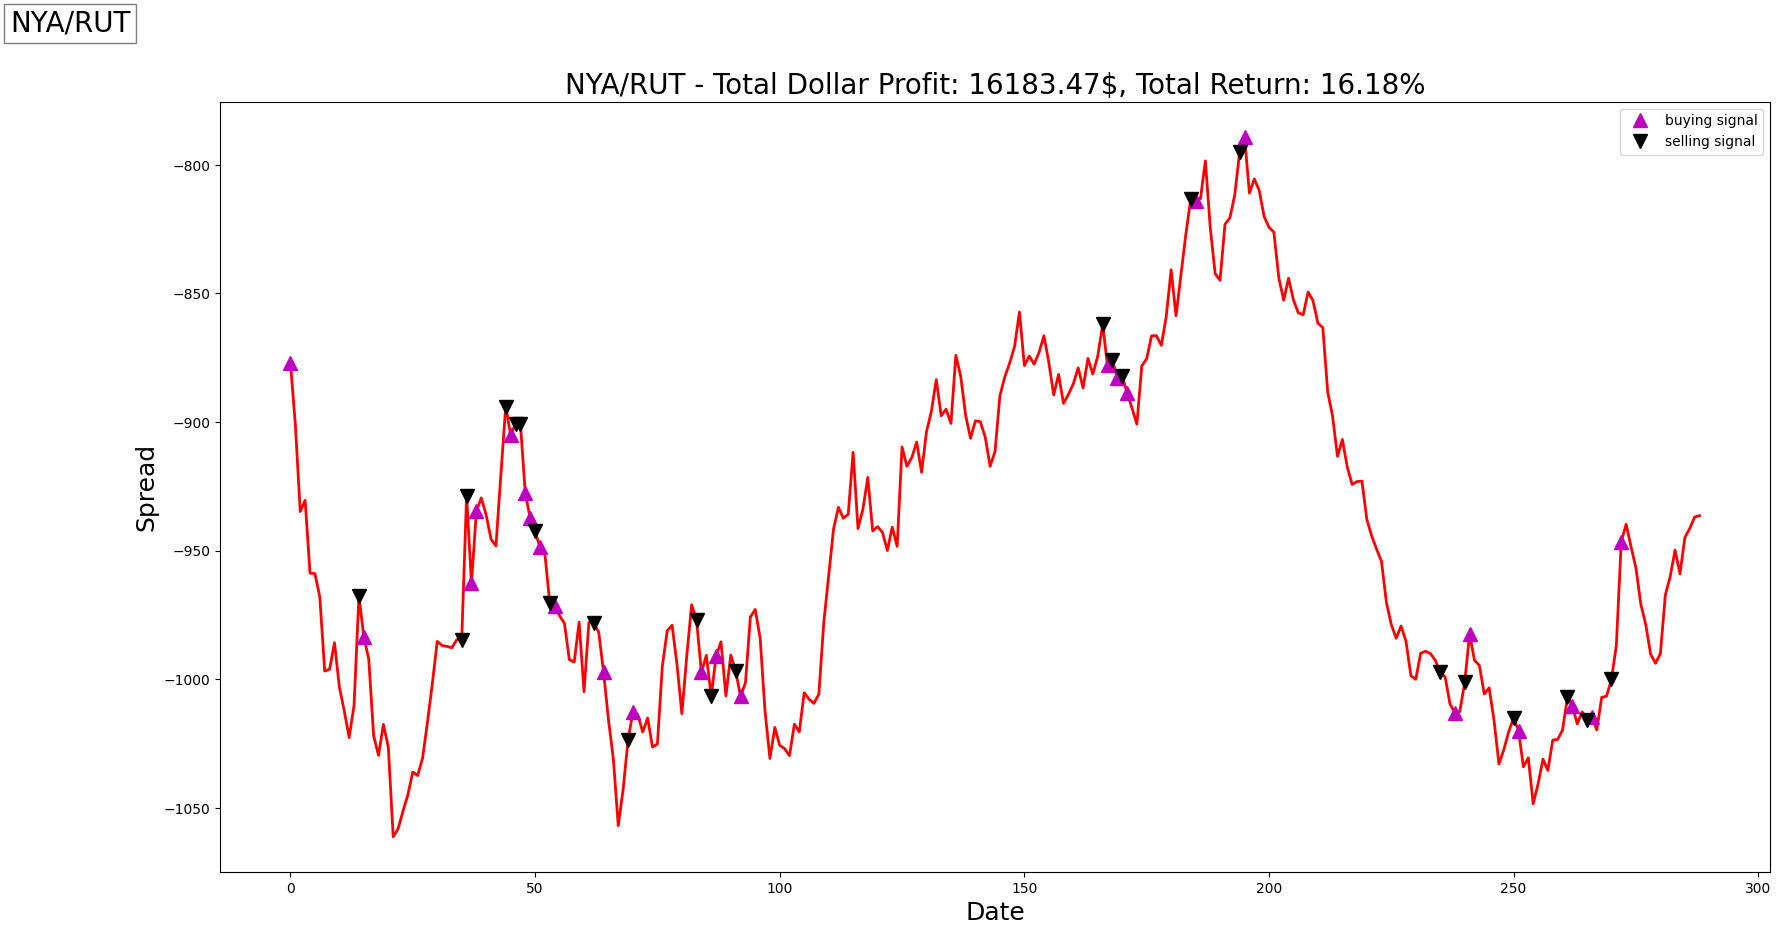

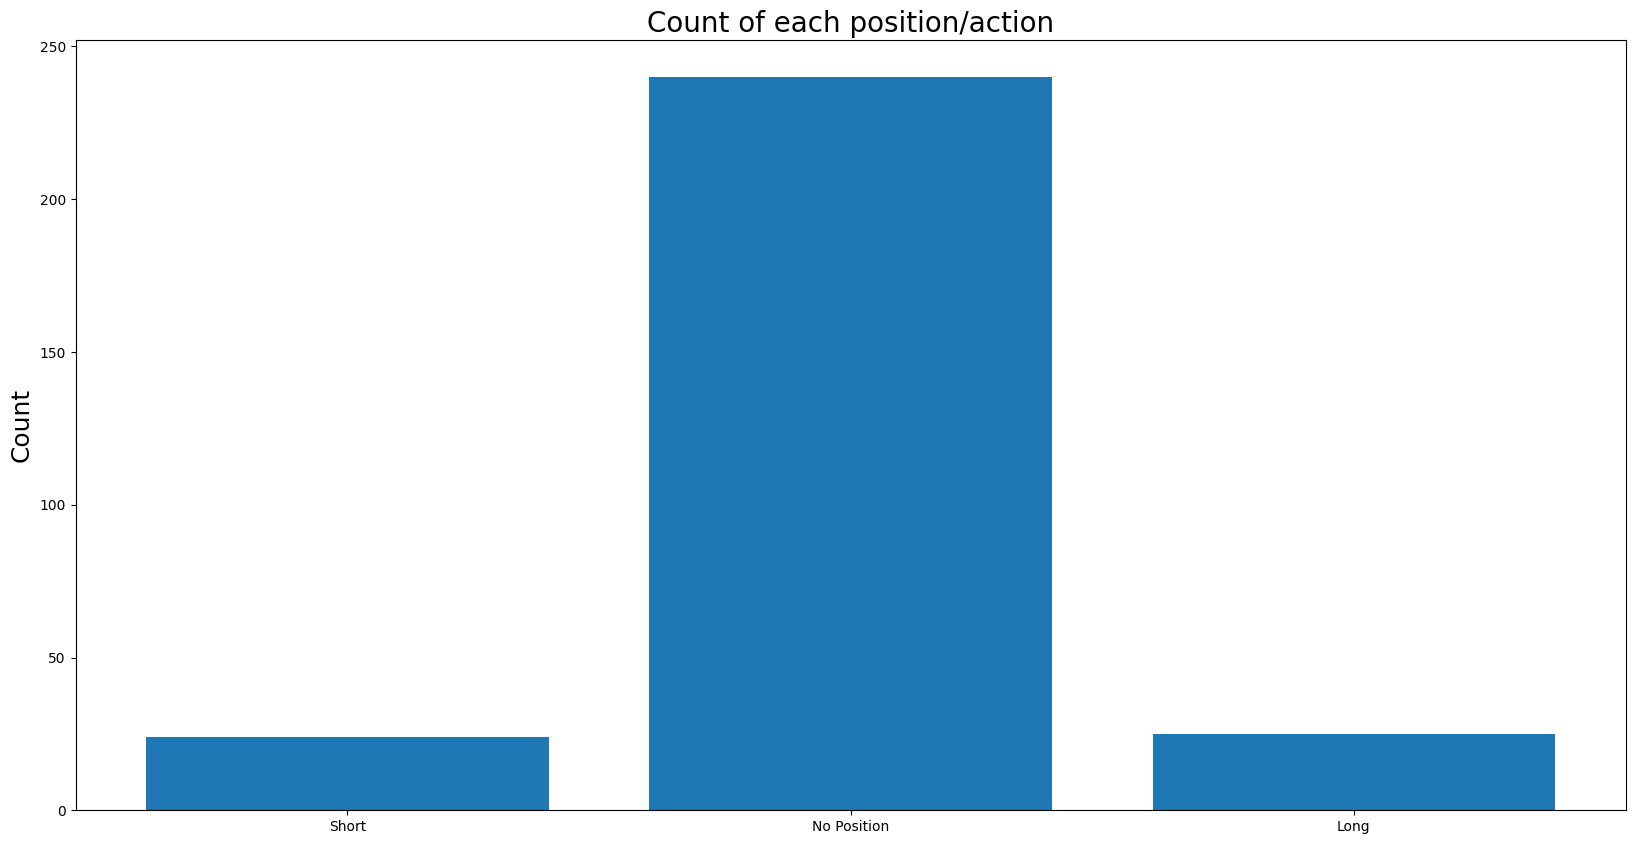

Annual return: 0.2835231103591895
Annual volatility: 0.20350939187915346
Sharpe ratio: 1.3931696603346406


In [254]:
df_train = pd.read_csv('data/^NYA_^RUT_train.csv')
df_test = pd.read_csv('data/^NYA_^RUT_test.csv')

train_test_pair(df_train, df_test, 'NYA', 'RUT')


epoch: 20, total rewards: 7829.679932.3, cost: 469.483349, total money: 107829.679932, The number of taken actions: 1
epoch: 40, total rewards: 7911.147949.3, cost: 181.026872, total money: 107911.147949, The number of taken actions: 1
epoch: 60, total rewards: 7951.054688.3, cost: 121.217758, total money: 107951.054688, The number of taken actions: 1
epoch: 80, total rewards: 7790.727295.3, cost: 96.054340, total money: 107790.727295, The number of taken actions: 1
epoch: 100, total rewards: 7829.679932.3, cost: 14.592138, total money: 107829.679932, The number of taken actions: 1
day 0: buy 2 sell 1 at difference 11158.979492, total balance 111158.979492
day 17: buy 1 sell 2 at difference -10004.589844, total balance 101154.389648
day 21: buy 2 sell 1 at difference 10051.359619, total balance 111205.749268
day 22: buy 1 sell 2 at difference -9946.160400, total balance 101259.588867
day 24: buy 1 sell 2 at difference -9694.330078, total balance 91565.258789
day 29: buy 2 sell 1 at dif

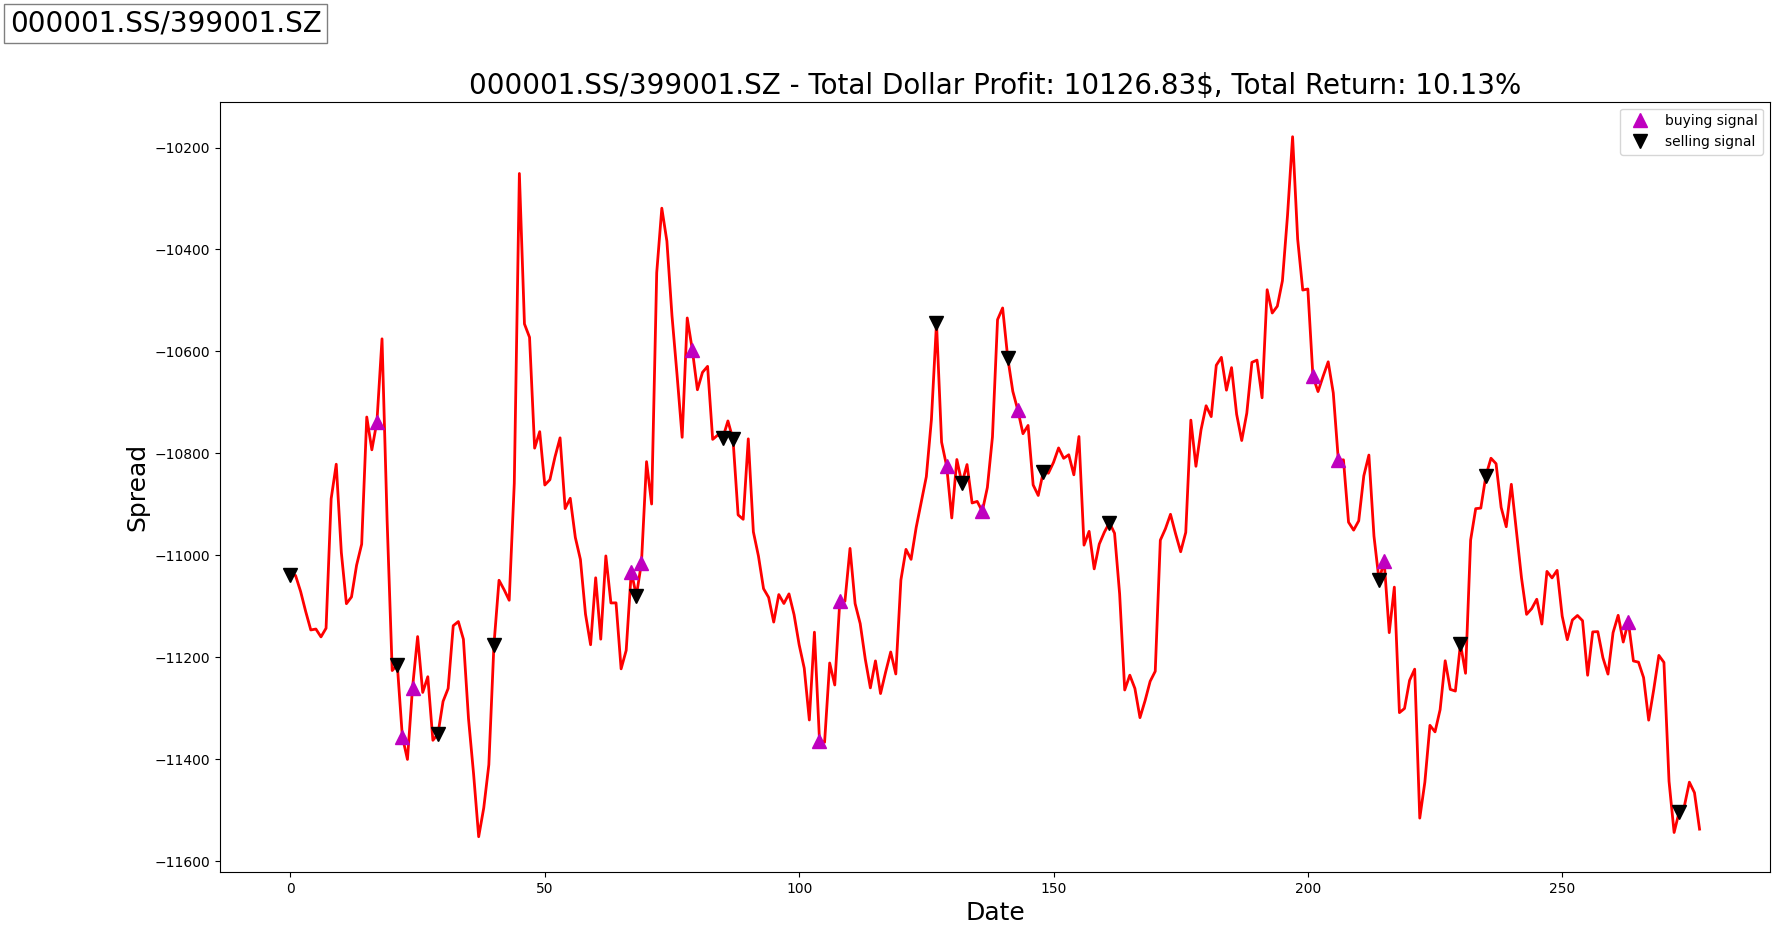

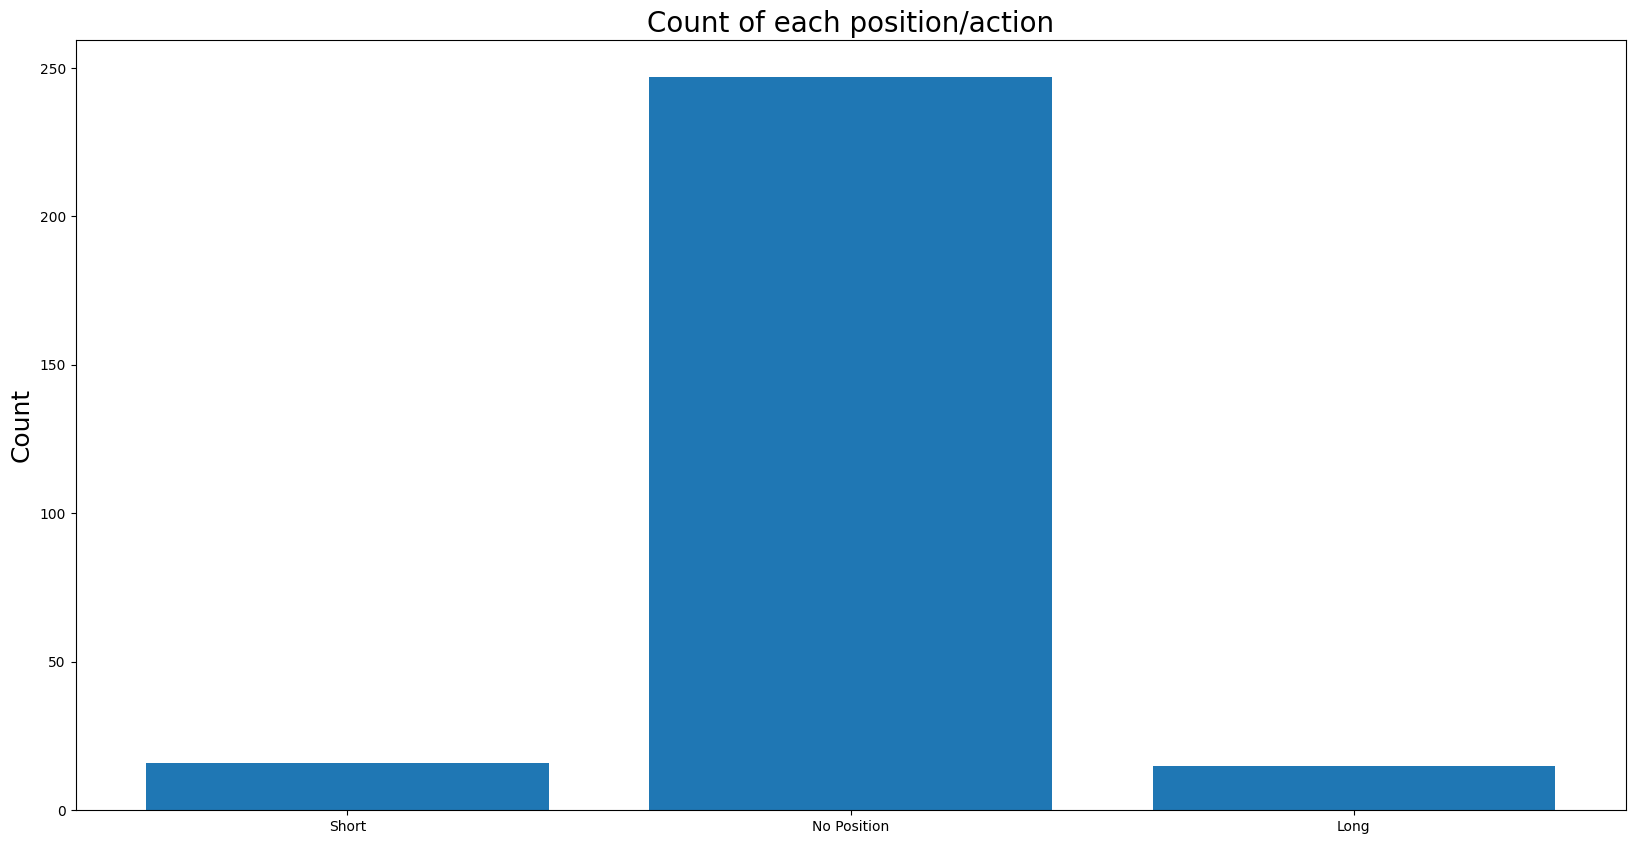

Annual return: 0.1754455104076278
Annual volatility: 0.13933983556070692
Sharpe ratio: 1.2591195454022948


In [256]:

df_train = pd.read_csv('data/000001.SS_399001.SZ_train.csv')
df_test = pd.read_csv('data/000001.SS_399001.SZ_test.csv')

train_test_pair(df_train, df_test, '000001.SS', '399001.SZ')